*This Note book referenced [WuJiaocan's Github](https://github.com/WuJiaocan/tensorflow), [XueYouluo's Github](https://github.com/xueyouluo/my_seq2seq/blob/90c86bacd5cb88ad8d381de28fe3bdf8421a0036/notebooks/MyS2S.ipynb)

*Major contribution of this notebook is: provided a flexible NMT network building (change of layers, cell-type, switch between bi-direction and uni-direction RNN, switch between attention mechanisms) based on Tensorflow through parameter setting

In [1]:
import tensorflow as tf
import codecs
import sys
import numpy as np
import time

# INSTRUCTION -0: RECORD PARAMETERS

!! Please record all hyper parameters [HERE](https://docs.google.com/spreadsheets/d/1VgRGGDv_ynvTORz3vHtH2VgRQnyxv9qBkDkPjSpDj3c/edit?usp=sharing) **BEFORE** start traning. 

This is to avoid duplicated/similar experiments among our team

# INSTRUCTION-1: SET TRAINING DATASET

Set NUM_EXAMPLES AND Run All Cells

Time for 1 Epoch on Colab GPU for reference:

1. 100,000 sentence pairs: 285s
2.  50,000 sentence pairs: 127s

### 1.Create Vocabulary

In [16]:
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("")

In [17]:
NUM_SENT = None

In [18]:
src_path = 'en_clean.txt'
tgt_path = 'fr_clean.txt'

In [19]:
def read_train_data(txt_path, num_examples):
  text = []
  with open(txt_path, 'r', encoding="utf-8") as f:
    for line in f.readlines():
      line = line[7:-6]
      text.append(line.strip('\n'))
    return text[:num_examples]

In [23]:
src = read_train_data(src_path, NUM_SENT)
tgt = read_train_data(tgt_path, NUM_SENT)

In [24]:
from sklearn.model_selection import train_test_split

src_train, src_test, tgt_train, tgt_test = train_test_split(src, tgt, test_size=0.005, random_state=42)

In [25]:
len(src_train), len(src_test), len(tgt_train), len(tgt_test)

(609813, 3065, 609813, 3065)

In [0]:
# print('size of number of source sentences from dataset for training: {}'.format(len(src_train)))
# print('size of number of target sentences from dataset for training: {}'.format(len(tgt_train)))

size of number of source sentences from dataset for training: 609813
size of number of target sentences from dataset for training: 609813


In [0]:
# print('size of number of source sentences from dataset for testing: {}'.format(len(src_test)))
# print('size of number of target sentences from dataset for testing: {}'.format(len(tgt_test)))

size of number of source sentences from dataset for testing: 3065
size of number of target sentences from dataset for testing: 3065


In [0]:
# src_train[10], tgt_train[10]

(' dry syndrome and autoimmune dysthyroidism ',
 ' syndrome sec et dysthyroidies auto immunes ')

In [0]:
# def read_test_data(txt_path, num_examples = 400):
#   text = []
#   with open(txt_path, 'r', encoding="utf-8") as f:
#     for line in f.readlines():
#       line = line[7:-6]
#       text.append(line.strip('\n'))
#     return text[-num_examples:]

In [0]:
# import codecs
# import collections
# from operator import itemgetter

# def create_vocab(RAW_DATA, VOCAB_OUTPUT):
#     counter = collections.Counter()

#     for line in RAW_DATA:
#         for word in line.strip().lower().split():
#             counter[word] += 1

#     sorted_word_to_cnt = sorted(counter.items(), key=itemgetter(1), reverse=True)
#     sorted_words = [x[0] for x in sorted_word_to_cnt]

#     sorted_words =  ['<pad>'] + ['<sos>'] + ['<eos>'] + ['<unk>'] + sorted_words 

#     with codecs.open(VOCAB_OUTPUT, "w", encoding="utf-8") as file_output:
#         for word in sorted_words:
#             file_output.write(word + "\n")
#     return sorted_words

In [0]:
# vocab_src = create_vocab(src_train, 'vocab_full.en')
# vocab_tgt = create_vocab(tgt_train, 'vocab_full.fr')

In [0]:
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)

# print('size of source vocab {}'.format(vocab_size_src))
# print('size of target vocab {}'.format(vocab_size_tgt))

size of source vocab 118476
size of target vocab 151377


In [0]:
# print(vocab_src[-5:])

['posted', 'nematocerous', 'triphenylacetate', 'ballistography', 'polyclinical']


In [0]:
# print(vocab_tgt[-5:])

['pneomopathie', 'posturographiques', 'influnce', 'meracarpo', 'vauthier']


### 2.Convert Text to Numbers

In [0]:
# import codecs
# import sys

# def text_to_int(RAW_DATA, VOCAB, OUTPUT_DATA):

#   with codecs.open(VOCAB, "r", encoding="utf-8") as f_vocab:
#       vocab = [w.strip() for w in f_vocab.readlines()]
#       word_to_id = {k:v for (k,v) in zip(vocab, range(len(vocab)))}

#   def get_id(word):
#       return word_to_id[word] if word in word_to_id else word_to_id["<unk>"]

#   fout = codecs.open(OUTPUT_DATA, "w", encoding="utf-8")
#   for line in RAW_DATA:
#       words = line.strip().split() + ["<eos>"]

#       out_line = " ".join([str(get_id(w)) for w in words]) + "\n"
#       fout.write(out_line)
#   fout.close()

In [0]:
# text_to_int(src_train, 'vocab_full.en', 'train_full.en')
# text_to_int(tgt_train, 'vocab_full.fr', 'train_full.fr')

### 4. Create Training Dataset

In [2]:
def MakeDataset(file_path):
    dataset = tf.data.TextLineDataset(file_path)
    # split by space
    dataset = dataset.map(lambda string: tf.string_split([string]).values)
    # convert string to number
    dataset = dataset.map(
        lambda string: tf.string_to_number(string, tf.int32))
    # calc # word/sentence and put in dataset with sentence
    dataset = dataset.map(lambda x: (x, tf.size(x)))
    return dataset

def MakeSrcTrgDataset(src_path, trg_path, batch_size):

    src_data = MakeDataset(src_path)
    trg_data = MakeDataset(trg_path)
    #   ds[0][0]source sentence
    #   ds[0][1]len of source sentence
    #   ds[1][0]target sentence
    #   ds[1][1]len of target sentence
    dataset = tf.data.Dataset.zip((src_data, trg_data))

    # delete empty and super-long sentence
    def FilterLength(src_tuple, trg_tuple):
        ((src_input, src_len), (trg_label, trg_len)) = (src_tuple, trg_tuple)
        src_len_ok = tf.logical_and(
            tf.greater(src_len, 1), tf.less_equal(src_len, MAX_LEN))
        trg_len_ok = tf.logical_and(
            tf.greater(trg_len, 1), tf.less_equal(trg_len, MAX_LEN))
        return tf.logical_and(src_len_ok, trg_len_ok)
    dataset = dataset.filter(FilterLength)
    
    #   1.trg_input: "<sos> X Y Z"
    #   2.trg_label: "X Y Z <eos>"
    #   file: "X Y Z <eos>", need to produce "<sos> X Y Z" and add to dataset
    def MakeTrgInput(src_tuple, trg_tuple):
        ((src_input, src_len), (trg_label, trg_len)) = (src_tuple, trg_tuple)
        trg_input = tf.concat([[SOS_ID], trg_label[:-1]], axis=0)
        return ((src_input, src_len), (trg_input, trg_label, trg_len))
    
    dataset = dataset.map(MakeTrgInput)

    dataset = dataset.shuffle(10000)

    # define shape after padding
    padded_shapes = (
        (tf.TensorShape([None]),
         tf.TensorShape([])), 
        (tf.TensorShape([None]),
         tf.TensorShape([None]),
         tf.TensorShape([]))) 
    
    # padded_batch to pad
    batched_dataset = dataset.padded_batch(batch_size, padded_shapes)
    return batched_dataset

### 3.Define NMT

In [3]:
def single_rnn_cell(cell_name, hid_size, keep_prob):
    if cell_name == "GRU":
        cell = tf.contrib.rnn.GRUCell(hid_size)
    elif cell_name == "LSTM":
        cell = tf.contrib.rnn.LSTMCell(hid_size)
    elif cell_name == "BASIC":
        cell = tf.contrib.rnn.BasicRNNCell(hid_size)
        
    if keep_prob < 1.0:
      cell = tf.contrib.rnn.DropoutWrapper(
            cell=cell,
            input_keep_prob=keep_prob,
            output_keep_prob=keep_prob)
    
    return cell


def multi_rnn_cell(cell_name, hid_size, num_layers, keep_prob):
    cells = []
    for _ in range(num_layers):
        cell = single_rnn_cell(cell_name, hid_size, keep_prob)
        cells.append(cell)
    
    if len(cells) > 1:
        final_cell = tf.contrib.rnn.MultiRNNCell(cells=cells)
    else:
        final_cell = cells[0]
    return final_cell
  
  
def single_biRNN_pair(cell_name, hid_size, keep_prob):
    if cell_name == "bi-GRU":
      enc_cell_fw = single_rnn_cell('GRU', hid_size, keep_prob)
      enc_cell_bw = single_rnn_cell('GRU', hid_size, keep_prob)
    elif cell_name == "bi-LSTM":
      enc_cell_fw = single_rnn_cell('LSTM', hid_size, keep_prob)
      enc_cell_bw = single_rnn_cell('LSTM', hid_size, keep_prob)
    return enc_cell_fw, enc_cell_bw
    
def multi_biRNN_pair(cell_name, hid_size, num_layers, keep_prob):
    stacked_biRNN_fw = []
    stacked_biRNN_bw = []
    for _ in range(num_layers):
        enc_cell_fw, enc_cell_bw = single_biRNN_pair(cell_name, hid_size, keep_prob)
        stacked_biRNN_fw.append(enc_cell_fw)
        stacked_biRNN_bw.append(enc_cell_bw)
    
    if len(stacked_biRNN_fw) > 1:
        final_stacked_biRNN_fw = tf.contrib.rnn.MultiRNNCell(cells=stacked_biRNN_fw)
        final_stacked_biRNN_bw = tf.contrib.rnn.MultiRNNCell(cells=stacked_biRNN_bw)
    else:
        final_stacked_biRNN_fw = stacked_biRNN_fw[0]
        final_stacked_biRNN_bw = stacked_biRNN_bw[0]
    return final_stacked_biRNN_fw, final_stacked_biRNN_bw

In [4]:
class NMTModel(object):
  """
  defind the nmt model
  
  """
  # define variables needed by nmt
  def __init__(self, 
               dec_layer, 
               enc_layer,
               dec_cell_name, 
               enc_cell_name,
               optimizer, 
               lr,
               hid_size, 
               attention,
               drop_out):
    
    self.dec_cell_name = dec_cell_name
    self.enc_cell_name = enc_cell_name
    self.dec_layer = dec_layer
    self.enc_layer = enc_layer
    self.attention = attention
    
    self.hid_size = hid_size
    self.opt = optimizer
    self.lr = lr
    
    self.keep_prob = 1.0 - drop_out

    # EMBEDDING SETUP
    
    self.src_embedding = tf.get_variable(
          "src_emb", [SRC_VOCAB_SIZE, self.hid_size])
    self.trg_embedding = tf.get_variable(
          "trg_emb", [TRG_VOCAB_SIZE, self.hid_size])

      # define variables for softmax layer
    if SHARE_EMB_AND_SOFTMAX:
         self.softmax_weight = tf.transpose(self.trg_embedding)
    else:
         self.softmax_weight = tf.get_variable(
             "weight", [self.hid_size, TRG_VOCAB_SIZE])
    self.softmax_bias = tf.get_variable(
          "softmax_bias", [TRG_VOCAB_SIZE])
     
  # calculate forward graph
  # src_input, src_size, trg_input, trg_label, trg_size are from MakeSrcTrgDataset
  
  def forward(self, src_input, src_size, trg_input, trg_label, trg_size):
      batch_size = tf.shape(src_input)[0]
      
      # *************************
      # **** EMBEDDING SCOPE ****
      # *************************
      
      with tf.variable_scope("Embeddings"):

        # convert word_int input to embeddings
        src_emb = tf.nn.embedding_lookup(self.src_embedding, src_input)
        trg_emb = tf.nn.embedding_lookup(self.trg_embedding, trg_input)

        # set drop_out rate
        src_emb = tf.nn.dropout(src_emb, self.keep_prob)
        trg_emb = tf.nn.dropout(trg_emb, self.keep_prob)

      # *************************
      # ***** ENCODER SCOPE *****
      # *************************

      with tf.variable_scope("encoder"):
        
        if not 'bi' in self.enc_cell_name:
        
          enc_cell = multi_rnn_cell(self.enc_cell_name, 
                                    self.hid_size, 
                                    self.enc_layer, 
                                    self.keep_prob)
          enc_outputs, enc_state = tf.nn.dynamic_rnn(enc_cell, 
                                                     inputs=src_emb, 
                                                     sequence_length=src_size, 
                                                     dtype=tf.float32) 
        
        else:
          
          stacked_biRNN_fw, stacked_biRNN_bw = multi_biRNN_pair(self.enc_cell_name, 
                                                                self.hid_size, 
                                                                self.enc_layer, 
                                                                self.keep_prob)
          enc_outputs, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw = stacked_biRNN_fw,
                                                                   cell_bw = stacked_biRNN_bw,
                                                                   inputs = src_emb,
                                                                   sequence_length = src_size,
                                                                   dtype = tf.float32)
          
          # concatenate two outputs of LSTM cell as 1 tensor
          # enc_outputs = (output_fw, output_bw)
          enc_outputs = tf.concat([enc_outputs[0], enc_outputs[1]], -1)
          
    
      # *************************
      # ***** DECODER SCOPE *****
      # *************************
      
      with tf.variable_scope("decoder"):
        
        dec_cell = multi_rnn_cell(self.dec_cell_name, self.hid_size, self.dec_layer, self.keep_prob)
    
    
        # OPTIONS FOR ATTENTION MECHANISM
        if self.attention == 'Bahdanau':
        
          attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                  self.hid_size, 
                  enc_outputs,
                  memory_sequence_length = src_size)
          
        if self.attention == 'Luong':

          attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                  self.hid_size,
                  enc_outputs,
                  memory_sequence_length=src_size)

        # ATTENTION WRAPPER: 
        # wrap dec_cell and attention mechanisim
        attention_cell = tf.contrib.seq2seq.AttentionWrapper(
                dec_cell, 
                attention_mechanism,
                attention_layer_size=self.hid_size)

        # use attention_cell and dynamic_rnn construct decoder
        # here relay totally on attention as the information source
        dec_outputs, _ = tf.nn.dynamic_rnn(
                attention_cell, trg_emb, trg_size, dtype=tf.float32)

        
      # ************************
      # ***** OPTIMIZATION *****
      # ************************
      
      # LOSS/LOG PERPLEXITY
      output = tf.reshape(dec_outputs, [-1, HIDDEN_SIZE])
      logits = tf.matmul(output, self.softmax_weight) + self.softmax_bias
      loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=tf.reshape(trg_label, [-1]), logits=logits)

      # set padding weight as 0 when calc average loss
      label_weights = tf.sequence_mask(
          trg_size, maxlen=tf.shape(trg_label)[1], dtype=tf.float32)
      label_weights = tf.reshape(label_weights, [-1])
      cost = tf.reduce_sum(loss * label_weights)
      cost_per_token = cost / tf.reduce_sum(label_weights)

      # define backprop
      trainable_variables = tf.trainable_variables()

      # OPTIONS FOR OPTIMIZER
      # define optimization method/steps
      grads = tf.gradients(cost / tf.to_float(batch_size),
                           trainable_variables)
      
      grads, _ = tf.clip_by_global_norm(grads, clip_norm = 5)

      if self.opt == 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate = self.lr)
      
      elif self.opt == 'sgd':        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = self.lr)
        
      elif self.opt == 'rmsprop':     
        optimizer = tf.train.RMSPropOptimizer(learning_rate = self.lr)
      
      train_op = optimizer.apply_gradients(zip(grads, trainable_variables))
      
      return cost_per_token, train_op

### 4.Training

In [5]:
def run_epoch(session, cost_op, train_op, saver, step):
    while True:
        try:
            # execute train_op and calc loss
            cost, _ = session.run([cost_op, train_op])
            if step % 10 == 0:
                print("After %d steps, per token cost is %.3f" % (step, cost))
            # save checkpoint per 200 steps
            if step % 200 == 0:
                saver.save(session, CHECKPOINT_PATH, global_step=step)
            step += 1
        except tf.errors.OutOfRangeError:
            break
    return step

#INSTRUCTION-2: SET TRAINING HYPER PARAMETERS

1. Normally just leave following things as they are, unless changed training dataset or dataset size:
  * SRC_TRAIN_DATA,
  * TRG_TRAIN_DATA,
  * SRC_VOCAB_SIZE
  * TRG_VOCAB_SIZE

2. Need to change CHECKPOINT_PATH each time for a training to distinguish different training setting (for easier recording)

3. Following Prameters can be tuned for research and experiment purpose:

  * HIDDEN_SIZE (# INTEGER)
  * DECODER_LAYERS (# INTEGER)
  * DECODER_CELL_TYPE (OPTIONS: 'LSTM', 'GRU', 'BASIC')
  * ENCODER_LAYERS (# INTEGER)
  * ENCODER_CELL_TYPE (OPTIONS: 'LSTM', 'GRU', 'BASIC', 'bi-LSTM', 'bi-GRU')
  * ATTENTION ('Luong', 'Bahdanau')
  * DROP_OUT (0~1.0)
  * OPTIMIZER (OPTIONS: 'adam', 'sgd', 'rmsprop')
  * LEARNING_RATE (0.0001 ~ 0.1)
  * NUM_EPOCH (#INTEGER: dont' use big number as it consumes time, could keep consistent across all experiments to compare whose loss decreased the most in certain epochs)
  * BATCH_SIZE (#INTEGER: 32, 64, 128, 256...)
  
  
  **NOTICE: ALL PARAM NAMES ARE CASE SENSITIVE**

In [0]:
CHECKPOINT_PATH = "./ckpt-final/nmt-"  

HIDDEN_SIZE = 512
DECODER_LAYERS = 4                    # Num_layer for decoder LSTM
DECODER_CELL_TYPE = 'BASIC'
ENCODER_LAYERS = 4
ENCODER_CELL_TYPE = 'BASIC'
ATTENTION = 'Bahdanau'
OPTIMIZER = 'rmsprop'
DROPOUT = 0.2
LEARNING_RATE = 0.001

BATCH_SIZE = 128
NUM_EPOCH = 20


SRC_TRAIN_DATA = "train_full.en"
TRG_TRAIN_DATA = "train_full.fr"
SRC_VOCAB_SIZE = vocab_size_src       
TRG_VOCAB_SIZE = vocab_size_tgt 
SHARE_EMB_AND_SOFTMAX = True           # share weights between softmax layer and embedding layer
MAX_LEN = 100   # max length of a sentence
SOS_ID  = 1    # <sos> ID in target vocab

import time
def main():
  
    initializer = tf.random_uniform_initializer(-0.05, 0.05)
    
    tf.reset_default_graph()

    with tf.variable_scope("nmt_model", reuse=None, 
                           initializer=initializer):
        train_model = NMTModel(
                dec_layer = DECODER_LAYERS, 
                enc_layer = ENCODER_LAYERS,
                dec_cell_name =  DECODER_CELL_TYPE,
                enc_cell_name = ENCODER_CELL_TYPE,
                optimizer = OPTIMIZER, 
                lr = LEARNING_RATE,
                hid_size = HIDDEN_SIZE, 
                attention = ATTENTION,
                drop_out = DROPOUT)
  
    # define input data
    data = MakeSrcTrgDataset(SRC_TRAIN_DATA, TRG_TRAIN_DATA, BATCH_SIZE)
    iterator = data.make_initializable_iterator()
    (src, src_size), (trg_input, trg_label, trg_size) = iterator.get_next()
 
    # define forward graph
    cost_op, train_op = train_model.forward(src, src_size, trg_input,
                                            trg_label, trg_size)

    # train
    saver = tf.train.Saver()
    tf.add_to_collection('train_op', train_op)
    tf.add_to_collection('cost_op', cost_op)
    step = 0
    with tf.Session() as sess:
        writer = tf.summary.FileWriter('logs', sess.graph)
        writer.close()
        
        tf.global_variables_initializer().run()
        for i in range(NUM_EPOCH):
            time_start=time.time()
            print("-------In iteration: %d" % (i + 1))
            sess.run(iterator.initializer)
            step = run_epoch(sess, cost_op, train_op, saver, step)
            time_end=time.time()
            print('-------time cost',time_end-time_start,'s')
            print('                                        ')
            
if __name__ == "__main__":
    main()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
-------In iteration: 1
After 0 steps, per token cost is 10.498
After 10 steps, per token cost is 10.477
After 20 st

### 5. Produce Model Structure

In [0]:
import tensorflow.contrib.slim as slim

def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

model_summary()

---------
Variables: name (type shape) [size]
---------
nmt_model/src_emb:0 (float32_ref 28711x512) [14700032, bytes: 58800128]
nmt_model/trg_emb:0 (float32_ref 35019x512) [17929728, bytes: 71718912]
nmt_model/softmax_bias:0 (float32_ref 35019) [35019, bytes: 140076]
encoder/rnn/multi_rnn_cell/cell_0/basic_rnn_cell/kernel:0 (float32 1024x512) [524288, bytes: 2097152]
encoder/rnn/multi_rnn_cell/cell_0/basic_rnn_cell/bias:0 (float32 512) [512, bytes: 2048]
encoder/rnn/multi_rnn_cell/cell_1/basic_rnn_cell/kernel:0 (float32 1024x512) [524288, bytes: 2097152]
encoder/rnn/multi_rnn_cell/cell_1/basic_rnn_cell/bias:0 (float32 512) [512, bytes: 2048]
encoder/rnn/multi_rnn_cell/cell_2/basic_rnn_cell/kernel:0 (float32 1024x512) [524288, bytes: 2097152]
encoder/rnn/multi_rnn_cell/cell_2/basic_rnn_cell/bias:0 (float32 512) [512, bytes: 2048]
encoder/rnn/multi_rnn_cell/cell_3/basic_rnn_cell/kernel:0 (float32 1024x512) [524288, bytes: 2097152]
encoder/rnn/multi_rnn_cell/cell_3/basic_rnn_cell/bias:0 (

# INSTRUCTION 3 - INFERENCE USING TRAINED MODEL AND WEIGHT

### 6.Define Model Structure, Hyper Parameter Used in Training, Inference Function

1. Need to change LAST_CKPT_PATH every time you train and set it to the latest checkpoint, which is presented by the biggest number in CHECKPOINT_PATH

2. Keep other parameters as they are in the traning session, no need to change here

In [6]:
# read checkpoint path, number indicates the latest step
LAST_CKPT_PATH = "nmt-197000"

# hyper parameters
HIDDEN_SIZE = 256
DECODER_LAYERS = 2                    # Num_layer for decoder LSTM
DECODER_CELL_TYPE = 'LSTM'
ENCODER_LAYERS = 1
ENCODER_CELL_TYPE = 'bi-LSTM'
ATTENTION = 'Luong'
OPTIMIZER = 'adam'
DROPOUT = 0.2
LEARNING_RATE = 0.002


# file for vocab
SRC_VOCAB = "vocab_full.en"
TRG_VOCAB = "vocab_full.fr"

SRC_VOCAB_SIZE = 118476       
TRG_VOCAB_SIZE = 151377

# ID for <sos> and <eos> in vocab
SOS_ID = 1
EOS_ID = 2

SHARE_EMB_AND_SOFTMAX = True

In [11]:
class NMTModel(object):
  """
  defind the nmt model
  
  """
  # define variables needed by nmt
  def __init__(self, 
               dec_layer = DECODER_LAYERS, 
               enc_layer = ENCODER_LAYERS,
               dec_cell_name = DECODER_CELL_TYPE, 
               enc_cell_name = ENCODER_CELL_TYPE,
               optimizer = OPTIMIZER, 
               lr = LEARNING_RATE,
               hid_size = HIDDEN_SIZE, 
               attention = ATTENTION,
               drop_out = DROPOUT):
    
    self.dec_cell_name = dec_cell_name
    self.enc_cell_name = enc_cell_name
    self.dec_layer = dec_layer
    self.enc_layer = enc_layer
    self.attention = attention
    
    self.hid_size = hid_size
    self.opt = optimizer
    self.lr = lr
    
    self.keep_prob = 1.0 - drop_out

    # EMBEDDING SETUP
    
    self.src_embedding = tf.get_variable(
          "src_emb", [SRC_VOCAB_SIZE, self.hid_size])
    self.trg_embedding = tf.get_variable(
          "trg_emb", [TRG_VOCAB_SIZE, self.hid_size])

      # define variables for softmax layer
    if SHARE_EMB_AND_SOFTMAX:
         self.softmax_weight = tf.transpose(self.trg_embedding)
    else:
         self.softmax_weight = tf.get_variable(
             "weight", [self.hid_size, TRG_VOCAB_SIZE])
    self.softmax_bias = tf.get_variable(
          "softmax_bias", [TRG_VOCAB_SIZE])
  
  def inference(self, src_input):
      # As dynamic rnn requires batch input, 
      # to infer one single sentence, we set batch = 1
      src_size = tf.convert_to_tensor([len(src_input)], dtype=tf.int32)
      src_input = tf.convert_to_tensor([src_input], dtype=tf.int32)
      src_emb = tf.nn.embedding_lookup(self.src_embedding, src_input)
      
     
      # *************************
      # ***** ENCODER SCOPE *****
      # *************************

      with tf.variable_scope("encoder"):
        
        if not 'bi' in self.enc_cell_name:
        
          enc_cell = multi_rnn_cell(self.enc_cell_name, 
                                    self.hid_size, 
                                    self.enc_layer, 
                                    self.keep_prob)
          enc_outputs, enc_state = tf.nn.dynamic_rnn(enc_cell, 
                                                     inputs=src_emb, 
                                                     sequence_length=src_size, 
                                                     dtype=tf.float32) 
        
        else:
          
          stacked_biRNN_fw, stacked_biRNN_bw = multi_biRNN_pair(self.enc_cell_name, 
                                                                self.hid_size, 
                                                                self.enc_layer, 
                                                                self.keep_prob)
          enc_outputs, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw = stacked_biRNN_fw,
                                                                   cell_bw = stacked_biRNN_bw,
                                                                   inputs = src_emb,
                                                                   sequence_length = src_size,
                                                                   dtype = tf.float32)
          
          # concatenate two outputs of LSTM cell as 1 tensor
          # enc_outputs = (output_fw, output_bw)
          enc_outputs = tf.concat([enc_outputs[0], enc_outputs[1]], -1)
          
    
      # *************************
      # ***** DECODER SCOPE *****
      # *************************
      
      with tf.variable_scope("decoder"):
        
        dec_cell = multi_rnn_cell(self.dec_cell_name, self.hid_size, self.dec_layer, self.keep_prob)
    
    
        # OPTIONS FOR ATTENTION MECHANISM
        if self.attention == 'Bahdanau':
        
          attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                  self.hid_size, 
                  enc_outputs,
                  memory_sequence_length = src_size)
          
        if self.attention == 'Luong':

          attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                  self.hid_size,
                  enc_outputs,
                  memory_sequence_length=src_size
                  )

        # ATTENTION WRAPPER: 
        # wrap dec_cell and attention mechanisim
        attention_cell = tf.contrib.seq2seq.AttentionWrapper(
                dec_cell, 
                attention_mechanism,
                attention_layer_size=self.hid_size,
                alignment_history=True)

      # Set the max step for decoder
      MAX_DEC_LEN=100

      with tf.variable_scope("decoder/rnn/attention_wrapper"):
        # use TensorArray store produced sentence
        init_array = tf.TensorArray(dtype=tf.int32, size=0,
            dynamic_size=True, clear_after_read=False)
        # start input for decoder with <sos> tag
        init_array = init_array.write(0, SOS_ID)
        # initilize attention cell
        init_loop_var = (
            attention_cell.zero_state(batch_size=1, dtype=tf.float32),
            init_array, 0)

        # condition for tf.while_loop：
        # loop until decoder outputs <eos> or hit max length setting
#         def continue_loop_condition(state, trg_ids, step):
#             return tf.reduce_all(tf.logical_and(
#                 tf.not_equal(trg_ids.read(step), EOS_ID),
#                 tf.less(step, MAX_DEC_LEN-1),
#                 tf.not_equal(trg_ids.read(step), trg_ids.read(step-1))))
          
        def continue_loop_condition(state, trg_ids, step):
            return tf.reduce_all(tf.logical_and(
                tf.not_equal(trg_ids.read(step), EOS_ID),
                tf.less(step, MAX_DEC_LEN-1)))

        def loop_body(state, trg_ids, step):
          
            # read last step output as input for attention cell
            trg_input = [trg_ids.read(step)]
            trg_emb = tf.nn.embedding_lookup(self.trg_embedding,
                                             trg_input)
            # FORWARD calc ATTENTION CELL and output decoder outputs/state
            dec_outputs, next_state = attention_cell.call(
                state=state, inputs=trg_emb)
            
            # calc logit for each candidate target vocab
            # select the max as output
            output = tf.reshape(dec_outputs, [-1, HIDDEN_SIZE])
            logits = (tf.matmul(output, self.softmax_weight)
                      + self.softmax_bias)
#             next_id = tf.argmax(logits, axis=1, output_type=tf.int32)
            next_id = tf.cast(tf.argmax(logits, axis=1) ,tf.int32)   # for local jupyter clout_nmt_training
            # write output word into trg_ids
            trg_ids = trg_ids.write(step+1, next_id[0])
            return next_state, trg_ids, step+1

        # execute tf.while_loop return trg_ides
        state, trg_ids, step = tf.while_loop(
            continue_loop_condition, loop_body, init_loop_var)
        
        return trg_ids.stack(), state

### 7. Test and Evaluate

In [12]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

def levenshtein(seq1, seq2):  
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )

    return matrix[size_x - 1, size_y - 1]

def translate_en_fr(src_sent, trgt_sent, plot_att = False, verbose = False):
    
    tf.reset_default_graph()
        
    # define the trained model
    with tf.variable_scope("nmt_model", reuse=None):
        model = NMTModel()
       
    # convert sentence to word_index according to vocab
    with codecs.open(SRC_VOCAB, "r", "utf-8") as f_vocab:
        src_vocab = [w.strip() for w in f_vocab.readlines()]
        src_id_dict = dict((src_vocab[x], x) for x in range(len(src_vocab)))
    test_en_ids = [(src_id_dict[token] if token in src_id_dict else src_id_dict['<unk>'])
                   for token in src_sent.split()]
#     print('target sentence id: {}'.format(test_en_ids))

    # build inference based on saved model weights
    output_op, state_op = model.inference(test_en_ids)
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, LAST_CKPT_PATH)

    # read translation output
    output_ids = sess.run(output_op)
#     print('output sentence id: {}'.format(output_ids))
    
    # convert translation idx into word
    with codecs.open(TRG_VOCAB, "r", "utf-8") as f_vocab:
        trg_vocab = [w.strip() for w in f_vocab.readlines()]
    output_text = ' '.join([trg_vocab[x] for x in output_ids])
    
    # output translation
    final_output_text = output_text.encode('utf8').decode(sys.stdout.encoding).strip('<eos>')
    
    bleu = sentence_bleu(trgt_sent.split(), final_output_text.split())
    lst = levenshtein(trgt_sent,final_output_text)
    
    if verbose:
      print("Source Sentence: " + src_sent)
      print("Real Translation: " + trgt_sent)
      print("Predicted Translation: " + final_output_text)
      print("Levenshetein Distance: " + str(lst))
      print("***BLEU Score***: "+ str(bleu))
    
    
    # PLOT ATTENTION PLOT OPTION
    
    def plot_attention(attention, src_sent, pred_sent):

      fig = plt.figure(figsize=(10,10))
      ax = fig.add_subplot(1, 1, 1)
      ax.matshow(attention, cmap='viridis')

      fontdict = {'fontsize': 14}
      
      ax.set_xticks(np.arange(len(list(src_sent.split()))))
      ax.set_yticks(np.arange(len(list(pred_sent.split()))))

      ax.set_xticklabels([''] + list(src_sent.split()), fontdict=fontdict, rotation=90)
      ax.set_yticklabels([''] + list(pred_sent.split()), fontdict=fontdict)

      plt.show()
      
    if plot_att:
      alignments = sess.run(state_op.alignment_history.stack())
      alignments = np.squeeze(alignments)
      plot_attention(alignments, src_sent, final_output_text)
      
    return final_output_text, bleu, lst
    
    sess.close()

In [13]:
# prediction for total test set

def test_set_pred(src_test, tgt_test, verbose = False):
  src_test = src_test
  tgt_test = tgt_test
 
  size = len(src_test)
  
  pred_list = []
  bleu_list = []
  lst_list = []

  for i in range(size):

      pred, bleu, lst = translate_en_fr(src_test[i], tgt_test[i], verbose = verbose)
      print("                                                                                         ")
      pred_list.append(pred)
      bleu_list.append(bleu)
      lst_list.append(lst)
      
      
  c_bleu = sum(bleu_list) / len(bleu_list)
  c_lst = sum(lst_list) / len(lst_list)  
   
  print("                                                                                         ")
  print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  print("Prediction Output and Metrics on {} test sentences: ".format(size))
  print("Average BLEU Score on our test corpus is {}".format(c_bleu)) 
  print("Average Levenshetein distance Score on our test corpus is {}".format(c_lst)) 

### 3. Test

In [14]:
src_sent = 'comment on the misappropriation of bibliographical references in science . the example of anti aging medicine'
tgt_sent = 'du detournement des references bibliographiques en science . l exemple de la medecine anti age '


translate_en_fr(src_sent,
                tgt_sent, 
                verbose = True,
                plot_att = False)

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence: comment on the misappropriation of bibliographical references in science . the example of anti aging medicine
Real Translation: du detournement des references bibliographiques en science . l exemple de la medecine anti age 
Predicted Translation:  commentaires du detournement des references bibliographiques en sciences humaines . exemple de la medecine anti tabac la medecine anti tabac du siege des references bibliographiques en sciences humaines . exemple de la medecine anti tabac l exemple de la medecine anti age 
Levenshetein Distance: 179.0
***BLEU Score***: 8.510469113101058e-232


/Users/lvziqing/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lvziqing/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lvziqing/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

(' commentaires du detournement des references bibliographiques en sciences humaines . exemple de la medecine anti tabac la medecine anti tabac du siege des references bibliographiques en sciences humaines . exemple de la medecine anti tabac l exemple de la medecine anti age ',
 8.510469113101058e-232,
 179.0)

In [26]:
test_set_pred(src_test, tgt_test, verbose = True)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/lvziqing/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/lvziqing/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/lvziqing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/Users/lvziqing/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/lvziqing/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start\n    self.io_loop.start()', 'File "/Users/lvziqing/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start\n    s

/Users/lvziqing/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lvziqing/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lvziqing/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

Source Sentence:  parasites collected in central africa in the cardiovascular system of the buffalo bubalus syncerus caffer , sparrman and of diverse antelopes 
Real Translation:  parasites recueillis en afrique centrale dans l appareil circulatoire du buffle bubalus syncerus caffer , sparrman et de diverses antilopes 
Predicted Translation:  parasites recoltees en afrique centrale dans le systeme cardio vasculaire du buffle bubalus bubalis anas , culicidae et de divers d effluent d effluent d effluent du systeme cardiovasculaire d anthraquinones felis ethyle migratorioides ethyle ethyle ethyle anas vavoua , zymodeme d homogentisate d asterias campestris ethyle ethyle ethyle ethyle , ethyle d immobilisation d homogentisate ethyle ethyle , ethyle d adamantin diverses d ethyle d ecarboxylase anguis fluviatilis , ethyle d adamantin d epresseurs d transmissibilite centrale d adjame , et de divers d epresseurs d adjame anguis campestris , choriocapillaire d homogentisate adamantin ethyle , 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the vascular risks of frame type external fixator pins in the leg 
Real Translation:  les risques vasculaires du fixateur en cadre a la jambe 
Predicted Translation:  les risques vasculaires des membres fixateur a type externe des membres inferieurs dans la jambe jambe membres inferieurs inferieurs de type jambier les membres a type externe de type externe de jambe dans la jambe jambe root jambe jambe 
Levenshetein Distance: 184.0
***BLEU Score***: 8.669612184277444e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  etiology of pigmented purpuric lichenoid dermatitis of gougerot and blum 
Real Translation:  l etiologie de la dermatite lichenoide purpurique et pigmentaire de gougerot et blum 
Predicted Translation:  etiologie des dermite pigmentaires pigmentaires pigmentaires de gougerot et blum de gouge

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the birth of repetition 
Real Translation:  quot la naissance de la repetition quot 
Predicted Translation:  naissance de repetition de repetition repetition repetition de repetition la naissance de repetition de repetition de repetition repetition de repetition repetition de repetition lithiasique repetition repetition de repetition de repetition la naissance de repetition de repetition repetition de repetition repetition de repetition de repetition repetition de repetition de repetition ? naissance de repetition de repetition de repetition de repetition de repetition de repetition de repetition de repetition de repetition de repetition de repetition de repetition de repetition de repetition de repetition de la naissance de repetition la naissance de repetition de repetition de repetition de repetition de repetition d
Levenshetein Distance: 683.0
***BLEU Score***: 5.775632145762076e-232
                            

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  pain sedation with meopa 
Real Translation:  sedation de la douleur par le meopa 
Predicted Translation:  sedation sedation par meopa meopa meopa meopa sedation par le meopa meopa le meopa sedation meopa meopa meopa meopa sedation par meopa meopa meopa sedation par meopa sedation par meopa meopa meopa meopa preparer le meopa meopa sedation par meopa meopa meopa meopa sedation par meopa meopa meopa meopa cin meopa sedation par meopa meopa meopa meopa meopa meopa sedation par meopa meopa preparer le meopa meopa sedation meopa meopa meopa le meopa preparer par le meopa meopa meopa meopa meopa meopa preparer le meopa meopa sedation par meopa meopa sedation meopa preparer le meopa sedation meopa meopa meopa
Levenshetein Distance: 571.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  secret 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  fear 
Real Translation:  la peur 
Predicted Translation:  peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur craintes craintes peur peur peur peur peur peur peur craintes craindre craintes peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur peur craintes peur peur peur peur craintes peur craintes peur peur craintes craintes peur peur peur peur peur peur craintes peur peur peur peur peur peur peur peur peur
Levenshetein Distance: 531.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  obstruction of the ureter after extracorporeal lithotripsy in cases of a single kidney 
Real Translation:  l obstruction d

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  saccharomyces boulardii fungemia . apropos of a case 
Real Translation:  fongemie a saccharomyces boulardii . a propos d un cas 
Predicted Translation:  septicemie a saccharomyces boulardii . a propos d un cas a propos d un cas cas a une observation a saccharomyces boulardii 
Levenshetein Distance: 72.0
***BLEU Score***: 1.1896457329133973e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  postural study on healthy subjects during experimental vocal effort 
Real Translation:  etude posturale de sujets normaux en situation experimentale d effort vocal 
Predicted Translation:  etude postural chez sujets sains au cours de l effort vocal experimental d effort experimental d effort etude d etude de sujets sains a l effort sain de l effort vocale experimental d effort experimental d effort experimental etude 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  iodic parotitis in the course of syphilis therapy by iodobismuthate of quinine 
Real Translation:  parotidite iodique au cours d un traitement antisyphilitique par le iodo bismuthate de quinine 
Predicted Translation:  parotidite au cours d un traitement par la syphilis par la quinine par la quinine par la quinine de la quinine au cours de la syphilis par la quinine 
Levenshetein Distance: 86.0
***BLEU Score***: 7.850707993042515e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  comparative influence of lactose , glucose , and sodium chloride on the over all movements of transintestinal water . study in normal humans by the intestinal perfusion technic 
Real Translation:  influence comparee du lactose , du glucose et du chlorure de sodium sur les mouvements nets d eau trans intestinaux . etude chez l h

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  informational structure of the national registry of bone marrow donor volunteers 
Real Translation:  structure informatique du fichier national des volontaires au don de moelle osseuse 
Predicted Translation:  structure automatisee du registre national des volontaires de moelle osseuse volontaires volontaires volontaires volontaires volontaires volontaires du donneur de moelle volontaires observatoire du groupe national de don de moelle don volontaires volontaires de moelle don volontaires de moelle a partir de donneur don de moelle osseuse volontaires 
Levenshetein Distance: 271.0
***BLEU Score***: 6.957990942521506e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  treatment of severe systemic lupus erythematosus . long term results in patients author s transl 
Real Translation:  traitement des formes

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  chronic medullary neuro stimulation in lumbosacral spinal arachnoiditis 
Real Translation:  la neuro stimulation medullaire chronique dans les arachnoidites rachidiennes lombo sacrees 
Predicted Translation:  neuro stimulation medullaire chronique dans les arachnoidite dorso dorsales dorso lombo sacrees dorso lombo sacrees dorso sacrees dorso lombaire neuro stimulation medullaire lombo sacree dans les paralysies dorso lombaires dorso lombo sacrees dorso sacrees lombo sacrees 
Levenshetein Distance: 187.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  focusing on the steps to follow to initiate a clinical research project 
Real Translation:  mise au point sur les demarches a suivre pour initier un projet de recherche clinique 
Predicted Translation:  mise au point sur les demarches pou

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a case of phobic anxiety syndrome cured by the extinction of reflex reactions to blood withdrawal 
Real Translation:  presentation d un cas de syndrome anxieux phobique , gueri par l epuisement des reactions reflexes aux prises de sang 
Predicted Translation:  un cas d syndrome anxio phobique gueri par l extinction des reactions reflexes au sevrage sanguin du sang au sevrage sanguin d un arret d anxio phobiques gueri par l extinction des reactions reflexes de reaction de reflexe a l arret du sang a l arret du sang de l abstinence sanguine du sevrage du sang 
Levenshetein Distance: 212.0
***BLEU Score***: 8.764792329201055e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  experience of liaison psychiatry in morocco transversal study over months 
Real Translation:  une experience de psychiatrie de liaiso

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  spontaneous dissection of the internal carotid artery with th nerve palsy . radiologic and clinical aspects 
Real Translation:  dissection spontanee de la carotide interne avec paralysie du xii . aspects cliniques et radiologiques 
Predicted Translation:  dissection spontanee de l artere carotide interne avec paralysie du nerf cubital . aspects radiologiques et cliniques aspects cliniques et cliniques aspects de la carotide interne avec paralysie du viii . aspects radiologiques et cliniques aspects radiologiques et cliniques . aspects radiologiques et cliniques de la premiere paire de l artere carotide 
Levenshetein Distance: 252.0
***BLEU Score***: 8.06798322521923e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  two cases of congenital macroglossia 
Real Translation:  a propos de deux cas de macrogl

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  value of low uretero ureterostomy in cases of functional ectopic ureter on duplicated collecting system in children . conservative management of ectopic ureter 
Real Translation:  uretere ectopique fonctionnel sur systeme urinaire double chez l enfant interet de l uretero ureterostomie basse a propos de cas . traitement conservateur des ureteres ectopiques 
Predicted Translation:  interet de l uretero ureterostomie dans le prelevement fonctionnel des reins ectopiques chez l enfant . traitement conservateur de l uretere uretere ureteral uretere ectopiques de l uretere uretere uretere ectopique de l uretere ectopique uretere sur uretere ectopique 
Levenshetein Distance: 162.0
***BLEU Score***: 8.669612184277444e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  plurisecretory bronchial neoplasms with cons

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  hospitalization at home within the limits of the anticancer centers of the paris area 
Real Translation:  l hospitalisation a domicile dans le cadre des centres anti cancereux de la region parisienne 
Predicted Translation:  hospitalisation a domicile dans les limites des centres anticancereux de la region parisienne de la region parisienne region parisienne de la region parisienne dans les limites des centres anticancereux de region parisienne de la region parisienne de la region parisienne parisienne region parisienne region parisienne de la region parisienne de paris dans les pays de paris 
Levenshetein Distance: 287.0
***BLEU Score***: 6.659801989051833e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  nutritional aspects of cardiovascular prevention 
Real Translation:  aspects nutritionnels de la 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  histochemical characterization of different tissue enzymes in prostate adenomas and carcinomas 
Real Translation:  caracterisation histochimique de divers enzymes tissulaires dans l adenome et le carcinome de la prostate 
Predicted Translation:  caracterisation histochimique des differents enzymes tissulaires dans les adenomes et cancers de la prostate et cancers des cancers et cancers de la prostate et des carcinomes de differents adenomes de la prostate et des carcinomes de la prostate et cancers de la prostate modifient les adenomes histochimiques et les cancers de la prostate et des carcinomes differencies de la prostate 
Levenshetein Distance: 282.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  dialysis . . . . at what cost ? 
Real Translation:  la diatyse oui , mais a quel prix

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  maximal expiratory rate 
Real Translation:  vitesse expiratoire maxima 
Predicted Translation:  frequence maximale expiratoire maximale expiratoire maximale maximale maximale expiratoire maximal maximum expiratoire maximale maximale expiratoire maximale maximale expiratoire expiratoire maximale expiratoire maximale maximale degree expiratoire maximale maximale maximum expiratoire maximum degree expiratoire maximale maximum expiratoire maximum degree expiratoire maximum maximum maximum expiratoire maximum degree expiratoire maximal maximum maximum expiratoire degree expiratoire maximum maximum maximum expiratoire degree expiratoire maximum maximum maximum expiratoire maximale maximum expiratoire maximum maximum maximum expiratoire maximum maximum expiratoire maximale maximum expiratoire degree expiratoire maximum maximum maximum expiratoire maximum maximum expiratoire maximum degree expiratoire maximale maximum expir

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  parallels between clinical aspects and mri in multiple sclerosis 
Real Translation:  parallele entre les aspects cliniques et irm dans la sclerose en plaques 
Predicted Translation:  parallelisme entre les aspects cliniques et l irm dans la sclerose en plaques en plaques sclerose en plaques , en sclerose multiple sclerose en plaques 
Levenshetein Distance: 79.0
***BLEU Score***: 8.147480343967206e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  two cases of pelvic abdominal thrombi after spontaneous delivery 
Real Translation:  deux cas de thrombus pelvi abdominaux apres accouchement spontane 
Predicted Translation:  deux cas de thrombi abdominaux pelviens apres accouchement spontane d accouchement spontane a propos de deux cas de gros thrombus abdominal de gros calibre apres accouchement spontane d a

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the diabetic diet 
Real Translation:  l alimentation du diabetique 
Predicted Translation:  le regime diabetique du diabetique diabetique diabetique le regime diabetique du regime diabetique le regime diabetique le regime diabetique r egime diab etique du diab etique du diab etique 
Levenshetein Distance: 165.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  value of hormonal treatment with triiodothyronine and cortisone in brain dead patients 
Real Translation:  interet de l hormonotherapie associant triiodothyronine et cortisone chez le patient en etat de mort cerebrale 
Predicted Translation:  interet du traitement hormonal par la triiodothyronine et la cortisone chez les malades morts cerebraux morts cerebrales depasses malades , a la triiodothyronine et a la cortisone chez les mal

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  chronic interstitial lung diseases useful clinical and paraclinical aspects in practice 
Real Translation:  pneumopathies interstitielles diffuses chroniques elements cliniques et paracliniques utiles au praticien 
Predicted Translation:  pneumopathies infiltratives chroniques aspects cliniques et paracliniques en pratique dans la pratique de pratique pratique en pratique de pratique et aspects cliniques utiles et paracliniques pulmonaires en pratique courante 
Levenshetein Distance: 140.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  traumatic rupture of the right hemidiaphragm after thoraco abdominal contusion cases 
Real Translation:  les ruptures traumatiques de l hemi diaphragme droit apres contusion thoraco abdominale a propos de observations 
Predicted Translation:  rupture tr

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  supports for the family , experience and limits 
Real Translation:  les entretiens de famille , experience et limites 
Predicted Translation:  les supports de la famille , l experience et les limites et limites et limites limites limites pour la famille famille de l experience , de l experience et de ses limites limites et limites limites de limites limitees limitees de la famille 
Levenshetein Distance: 194.0
***BLEU Score***: 9.363140134330432e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  ethnopsychiatry in the elderly 
Real Translation:  ethnopsychiatrie et sujets ages 
Predicted Translation:  l ethnopsychiatrie chez le vieillard age age age age chez le sujet age chez le sujet age le gris age chez le vieillard age age age chez le sujet age le age age le vieillard chez le vieillard age age du suj

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  which cardiovascular patients should undergo sleep exploration ? 
Real Translation:  chez quels patients faut il explorer le sommeil ? 
Predicted Translation:  quelles patients cardiovasculaires doit controler l exploration du sommeil ? ? ? ? ? bilan cardiovasculaire doit il controler l exploration du sommeil ? ? l exploration ? ? ? ? 
Levenshetein Distance: 139.0
***BLEU Score***: 9.181748633447778e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  solar lentigo diagnosed by reflectance confocal microscopy 
Real Translation:  lentigo actinique diagnostique par microscopie confocale 
Predicted Translation:  lentigo solaire diagnostique par microscopie confocale par reflectance microscopie confocale par reflectance microscopie confocale par reflectance , lentigo par reflectance par reflectance therapie p

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  fetal toxicity of non steroidal anti inflammatory agents 
Real Translation:  toxicite foetale des anti inflammatoires non steroidiens 
Predicted Translation:  toxicite foetale des anti inflammatoires non steroidiens anti inflammatoires non inflammatoires non . f . f . f . f . f . non . a propos de l toxicite foetale des anti inflammatoires non steroidiens anti inflammatoires non steroidiens anti inflammatoires non steroidiens des anti inflammatoires non steroidiens non steroidiens de non steroidiens 
Levenshetein Distance: 289.0
***BLEU Score***: 8.844844403089351e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  genetic bases of cutaneous tumors 
Real Translation:  bases genetiques des tumeurs cutanees 
Predicted Translation:  bases genetiques des tumeurs cutanees tumeurs cutan ees cutan ees des cutan

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  exacerbations in copd a burden to curtail 
Real Translation:  les exacerbations dans la bpco un fardeau a reduire 
Predicted Translation:  exacerbation de bpco un impact a la mesure de la souffrance de l amiante a l echelon de la bpco un lien a la bpco de la bpco a la bpco 
Levenshetein Distance: 101.0
***BLEU Score***: 1.016127520387007e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  sturge weber syndrome 
Real Translation:  le syndrome de sturge weber 
Predicted Translation:  syndrome de sturge weber syndrome de sturge weber sturge weber sturge syndrome sturge sturge syndrome sturge weber syndrome de sturge weber syndrome sturge weber syndrome sturge sturge syndrome de sturge weber syndrome sturge weber syndrome sturge weber syndrome sturge weber syndrome sturge weber syndrome sturge weber waterhou

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  investigation of the sensitizing effect of bal in the schultz dale experiments 
Real Translation:  examens de l effet sensibilisateur da bal dans les experiences de schultz dale 
Predicted Translation:  etude de l effet sensibilisateur du b . b . a . de l experience de l ethyl diagramme diagramme de boucherie experiences experimentales essai de l action sensibilisant du b . a . de l . marianum par l experimentation de l ethyl diagramme de schultz experiences experimentales experiences de schultz 
Levenshetein Distance: 230.0
***BLEU Score***: 8.928691163795855e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  validity of methods of analyzing electrobiologic signals 
Real Translation:  validite des methodes d analyse du signal electrobiologique 
Predicted Translation:  validite des methodes d analyse de

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  growth factors . from the laboratory to the clinic 
Real Translation:  les facteurs de croissance . du laboratoire a la clinique 
Predicted Translation:  facteurs de croissance . du laboratoire a la clinique a la clinique clinique clinique clinique . . facteurs de croissance . du laboratoire a la clinique de la clinique a la clinique la clinique clinique clinique clinique facteurs de croissance . du laboratoire a la clinique clinique 
Levenshetein Distance: 226.0
***BLEU Score***: 9.157231061812019e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  cases of beta thalassodrepanocytosis with highly elevated levels of alkali resistant hemoglobin on a congolese family 
Real Translation:  trois cas de beta thalassodrepanocytose avec taux tres eleves de l hemoglobine alcaliresistante dans un famille congolais

Source Sentence:  retrospective analysis of cases of mandibular ameloblastoma operated in the ivory coast from to 
Real Translation:  etude retrospective de cas d ameloblastome mandibulaire operes en cote d ivoire de a 
Predicted Translation:  analyse retrospective de cas d ameloblastome mandibulaire operes en cote d ivoire de a a partir de a a propos de cas d ameloblastome mandibulaire operes de cote d ivoire de a cote d ivoire de a de a cote d ivoire de a cote d ivoire de a cote d ivoire de a cas d ameloblastome mandibulaire de cote d ivoire de a 
Levenshetein Distance: 229.0
***BLEU Score***: 8.477028509227734e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  persistent and isolated hypertension following cerclage for retinal detachment 
Real Translation:  hypertonie persistante et isolee apres cerclage pour decollement de retine 
Predicted Translation:  hypertension e

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  oral operations under general anesthesia 
Real Translation:  les interventions bucco dentaires sous anesthesie generale 
Predicted Translation:  interventions buccales sous anesthesie generale anesthesie generale anesthesie generale interventions de g . voie orale sous anesthesie generale anesthesie generale anesthesie generale anesthesie generale anesthesie generale interventions generales sous anesthesie generale anesthesie generale a anesthesie generale anesthesie generale anesthesie generale generale sous anesthesie generale a l anesthesie generale sous anesthesie generale generale anesthesie generale sous anesthesie generale generale anesthesie generale sous anesthesie generale generale anesthesie generale sous anesthesie generale 
Levenshetein Distance: 546.0
***BLEU Score***: 2.3719909544741387e-155
                                                                                         
INFO:tensorflow:Resto

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prescribing monitoring in clinical practice from enlightened empiricism to rational strategies 
Real Translation:  prescription du monitoring pratique medicate de l empirisme eclaire aux strategies rationnelles 
Predicted Translation:  la prescription de prescription en pratique clinique de l empirisme eclaire aux strategies rationnelles des strategies raisonnee strategies rationnelles raisonnee en pratique clinique de l empirisme eclaire a la logique raisonnee des strategies rationnelles aux strategies rationnelles strategies rationnelles strategies raisonnee raisonnee de pratique clinique de la pratique raisonnee de l empirisme eclaire aux strategies rationnelles strategies rationnelles des strategies raisonnee strategies raisonnee strategies de la clinique de l anguille gustave eclaire raisonnee de l empirisme eclaire raisonnee aux strategies rationnelles raisonnee des strategies raisonnee raisonnee de l european

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  clinical and therapeutic history of a carotidocavernous fistula caused by a direct isolated wound 
Real Translation:  histoire clinique et therapeutique d une fistule carotido caverneuse par plaie directe et isolee 
Predicted Translation:  histoire clinique et therapeutique d une fistule carotido caverneuse par plaie directe isolee plaie directe de plaie directe et therapeutique d une fistule carotido caverneuse par plaie p . directe plaie directe isolee isolee 
Levenshetein Distance: 129.0
***BLEU Score***: 8.972141065609098e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  principle of the method of measuring the local supply with the help of xenon 
Real Translation:  principe de la methode de mesure du debit local a l aide du xenon 
Predicted Translation:  principe de la methode de mesure de l appor

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  partial oleic esters of glycerol as supposed components of cell membranes 
Real Translation:  les esters oleiques partiels du glycerol comme constituants supposes des membres cellulaires 
Predicted Translation:  les esters osteoblastiques en acides amines du glycerol comme constituants supposes des membranes cellulaires des membranes cellulaires partielles les derives supposes du glycerol des membranes supposes des membranes a cellules cellules des membranes cellulaires des membranes cellulaires cellulaires 
Levenshetein Distance: 214.0
***BLEU Score***: 7.337741777064293e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the role of hearing in maladjusted children . on several special problems 
Real Translation:  le role de l audition chez l enfant inadapte . a propos de quelques problemes particuliers

Source Sentence:  glomus tumors and epidermoid cysts of the phalanges . x ray aspect , with angiographic study of glomus tumors 
Real Translation:  tumeurs glomiques et kystes epidermoides des phalanges . aspect radiologique , avec etude angiographique des tumeurs glomiques 
Predicted Translation:  tumeurs glomiques et kystes epidermoides des phalanges . aspect radiographique , avec etude angiographique des tumeurs glomiques des tumeurs glomiques des phalanges . aspect radiographique , avec etude angiographique des tumeurs glomiques des tumeurs glomiques des tumeurs glomiques 
Levenshetein Distance: 156.0
***BLEU Score***: 8.726094729337945e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  peritoneal echinococcosis . cases 
Real Translation:  echinococcose peritoneale . a propos de cas 
Predicted Translation:  lechinococcose peritoneale . deux cas . deux cas . cas . deux 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  simultaneous popliteal and leg revascularisation by sequential saphenous bypass in situ author s transl 
Real Translation:  revascularisations poplitee et jambiere simultanees par pontage saphene sequentiel in situ 
Predicted Translation:  revascularisation et revascularisation de la jambe par pontage externe en pediatrie 
Levenshetein Distance: 49.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  hyperplastic lesions and benign tumours associated with oral contraception . report of ten cases author s transl 
Real Translation:  lesions hyperplasiques et tumorales benignes associees a une contraception orale . a propos de cas 
Predicted Translation:  lesions hyperplasiques et benignes des tumeurs benignes . a propos de dix cas 
Levenshetein Distance: 41.0
***BLEU Score***: 1.14098512981

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  photic nystagmus induced by intermittent light stimulation 
Real Translation:  le nystagmus photique provoque par stimulation lumineuse intermittente 
Predicted Translation:  nystagmus photique induit par stimulation lumineuse intermittente lumineuse intermittente intermittente lumineuse par l excitation lumineuse intermittente par stimulation intermittente intermittente lumineuse par stimulation lumineuse intermittente stimulation intermittente intermittente par la stimulation lumineuse lumineuse induites par stimulation lumineuse intermittente lumineuse par stimulation lumineuse intermittente intermittente lumineuse lumineuse par stimulation lumineuse intermittente intermittente lumineuse induites par stimulation lumineuse intermittente lumineuse lumineuse induite par stimulation lumineuse intermittente lumineuse 
Levenshetein Distance: 587.0
***BLEU Score***: 6.4162308992004585e-232
                              

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  food environment in childcare settings in quebec results from a descriptive study 
Real Translation:  l environnement alimentaire dans les milieux de garde au quebec resultats d une etude descriptive 
Predicted Translation:  l environnement alimentaire en milieu de pediatrie au quebec resultats d une etude descriptive descriptive descriptive etude descriptive descriptive de la pediatrie de l enfant au quebec . resultats d une etude descriptive d etude descriptive d une etude descriptive descriptive d une etude descriptive d etude descriptive d une etude descriptive de l etude descriptive de la medecine de quebec 
Levenshetein Distance: 302.0
***BLEU Score***: 7.752349855101862e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  survivin reads the mitotic histone code 
Real Translation:  survivine , inter

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  chemical mediators their role in the physiopathology of motor activity , wakefulness , and behavior . general bibliography 
Real Translation:  les mediateurs chimiques leur role dans la physiopathologie de la motricite , de la vigilance et du comportement . bibliographie commune 
Predicted Translation:  mediateurs chimiques leur role dans la physiopathologie de l activite locomotrice , de la veille et du comportement . bibliographie generale elements generaux de leur role dans la physiopathologie de l activite motrice , de la veille et du comportement . elements generaux . bibliographie general bibliographie bibliographie de la liste de la societe de medecine locomotrice , de veille et de comportement general . bibliographie generale . bibliographie 
Levenshetein Distance: 330.0
***BLEU Score***: 8.319100378795605e-232
                                                                                         
INFO:ten

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  multinodular adenoma of the liver 
Real Translation:  ad enome multinodulaire du foie 
Predicted Translation:  adenome multinodulaire du foie du foie foie du foie multinodulaire multinodulaire du foie du foie du foie du foie hepatique du foie foie multinodulaire du foie foie multinodulaire du foie multinodulaire multinodulaire du foie 
Levenshetein Distance: 194.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  case of pulmonary agenesis 
Real Translation:  un cas d agenesie pulmonaire 
Predicted Translation:  un cas d agenesie pulmonaire d une agenesie pulmonaire ag en agenesis ag d une agenesie d ag en ag en ag en ag importante d une ag procreer ag ee ag en d ag etre ag l ag en etre d ag en ag en ag en ag etre pulmonaire ag en ag une ag un ag en question d un ag ? ag ? d ag en etre a

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  renal segmentary hypoplasia and arterial hypertension in children further cases favorable postoperative course 
Real Translation:  hypoplasies segmentaires renales et hypertension arterielle de l enfant observations nouvelles evolution post operatoire favorable 
Predicted Translation:  l hypoplasie segmentaire renale et l hypertension arterielle chez l enfant nouvelles observations post operatoires evolution post operatoire evolution post operatoire favorable et hypertension arterielle chez l enfant nouvelles observations evolution post operatoire 
Levenshetein Distance: 148.0
***BLEU Score***: 9.039352811507815e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  resorption , excretion and biotransformation in dogs and rabbits , biotransformation in man of methyl phenothiazinyl acetic acid methiazinic ac

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  myasthenia like polymyositis , thymoma , smooth muscle degeneration 
Real Translation:  polymyosite a forme myasthenique , thymome , degenerescence musculaire lisse 
Predicted Translation:  myasthenie like , thymome , degenerescence musculaire lisse degenerescence musculaire lisse degenerescence musculaire muscle lisse degenerescence musculaire , , thymome , thymome , thymome , degenerescence musculaire lisse degenerescence musculaire lisse degenerescence musculaire lisse de muscle lisse degenerescence musculaire lisse de la musculature lisse de muscle lisse , thymome , degenerescence musculaire lisse 
Levenshetein Distance: 350.0
***BLEU Score***: 6.752107625974243e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  sweet s syndrome associated with essential thrombocythemia 
Real Translation:  syndrome 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  results of two years of investigations of the aqueous humor in man 
Real Translation:  resultat de deux annees d etudes de l humeur aqueuse humaine 
Predicted Translation:  resultats de deux annees de recherches de l humeur aqueuse chez l homme chez l homme homme de l homme deux ans de recherches de l examen de l humeur aqueuse chez l homme chez l homme chez l homme chez l homme chez l homme homme de l homme chez l homme 
Levenshetein Distance: 196.0
***BLEU Score***: 6.752107625974243e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  microvascularization of the trachea 
Real Translation:  microvascularisation de la trachee 
Predicted Translation:  la microvascularisation de la trachee la trachee trach tracheale la microvascularisation de la microvascularisation de la hanche la voie de la trachee la tr

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  developmental tendencies of the sagittal tooth axis between years of age and the end of life impact on retention ? 
Real Translation:  tendance evolutive des axes dentaires sagittaux entre ans et la fin de la vie incidence sur la contention ? 
Predicted Translation:  tendances evolutives de l axe dentaire sagittal entre ans et fin de vie impact sur la retention ? elles ? ? ? ? y a t il de la vie ? entre l age et la fin de vie ? 
Levenshetein Distance: 84.0
***BLEU Score***: 1.0244914152188952e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  study of post traumatic ankylosing spondylarthritis 
Real Translation:  a propos de la spondylarthrite ankylosante post traumatique 
Predicted Translation:  etude de la spondylarthrite ankylosante post traumatique post traumatique post traumatique post traumatique 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  from the physiopathology to the treatment and prognosis of burns 
Real Translation:  de la physiopathologie a la therapeutique et au pronostic des brulures 
Predicted Translation:  de la physiopathologie au traitement et le pronostic des brulures des brulures brulures brulures de la physiopathologie au traitement et au pronostic des brulures des brulures des brulures brulures brulures de brulures brulures de brulures a la brulure 
Levenshetein Distance: 186.0
***BLEU Score***: 7.337741777064293e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  pharmacology of chlorethiazole 
Real Translation:  pharmacologie du chlorethiazol 
Predicted Translation:  pharmacologie du chlor chlor chlor chlor pharmacologie du chlor pharmacologie de la pharmacologie du chlor chlor chlor chlor chlor chlor chlor chlor chlor c

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  significance of measuring the papillary diameter in the diagnosis of hypoplasia of the optic nerve 
Real Translation:  importance de la mesure du diametre papillaire dans le diagnostic de l hypoplasie du nerf optique 
Predicted Translation:  interet de la mesure du diametre papillaire dans le diagnostic de l hypoplasie du nerf optique du nerf optique nerf optique du nerf optique du nerf optique du diametre du nerf optique dans le diagnostic de l hypoplasie du nerf optique du nerf optique du nerf optique du nerf optique du nerf optique nerf optique du nerf optique du nerf optique du diagnostic de l aire du nerf optique du nerf optique 
Levenshetein Distance: 313.0
***BLEU Score***: 7.437597952034396e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  distal cerebral aneurysms anatomo clinical observations

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  primary tuberculosis of the liver . apropos of a case 
Real Translation:  la tuberculose primitive du foie . a propos d une observation 
Predicted Translation:  la tuberculose primitive du foie . a propos d un cas d observation cas concret d un cas de tuberculose primitive du foie . a propos d un cas . a propos d un cas cas cas cas . cas concret cas cas concret tuberculose a cas d un cas de tuberculose primitive du foie . a propos d un cas cas a propos d un cas 
Levenshetein Distance: 243.0
***BLEU Score***: 8.380500118622762e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  genomic subtypes of hepatitis c virus epidemiology , diagnosis and clinical consequences 
Real Translation:  les sous types genomiques du virus de l hepatite c epidemiologie , diagnostic et consequences cliniques 
Predicted Transla

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  temporal artery biopsy 
Real Translation:  biopsie d artere temporale 
Predicted Translation:  biopsie de l artere temporale biopsie de l artere temporale biopsie biopsie de temporales biopsies temporales biopsies temporales biopsies biopsiques temporales biopsies biopsies temporales biopsies biopsies biopsies biopsies temporales de temporales temporales temporales temporales temporales biopsies biopsies temporales biopsies temporales biopsies biopsies temporales biopsies biopsies temporales biopsies temporales temporales temporales biopsies de la temporale de temporales biopsies biopsies temporales temporales temporales biopsies temporales temporales biopsies biopsie de temporales temporales biopsies temporales temporales biopsies biopsie temporales temporales temporales biopsies temporales biopsies temporales biopsies biopsies temporales de temporales biopsies biopsies temporales biopsies temporales temporales tem

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  transsexualism surgical aspects . an experience of the plastic surgical unit s in bordeaux 
Real Translation:  le transsexualisme aspects chirurgicaux . experience du service de chirurgie plastique de bordeaux 
Predicted Translation:  aspects chirurgicaux du transsexualisme . une experience de l unite chirurgicale reconstructrice de bordeaux a bordeaux . a bordeaux . experience de l unite plastique reconstructrice s a bordeaux de l unite de chirurgie plastique de bordeaux a bordeaux 
Levenshetein Distance: 159.0
***BLEU Score***: 1.0901460182896916e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the beach system physiological basis for work positions 
Real Translation:  le systeme beach base physiologique des postures de travail 
Predicted Translation:  le systeme de la plage bases physiologiques des

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  distribution of guanine deaminase in some animal species 
Real Translation:  repartition de la guanine desaminase chez certaines especes animales 
Predicted Translation:  repartition de la guanine d especes animales chez quelques especes animales especes animales especes animales chez quelques especes animales chez quelques especes animales animales especes animales especes animales especes animales especes de la guanine d especes animales chez quelques especes animales chez diverses especes animales especes animale chez especes animales especes animales chez quelques especes animales especes animales especes animales chez diverses especes animales animales especes animales chez diverses especes animales especes animales chez quelques especes animales chez diverses especes animales animales 
Levenshetein Distance: 563.0
***BLEU Score***: 6.054173467777274e-232
                                                        

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  digestive hemorrhages 
Real Translation:  hemorragies digestives 
Predicted Translation:  hemorragies digestives hemorragies digestives hemorragies digestives hemorragies hemorragiques hemorragies hemorragies hemorragies digestives hemorragies digestives hemorragies hemorragiques hemorragies digestives hemorragiques hemorragies digestives hemorragies digestives hemorragies digestives hemorragiques hemorragies digestives hemorragiques hemorragiques h emorragies h digestives h emorragies digestives h emorragies digestives h emorragies digestives h emorragies h emorragies digestives h digestives h hemorragiques h digestives h ees digestives h emorragies digestives h emorragies digestives h emorragies digestives h emorragies digestives h emorragies digestives h emorragies digestives h digestives h emorragies digestives h emorragies h emorragies h emorragies digestives h emorragies digestives digestives h emorragies dige

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  national organization of nurses , regions , presidents 
Real Translation:  ordre national des infirmiers , regions , presidents 
Predicted Translation:  organisation nationale des infirmiers , regions , presidents , presidents presidents des infirmiers infirmiers , organisation , regions , regions , presidents , regions , presidents , presidents ordre integral des infirmiers , regions , presidents , regions , presidents , presidents , presidents , presidents , regions , presidents , presidents , presidents , presidents , presidents , ordre , presidents , presidents , presidents , ordre national , regions , regions , presidents , ordre , regions , presidents , ordre , ordre des infirmiers , regions , presidents , regions , presidents , presidents , region
Levenshetein Distance: 558.0
***BLEU Score***: 5.775632145762076e-232
                                                                                         
INFO

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  resistance of plasmodium falciparum to antimalarial drugs impact on malaria pre elimination in madagascar 
Real Translation:  resistance de plasmodium falciparum aux antipaludiques impact sur la pre elimination du paludisme a madagascar 
Predicted Translation:  resistance de plasmodium falciparum aux antipaludeens impact sur la preeclampsie a madagascar a madagascar a madagascar a madagascar a madagascar a propos de medicaments anti paludeens de madagascar impact sur la planification du paludisme a madagascar de a madagascar a madagascar 
Levenshetein Distance: 177.0
***BLEU Score***: 1.0181865532756278e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  current biological assessment of legionellosis 
Real Translation:  actualites biologiques des legionelloses 
Predicted Translation:  bilan biologique ac

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  lupoid syndromes after absorption of isoniazid . study of cases 
Real Translation:  les syndromes lupoides apres absorption d isoniazide . etude de cas 
Predicted Translation:  syndromes parkinsoniens apres absorption de l isoniazide . etude de cas de cas de trois cas de l isoniazide . etude de cas de l isoniazide apres absorption de l isoniazide . etude de cas de cas de cas . etude de cas de cas de deux cas de cas de l isoniazide . etude de cas de cas de l isoniazide . etude de observations de cas d etude de cas de cas de l isoniazide . etude de cas de cas de l isoniazide . etude de cas de deux cas de deux cas de l isoniazid
Levenshetein Distance: 394.0
***BLEU Score***: 7.601159375410181e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  radiomorphological amp anatomoclinical study of pulmonary adenom

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prevalence of antimitochondrial antibodies in women with hashimoto s thyroiditis 
Real Translation:  prevalence des anticorps anti mitochondries chez les femmes atteintes de thyroidite de hashimoto 
Predicted Translation:  prevalence des anticorps anti mitochondries chez des femmes atteintes de thyroidite de hashimoto thyroidite de hashimoto thyroidite de hashimoto de l enfant thyroidite de hashimoto chez des femmes porteuses de thyroidite de hashimoto thyroidite de hashimoto thyroidite de hashimoto thyroidite de hashimoto de l evolution des anticorps anti mitochondries de hashimoto 
Levenshetein Distance: 271.0
***BLEU Score***: 6.817352958349419e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  sterogyl 
Real Translation:  sterogyl 
Predicted Translation:  le sterogyl le sterogyl le sterogyl le stero

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  sickle cell anemia how to interpret a radiological bone lesion 
Real Translation:  drepanocytose le praticien face a une lesion radiologique du squelette 
Predicted Translation:  drepanocytose comment interpreter une lesion osseuse radiologique radiologique radiologique une lesion osseuse radiologique comment l interpreter une lesion osseuse radiologique comment interpreter une lesion osseuse radiologique radiologique a l esion radiologique 
Levenshetein Distance: 203.0
***BLEU Score***: 9.181748633447778e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prosthetic shunts in the treatment of neoplastic jaundice 
Real Translation:  derivation par protheses dans le traitement des icteres neoplasiques 
Predicted Translation:  les pontages prothetiques dans le traitement des icteres neoplasiques n . n . n 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  long term oxygen therapy impact on the quality of life in persons with chronic obstructive lung disease 
Real Translation:  l oxygenotherapie de longue duree impact sur la qualite de vie des personnes souffrant de broncho pneumopathie chronique obstructive 
Predicted Translation:  oxygenotherapie longue duree impact sur la qualite de vie des personnes souffrant de bpco chroniques bpco 
Levenshetein Distance: 32.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  necessity of freeing the hyomandibulopexy in pierre robin syndrome 
Real Translation:  la necessite de la liberation de la hyomandibulopexie dans le syndrome de pierre robin 
Predicted Translation:  necessite de la ponction de la pastilles dans le syndrome de pierre robin du syndrome de pierre robin de prehension de l hyomandibul

Source Sentence:  kearns syndrome a case study author s transl 
Real Translation:  syndrome de kearns 
Predicted Translation:  syndrome de kearns a propos d une observation 
Levenshetein Distance: 27.0
***BLEU Score***: 1.2882297539194154e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  vascular complications caused by cervical ribs 
Real Translation:  complications vasculaires provoquees par les cotes cervicales 
Predicted Translation:  complications vasculaires des cotes cervicales cervicales cervicales cervicales cervicales cervicales cervicales les cotes cervicales par cotes cervicales cervicales cervicales cervicales cervicales cervicales cervicales cervicales cervicales cervicales cervicale cervicales 
Levenshetein Distance: 219.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prostate cancer screening no proof of the benefit 
Real Translation:  depistage du cancer de la prostate pas de preuve du benefice 
Predicted Translation:  depistage du cancer prostatique non preuve du benefice benefice du benefice benefice du depistage du cancer de la prostate non preuve du depistage benefice du benefice du benefice benefice du benefice benefice du depistage du cancer de la prostate le point de vue du benefice du benefice de benefice benefice du benefice benefice du benefice benefice du benefice du depistage de l infection prostatique 
Levenshetein Distance: 343.0
***BLEU Score***: 6.441148769597431e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  secondary neurologic manifestations of psychotropic therapeutics . neurophysiological approach 
Real Translation:  les manifestations neur

Source Sentence:  retinoblastoma 
Real Translation:  le retinoblastome 
Predicted Translation:  retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome reinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome reinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome reinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome retinoblastome reinoblastome retinobl

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  lactating adenoma radiologic aspects . a case report 
Real Translation:  adenome lactant aspects radiologiques . a propos d un cas 
Predicted Translation:  adenome en cycle d images . aspects radiologiques . a propos d un cas clinique a propos d un cas d aspect radiologique a propos d un cas d adenome en lactation . aspects radiologiques . a propos d un cas 
Levenshetein Distance: 146.0
***BLEU Score***: 1.0181865532756278e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  are there risk factors of allergic reactions related to patient factors , to drugs , techniques of use ? predictive indications 
Real Translation:  y a t il des facteurs favorisant la reaction allergique , inherents au terrain , aux medicaments , a la technique d utilisation ? indication du bilan predictif 
Predicted Translation:  exi

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  lucky national registry luxembourg acute myocardial infarction registry . are women much better taken care of than men ? 
Real Translation:  registre national de l infarctus lucky luxembourg acute myocardial infarction registry les femmes moins bien soignees que les hommes ? 
Predicted Translation:  le systeme national de l infarctus du myocarde . le registre national du cngof . femmes plus mieux prendre soin de l homme ? ? ? ? ? ? ? ? ? 
Levenshetein Distance: 87.0
***BLEU Score***: 9.109159947227211e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  visual evoked potentials v . e . p . in retinal detachment 
Real Translation:  les potentiels evoques visuels p . e . v . dans le decollement de retine 
Predicted Translation:  potentiels evoques visuels v . e . p . dans decollement de retine dans le decol

Source Sentence:  present data of fahr s syndrome . report of two cases of idiopathic strio pallido dentate calcifications revealed by computerized tomography author s transl 
Real Translation:  aspects actuels de la maladie de fahr . a propos de deux observations de calcifications strio pallido dentelees idiopathiques revelees par la scanographie 
Predicted Translation:  donnees actuelles du syndrome de fahr . a propos de deux observations de calcifications strio pallido pallido dentelees idiopathiques revelees par la tomodensitometrie 
Levenshetein Distance: 40.0
***BLEU Score***: 9.893133360884868e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  effect of electric shock on splenic circulation 
Real Translation:  action de l electrochoc sur la circulation splenique 
Predicted Translation:  influence du choc electrique sur la circulation splenique circulation splenique 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  alcohol related injuries an emergency department study in the lausanne university hospital 
Real Translation:  traumatismes dus a l alcool une etude aux departements des urgences du centre hospitalier universitaire vaudois chuv 
Predicted Translation:  les traumatismes lies aux alcool un urgences au chu lausannoise de lausanne l universite lausannoise 
Levenshetein Distance: 69.0
***BLEU Score***: 9.257324954728539e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a new test for dysproteinenia the chlorogenic acid test . i . description 
Real Translation:  un nouveau test de dysproteinemie le test a l acide chlorogenique . i . mise au point 
Predicted Translation:  test nouveau de l epreuve a l acide chlorogenique a l aide de l epreuve de l acide chlorogenique . i . description description du descripti

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  arterial hypertension in the elderly . double blind multicenter comparative study of labetalol and clonidine 
Real Translation:  hypertension arterielle du sujet age . etude comparative multicentrique en double insu du labetalol et de la clonidine 
Predicted Translation:  hypertension arterielle du sujet age . etude comparative multicentrique double sous double efficacite du labetalol et de la clonidine du labetalol et de la clonidine . etude comparative multicentrique a double insu du labetalol et de la clonidine du labetalol et de la clonidine du labetalol . etude comparative multicentrique double et clonidine du labetalol et de la clonidine du labetalol et de la clonidine . hypertension double multicentrique du labetalol et de la clonidine . etude comparative du labetalol et de la clonidine du labetalol et de la clonidine . etude comparative multicentrique comparative du labetalol et d
Levenshetein Distance: 509.

Source Sentence:  epidemiology of salmonellosis in several animal species in zaire 
Real Translation:  epidemiologie des salmonelloses chez quelques especes animales au zaire 
Predicted Translation:  epidemiologie des salmonelloses chez quelques especes animales en zaire zaire zairois zaire de la salmonellose de diverses especes animales au zaire en milieu senegalais zairois zaire au zaire de l esp ece animale de g . zaire en milieu de zairois au zaire de l esp zaire zaire au zaire de l zaire zaire zaire de race de zaire zaire au zaire de a roumaine de race roumaine zaire 
Levenshetein Distance: 307.0
***BLEU Score***: 9.452322961974386e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  inhibition of the action of chorionic gonadotropins by lipid extract of colostrum . i . effect on friedman brouha reaction 
Real Translation:  inhibition de l action de la gonadotrophine ch

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  pathogenicity of various toxinogenic types of clostridium perfringens administered by mouth to axenic and holoxenic mice 
Real Translation:  pouvoir pathogene de differents types toxinogenes de clostridium perfringens inocules per os a des souris axeniques et holoxeniques 
Predicted Translation:  pathogene de divers types toxinogenes de clostridium perfringens administr ees par la bouche a la souris axenique et holoxeniques chez des souris holoxeniques holoxeniques de clostridium perfringens administr ees par la bouche a la souris a quot holoxenique axeniques quot de souris holoxeniques et holoxeniques 
Levenshetein Distance: 198.0
***BLEU Score***: 7.03404585427606e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  attempt at organization of a regional service of cancer control 
Real Translation:  essa

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  mechanisms of atrial fibrillation 
Real Translation:  mecanismes de la fibrillation atriale 
Predicted Translation:  mecanismes de la fibrillation atriale fibrillation auriculaire fibrillation auriculaire fibrillation auriculaire de la fibrillation auriculaire fibrillation auriculaire fibrillation atriale fibrillation auriculaire fibrillation auriculaire fibrillation auriculaire de fibrillation auriculaire fibrillation auriculaire de la fibrillation auriculaire fibrillation auriculaire fibrillation auriculaire 
Levenshetein Distance: 361.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  germs isolated from vascular ulcers of the lower limb 
Real Translation:  etude des germes isoles dans les ulceres vasculaires des membres inferieurs 
Predicted Translation:  des germes isoles a partir 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  dentistry and identification use of the interpol forms 
Real Translation:  odonto stomatologie et identification utilisation du formulaire d interpol 
Predicted Translation:  l art dentaire et l identification d une maniere elective des formes desaccord des formes envisagees occlus des maniere intertropicale et d identification des formes envisagees des formes granulaires des formes envisagees des formes desaccord des lacher de ballons occlus demembrement des formes desaccord 
Levenshetein Distance: 246.0
***BLEU Score***: 8.412065649527267e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  general anesthesia of ambulatory patients 
Real Translation:  l anesth esie g en erale des patients ambulatoires 
Predicted Translation:  anesthesie generale de patients ambulatoires ambulatoires ambulatoire ambulato

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  crystallographic data of blood plasma prealbumin 
Real Translation:  donnees cristallographiques sur la prealbumine du plasma sanguin 
Predicted Translation:  donnees cristallographiques de la prealbumine plasmatique plasmatique prealbumine plasmatique de prealbumine cristallographiques cristallographiques cristallographiques cristallographiques de la prealbumine plasmatique du sang prealbumine plasmatique 
Levenshetein Distance: 186.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the value of an osteosynthesis arch plate combination in the application zone in the treatment of fractures of the body of the mandible 
Real Translation:  interet de l association arc plaque d osteosynthese en zone utile dans le traitement des fractures du corpus de la mandibule 
Predicted Translation:  in

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  stannous oxide therapy of intestinal schistosomiasis 
Real Translation:  essai de traitement de la bilharziose intestinale par l oxyde stanneux 
Predicted Translation:  traitement par oxyde d etain de la bilharziose intestinale des bilharzioses intestinales une therapeutique d etain le traitement des maladies intestinales de la bilharziose intestinale de la bilharziose intestinale 
Levenshetein Distance: 158.0
***BLEU Score***: 7.850707993042515e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the advantage of a specialized hpv clinic within the department of proctology 
Real Translation:  interet d une consultation hpv specialisee dans le cadre d une unite de proctologie 
Predicted Translation:  interet d une consultation specialisee de l vph dans le service de proctologie proctologie en proctologie 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prospective study of the relationship between heart rate fetal anomalies , ph umbilical cord at birth and apgar 
Real Translation:  etude prospective de la relation entre anomalie du rythme cardiaque f tale , ph ombilical et apgar a la naissance 
Predicted Translation:  etude prospective des relations entre anomalies cardiaques d origine foetale , cordon ombilical a la naissance et a l d apgar d effort a la naissance et anomalies foetales d apgar , region du cordon ombilical a la naissance et a l apgar a naissance et d apgar d apgar a la naissance d hommes , d anomalies f tales d effort , de cordon et d d hommes a la naissance et d apgar d apgar a la naissance et d apgar d apgar 
Levenshetein Distance: 315.0
***BLEU Score***: 2.6395030779067615e-155
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  severe a

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  nitric oxide pathway induction in human keratinocytes role in cutaneous allergic and inflammatory phenomena 
Real Translation:  induction de la voie du monoxyde d azote dans les keratinocytes humains implication dans les phenomenes allergiques et inflammatoires cutanes 
Predicted Translation:  induction du no d induction du virus du travail chez les keratinocytes humains role dans les phenomenes allergiques et inflammatoire allergiques et inflammatoire et inflammatoire chez l homme role des phenomenes humains dans le role des phenomenes allergiques cutanes et inflammatoire 
Levenshetein Distance: 183.0
***BLEU Score***: 8.561894227089738e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a case of acute gastric volvulus in a newborn infant 
Real Translation:  un cas de volvulus gastrique aigu du nouveau

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  amyloid , immunoglobulins and chondroid syringoma 
Real Translation:  amyloide , immunoglobulines et syringome chondroide 
Predicted Translation:  amyloide , immunoglobulines et syringome chondroide chondroide chondroide chondroide de l amyloide , immunoglobulines et toxiques , et a partir de trois os chondroide et cartilagineuses cartilagineuses cartilagineuses chondroide , confortable chondroide de l appendice de stroma , de l immunoglobulines et de chondroide chondroide de l industrie 
Levenshetein Distance: 294.0
***BLEU Score***: 9.788429383461836e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prevention of glucocorticoid induced osteoporosis 
Real Translation:  prevenir et traiter l osteoporose cortico induite 
Predicted Translation:  prevention de l osteoporose cortisonique induite par les gl

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  attempted breakdown of the encephalitic syndrome by the clinician 
Real Translation:  essai de d emembrement du syndrome enc ephalitique par le clinicien 
Predicted Translation:  essai de demembrement du syndrome encephalitique par le clinicien clinicien par le clinicien essai de essai de l encephalite encephalique par le clinicien 
Levenshetein Distance: 89.0
***BLEU Score***: 8.319100378795605e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  hepatoblastoma malignant tumor of the liver with embryonic cells 
Real Translation:  l hepatoblastome tumeur maligne du foie a cellules embryonnaires 
Predicted Translation:  tumeur maligne heterogene du foie avec cellules embryonnaires cellules embryonnaires cellules embryonnaires embryonnaires a l hemocytes tumeur maligne du foie du foie avec cellules embryonn

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  compliance among adolescents with a chronic illness review 
Real Translation:  l adhesion therapeutique chez l adolescent atteint de maladie chronique etat de la question 
Predicted Translation:  l observance des adolescents atteints de maladie chronique revue de la litterature revue chronique revue des adolescents d une maladie chronique revue d une maladie chronique revue de la litterature 
Levenshetein Distance: 129.0
***BLEU Score***: 9.257324954728539e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  apropos of a case of traumatic hemobilia 
Real Translation:  a propos d une observation d hemobilie traumatique 
Predicted Translation:  a propos d un cas d hemobilie traumatique traumatique traumatique a propos d un cas d hemobilie traumatique a propos d un cas d hemobilie traumatique hemobilie traum

Source Sentence:  effects of nutritional and hormonal factors on the phospholipase a activity of the pancreatic juice of conscious rats 
Real Translation:  effets de facteurs nutritionnels et hormonaux sur l activite phospholipasique a du suc pancreatique chez le rat eveille 
Predicted Translation:  effets des facteurs nutritionnels et hormonaux sur l activite phospholipasique a activite du suc pancreatique du rat eveille eveille du rat eveille et hormonaux sur la phospholipase a activite du d activite pancreatique du rat eveille conscient du rat conscient eveille eveille sur la phospholipase a activite du suc pancreatique du rat conscient du rat eveille conscient et hormonal sur la phospholipase a de l activite phospholipasique a du rat du rat conscient conscient conscient et hormonal , du suc pancreatique du rat conscient 
Levenshetein Distance: 417.0
***BLEU Score***: 8.998725478591145e-232
                                                                                         
INF

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  contribution to the study of a synthetic medium for the culture of rhizobium 
Real Translation:  contribution a l etude d un milieu synthetique pour la croissance de rhizobium 
Predicted Translation:  contribution a l etude d un milieu synthetique pour la culture de rhizobium rhizobium rhizobium contribution a l etude d un milieu synthetique pour la culture de rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium de synthese a l etude d un milieu synthetique pour la culture de rhizobium rhizobium rhizobium culturel rhizobium rhizobium rhizobium rhizobium rhizobium contribution a l etude d un milieu synthetique pour la culture de rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium rhizobium 
Levenshetein Distance: 513.0
***BLEU Score***: 7.9677403708478e-232
                                                                   

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  treatment of burns in the framework of a military sanitary establishment 
Real Translation:  le tratiement des br ulures dans le cadre d un e . s . m 
Predicted Translation:  traitement des brulures dans le cadre d un etablissement sanitaire militaire etablissement sanitaire militaire d un etablissement dans le cadre d un etablissement de sante dans le cadre d un etablissement sanitaire militaire etablissement sanitaire militaire etablissement sanitaire militaire etablissement sanitaire militaire d etablissement sanitaire militaire etablissement sanitaire militaire 
Levenshetein Distance: 345.0
***BLEU Score***: 6.885877678021066e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a case of loa loa filariasis 
Real Translation:  un case de filariose a loa loa 
Predicted Translation:  un cas de filariose 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  parasitological and serological observations during pregnancy in mice infected with plasmodium berghei 
Real Translation:  observations parasitologiques et serologiques au cours de la gestation chez des souris infectees par plasmodium berghei 
Predicted Translation:  observations parasitologique et serologique au cours de la gravidite chez la souris infectee par plasmodium berghei plasmodium berghei au cours de la gravidite a plasmodium berghei , infecte par plasmodium berghei a plasmodium berghei a plasmodium berghei plasmodium a plasmodium berghei infecte a plasmodium berghei 
Levenshetein Distance: 207.0
***BLEU Score***: 8.364937377160846e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  cerebral abscess anatomo clinical and statistical study 
Real Translation:  les abces cerebraux etude anatomo cl

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  quot childbirth on a silver platter quot the saga of a maternity hospital in granting its technical facilities to independent midwives 
Real Translation:  accouchement sur un plateau l epopee d une maternite dans l octroi de son plateau technique aux sages femmes liberales 
Predicted Translation:  quot accouchement sur un syndrome d argent a l argile la saga de la maternite a l aine , ses techniques techniques aux sages femmes anciennes quot 
Levenshetein Distance: 72.0
***BLEU Score***: 4.3334165612319825e-155
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a new neuroleptic zuclopenthixol clopixol 
Real Translation:  un nouveau neuroleptique le zuclopenthixol clopixol 
Predicted Translation:  un nouveau neuroleptique le diaphragme geneve le diaphragme de geneve un nouveau neuroleptique de geneve le nouv

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  choroid osteomas 
Real Translation:  osteomes choroidiens 
Predicted Translation:  osteomes choroidien osteomes de la choroide osteomes a osteomes herpetiques osteomes de la choroide osteomes de l choroide osteomes a osteomes de l choroide osteomes de l brucelliennes a osteomes herpetiques osteomes a l choroidien osteomes a osteomes choroidien osteomes herpetiques de la choroide osteomes a l arc choroidien osteomes de l brucelliennes osteomes herpetiques osteomes de la choroide osteomes de la choroide osteomes herpetiques a p osteomes de vaud osteomes de la choroide osteomes a tab p enique osteomes alain osteomes p de la choroide osteomes de l epreux osteomes de la choroide a osteomes p eriph eriqu
Levenshetein Distance: 603.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the effect 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  value of blood digitalis determination in clinical toxicoloty 
Real Translation:  interet du dosage des digitaliques en toxicologie clinique 
Predicted Translation:  interet du dosage digitalique sanguin dans la clinique clinique de l eclampsie en clinique clinique et de la digitale du sang sanguin en clinique clinique 
Levenshetein Distance: 104.0
***BLEU Score***: 8.147480343967206e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  case of vaginal metastasis coincident with expulsion of a mole 
Real Translation:  a propos d une observation de metastase vaginale contemporaine de l expulsion d une mole 
Predicted Translation:  un cas de metastase vaginale contemporaine d une expulsion d une mole hydatiforme une observation d une mole a un cas de metastase d une vaginale contemporaine d un diabete insipi

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  pathology of wrist ligaments . lesions of the carpal triangular fibrocartilage complex tfcc . prognostic significance of associated luno triquetral lesions 
Real Translation:  la pathologie ligamentaire du poignet . a propos de lesions du complexe fibro cartilagineux triangulaire du carpe tfcc . interet pronostique des lesions luno triquetrales associees 
Predicted Translation:  pathologie des ligaments du carpe . lesions du complexe du complexe carpien complexe triangulaire complexe . signification pronostique des lesions associees des lesions associees des lesions associees pyramidales du carpe et du complexe du carpe 
Levenshetein Distance: 151.0
***BLEU Score***: 7.490163752058132e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  investigations done during autopsies of subjects with esophageal carc

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  evolution of belgian hospital pharmacy 
Real Translation:  l evolution de la pharmacie hospitaliere belge 
Predicted Translation:  evolution de la pharmacie hospitaliere belge belge pharmacie pharmacie pharmacie belge de la pharmacie de la pharmacie hospitaliere belge pharmacie belge pharmacie pharmacie belge pharmacie belge pharmacie pharmacie pharmacie belge 
Levenshetein Distance: 189.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  use of epidemiometric models of leprosy 
Real Translation:  utilisation du modele epidemiometrique de la lepre 
Predicted Translation:  utilisation des modeles de modeles de la lepre de la lepre lepre de lepreux de l utilisation des modeles de modeles de la lepre de la lepre hansenienne de lepreux de lepreux lepreux lepreux de la lepre de la lepre de la

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  trans tympanic aeration in mastoiditis . study of cases author s transl 
Real Translation:  l aerateur transtympanique dans les mastoidites 
Predicted Translation:  aeration trans tympanique dans les mastoidites . etude de observations 
Levenshetein Distance: 30.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  biopsies in pneumology 
Real Translation:  biopsies en pneumologie 
Predicted Translation:  biopsies en pneumologie en pneumologie pneumologie de pneumologie en pneumologie en pneumologie en pneumologie pneumologie en pneumologie pneumologie en pneumologie pneumologie en pneumologie biopsies en pneumologie en pneumologie en pneumologie pneumologie en pneumologie pneumologie en pneumologie pneumologie en pneumologie de la pneumologie en pneumologie biopsies en pneumologie en pneu

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  ameloblastic fibrosarcoma . a clinical and anatomopathological study of three cases . histoenzymological and ultrastructural data 
Real Translation:  fibrosarcome ameloblastique . etude clinique et anatomopathologique de trois observations . donnees histo enzymologiques et ultrastructurales 
Predicted Translation:  fibro carcinome ameloblastique . etude clinique et anatomopathologique de trois observations . donnees histo enzymologiques et ultrastructurales donnees cliniques et anatomo pathologiques a propos de trois observations . donnees anatomo pathologiques et anatomo structurales de trois observations . donnees histo enzymologiques et ultrastructurales ultrastructurales et ultrastructurales . etude clinique anatomo pathologique de trois observations . donnees histo structuraxu et ultrastructurales a propos de trois observations . donnees cliniques et ultrastructurales de trois observations . donnees anatomo pat

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  publication ethics are ignored the integrity of science is in danger 
Real Translation:  l ethique des publications est ignoree cela nuit a l integrite de la science 
Predicted Translation:  l ethique de la publication ne meurt pas l integrite de la science est en danger en danger danger ne etaient ignorees l integrite de la science est en danger ? 
Levenshetein Distance: 92.0
***BLEU Score***: 7.720899511627474e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  anal fistula 
Real Translation:  la fissure anale 
Predicted Translation:  fistule anale fistule anale fistule anale fistule anale fistule anale fistule anale fistule anale fistule anale fistules anales fistule anale fistule anale fistule anale fistule anale fistules anales fistule anale fistule anale fistules anales fistules anales fistules ana

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  optochiasmatic arachnoiditis 
Real Translation:  les arachnoidites optochiasmatiques 
Predicted Translation:  arachnoidite opto chiasmatique opto chiasmatique opto chiasmatique opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique opto chiasmatique opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique opto chiasmatique opto chiasmatique arachnoidite opto chiasmatique opto chiasmatique arachnoidite opto chiasmatique opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique arachnoidite opto chiasmatique opto chiasmatique arachnoidite opto chiasmatique opto chiasmatique opto chiasmatique arachnoidite o

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a dermatophyte , microsporum canis bodin , , isolated from the soil in yugoslavia 
Real Translation:  un dermatophyte , microsporum canis bodin , , isole du sol en yougoslavie 
Predicted Translation:  a propos d un dermatophyte , microsporum canis bodin , , isolee du sol en yougoslavie yougoslavie , , , canis canis bodin , , canis , isolee du sol en yougoslavie yougoslavie yougoslavie en yougoslavie yougoslavie yougoslavie , isolee isolee du sol yougoslavie , isolee isolee du sol yougoslavie yougoslavie , isolee , isolee du sol en yougoslavie yougoslavie , isolee isolee du sol en yougoslavie , isolee , isolee du sol yougoslavie yougoslavie , isolee , isolee , yougoslavie 
Levenshetein Distance: 405.0
***BLEU Score***: 7.992219124248642e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  thoracoscopy ther

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the diagnosis of viral pulmonary infections 
Real Translation:  donnees recentes concernant le diagnostic des infections pulmonaires virales 
Predicted Translation:  le diagnostic des infections pulmonaires virales des pneumopathies pulmonaires virales le diagnostic des pneumopathies pulmonaires diagnostic des infections pulmonaires pulmonaires virales pulmonaires virales viroses pulmonaires viroses pulmonaires 
Levenshetein Distance: 177.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the intracardiac shunts 
Real Translation:  les shunts intra cardiaques 
Predicted Translation:  les pontages intracardiaques intracardiaques intracardiaques intra cardiaque les derivations intracardiaques intracardiaques les derivations intracardiaques les derivations intracardiaques sont les intracar

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  to begin to believe . working notes on a mother daughter incest case and its implications on the formation of the pre transitional object 
Real Translation:  pour en arriver a croire . notes de travail sur un cas d inceste mere fille et ses implications sur la formation de l objet pre transitionnel a julien bigras 
Predicted Translation:  commencer a l y a y a interroger . interroger sur une inceste mere fille cas et ses implications sur la formation de l objet pre transitionnel . reflexions a propos de l inceste mere fille 
Levenshetein Distance: 82.0
***BLEU Score***: 1.1121803032788522e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  thyroid function of burned patients effect of iodine therapy 
Real Translation:  fonction thyroidienne du brule incidence de la therapeutique iodee 
Predicted Translat

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  experimental production of maduromycotic granulations by monosporium apiospermum and allescheria boydii 
Real Translation:  production experimentale de grains maduromycosiques par monosporium apiospermum et allescheria boydii 
Predicted Translation:  production experimentale de granulations metalliques par monosporium apiospermum et allescheria boydii boydii boydii boydii boydii experimentale a l monosporium apiospermum et monosporium boydii et allescheria boydii boydii boydii boydii boydii boydii boydii et allescheria boydii boydii et allescheria boydii boydii boydii boydii boydii hyperplasique boydii et allescheria boydii boydii boydii boydii a allescheria boydii boydii luis boydii boydii 
Levenshetein Distance: 353.0
***BLEU Score***: 2.5889688020840416e-155
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentenc

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  endoscopic aspects of posterior urethral valve 
Real Translation:  les aspects endoscopiques des valves de l uretre posterieur 
Predicted Translation:  aspects endoscopiques des valves de l uretre posterieur posterieure de l uretre posterieur valves de l uretre de la valve uretrale posterieure de la valve de dax uretrale posterieure de la valvule uretrale posterieure conduit bicentrique posterieure conduit uretrale posterieure de la valve uretrale posterieure 
Levenshetein Distance: 259.0
***BLEU Score***: 7.03404585427606e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  vitellogenesis in decapod cephalopods evolution of oocytes and follicular cells during genital maturation 
Real Translation:  vitellogenese chez les cephalopodes decapodes evolution de l ovocyte et des cellules folliculaires au cours 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  respiratory localizations of launois bensaude symmetrical lipomatosis . apropos of cases 
Real Translation:  les localisations respiratoires de la lipomatose symetrique de launois bensaude . a propos de trois cas 
Predicted Translation:  localisations respiratoires de la lipomatose symetrique de launois bensaude . a propos de cas de cas de cas de lipomatose symetrique de recklinghausen de bensaude . a propos de cas de lipomatose symetrique de launois bensaude . a propos de cas de cas de lipomatose de launois bensaude a propos de cas de cas de a . de . de lipomatose symetrique de launois bensaude . a propos de cas de cas de lipomatose symetrique de launois bensaude . a propos de cas de cas de lipomatose de launois bensaude . a propos de localisations respiratoires de la lipomat
Levenshetein Distance: 447.0
***BLEU Score***: 7.601159375410181e-232
                                                                       

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  problems posed by anencephaly 
Real Translation:  les problemes poses par l anencephalie 
Predicted Translation:  problemes poses par anencephalie par anencephalie anencephalie problemes poses par les anencephalie posees par l anencephalie posees par l anencephalie anencephalie par anencephalie l anencephalie problemes poses poses par l anencephalie posees par anencephalie posees par anencephalie posees par anencephalie posees par l anencephalie posees par l anencephalie posees posees par anencephalie posees par anencephalie posees par anencephalie posees par l anencephalie posees posees par l anencephalie posees par l anencephalie posees par anencephalie posees par anencephalie posees l anencephalie posees par l anencephalie posees par anencephalie posees d anencephalie posees posees par anencephalie posees posees par l anencephali
Levenshetein Distance: 691.0
***BLEU Score***: 5.775632145762076e-232
              

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  xylose test . correlation with small bowel histology author s transl 
Real Translation:  le test au xylose . analyse de la correlation xylosemie histologie du grele . a propos de cas 
Predicted Translation:  test au xylose . correlation avec l histologie de l intestin grele 
Levenshetein Distance: 46.0
***BLEU Score***: 1.1640469867513693e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  what s new in pediatric urology in ? 
Real Translation:  quoi de neuf en urologie pediatrique en ? 
Predicted Translation:  quoi de neuf en urologie pediatrique en ? ? ? ? ? ? en urologie pediatrique en urologie ? en ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? en urologie infantile en ? ? ? ? ? ? ? ? ? ? ? ? ? 
Levenshetein Distance: 144.0
***BLEU Score***: 6.60163220855285e-232
                                          

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  preliminary reports on the activity of alpha ethylisonicotic thioamide in pulmonary tuberculosis 
Real Translation:  rapport preliminaire concernant l activite du thioamide de l acide alphaethyl isonicotique dans la tuberculose pulmonaire 
Predicted Translation:  rapport preliminaire sur l activite du t il en clinique de l alpha lung dans tuberculose pulmonaire tuberculose pulmonaire dans la tuberculose pulmonaire de l activite du alpha tertio alpha de l oesophage dans la tuberculose pulmonaire tuberculoses pulmonaires tuberculeuses pulmonaires tuberculoses pulmonaires tuberculeuses de la tuberculose pulmonaire 
Levenshetein Distance: 251.0
***BLEU Score***: 9.109159947227211e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  use of phase contrast in the research on spermatozoa 
Real Translation:  utili

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  associated cutaneous epithelioma amp lymposis personal cases 
Real Translation:  l association lymphoseepithelioma cutane a propos de deux observations personnelles 
Predicted Translation:  epithelioma cutane et de la peau a propos de cas personnels personnels a propos de cas personnels et personnels a propos de cas personnels et d une serie personnelle de cas personnels et personnels a propos de cas personnelles personnelles a propos de cas personnels et personnels personnels 
Levenshetein Distance: 232.0
***BLEU Score***: 9.109159947227211e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  location of the origin of the receptor potential of the bulbous organs determined by methods of degeneration and electrophysiology 
Real Translation:  lieu d origine du potentiel recepteur des organes bulbeux determ

Source Sentence:  effects of heptaminol adenosine phosphate on the lymphatic circulatory flow 
Real Translation:  effets de l administration d adenosine phosphate d heptaminol sur le flux circulatoire lymphatique 
Predicted Translation:  effets du phosphate de l heptaminol sur le flux lymphatique lymphatique du lymphatique lymphatique sur le lymphatique lymphatique d heptaminol sur l adenosine phosphate d heptaminol sur le flux lymphatique lymphatique sur le flux lymphatique lymphatique du lymphatique lymphatique lymphatique lymphatique lymphatique de l heptaminol sur l irrigation lymphatique lymphatique effets du flux de l heptaminol 
Levenshetein Distance: 312.0
***BLEU Score***: 7.919883909890055e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  two cases of atypical lymphoid leukoses development , difficulties of etiological diagnosis of lymphadenoid state , great imp

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  is there a delay in bathing the external eye in the treatment of ammonia eye burns ? comparison of two ophthalmic solutions physiological serum and diphoterine 
Real Translation:  existe t il un delai pour le lavage oculaire externe dans le traitement d une brulure oculaire par l ammoniaque ? comparaison de deux solutions de lavage serum physiologique et diphoterine 
Predicted Translation:  y a t il un retard de la toilette externe dans le traitement des yeux d un oeil ? comparaison de deux solutions ophtalmiques serum physiologique et de l association de la sonde oculaire et de l association d un collyre dans le traitement des troubles de l ammoniemie ? comparaison de deux solutions algeriennes et de l association de deux solutions ophtalmiques et de l association de deux solutions de prevention de l oeil physiologique dans le traitement des troubles de l hypoxie 
Levenshetein Distance: 341.0
***BLEU Score***: 9.41

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  oncoforum urology 
Real Translation:  oncoforum urology 
Predicted Translation:  oncoforum urologie urologie monobloc oncoforum sfvtt sommet oncoforum en oncoforum urologie urologie sfvtt oncoforum en iran oncoforum urologie sfvtt sous l humorale sfvtt ile de malaisie oncoforum sfvtt oncoforum oncoforum en urologie sfvtt sfvtt sfvtt sfvtt sfvtt sfvtt tetracosactide mutilee sfvtt alprazolam malaisie oncoforum sfvtt sfvtt malaisie sfvtt sfvtt sfvtt ile de malaisie ile d alprazolam oncoforum en malaisie sfvtt oncoforum sfvtt sfvtt oncoforum sfvtt sfvtt malaisie ile botanicus sfvtt alprazolam malaisie oncoforum malaisie sfvtt monobloc oncoforum en malaisie urologie sfvtt sfvtt oncoforum malaisie sfvtt malaisie sfvtt malaisie sfvtt alprazolam sfvtt malaisie sfvtt oncoforum malaisie monobloc botanicus malaisie herrschaft
Levenshetein Distance: 728.0
***BLEU Score***: 5.775632145762076e-232
                                

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  simultaneous determination of blood estrogens in mother and fetus 
Real Translation:  dosage simultanes des oestrogenes sanguins chez la mere et la foetus 
Predicted Translation:  determination simultanee des oestrogenes sanguins chez la mere et foetus foetal et foetus du foetus simultanes simultan e simultan e des h oestrogenes sanguins chez la m etine et le foetus f tus de mere et foetus f tus foetus foetus foetus f e simultan e simultan e simultan e du foetus chez le foetus et foetus foetus et foetus f foetus foetus et foetus f tal f tus f ecifique et foetus f tal f ecifique chez le foetus et le foetus f tus foetus et foetus f tus simultan e simultan e simultan e chez le foetu
Levenshetein Distance: 439.0
***BLEU Score***: 9.039352811507815e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  coordinat

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  difficult exercise of medical confidentiality in psychiatry 
Real Translation:  sur la difficile pratique du secret medical en psychiatrie 
Predicted Translation:  l exercice difficile du secret medical en psychiatrie psychiatrie en psychiatrie psychiatrie difficile d exercice difficile du secret medical en psychiatrie en psychiatrie en psychiatrie psychiatrie en psychiatrie difficulte d un exercice difficile de la psychiatrie 
Levenshetein Distance: 214.0
***BLEU Score***: 8.844844403089351e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  bronchial neoplasm cells in circulating blood . ii . cytologic study . b compared morpho cytology cells of tumoral origin and endovascular or endobronchial desquamated cells 
Real Translation:  cellules cancereuses bronchiques dans le sang circulant . ii . etude cyt

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  value of postoperative radiotherapy in cancer of the rectum . apropos of cases 
Real Translation:  interet de la radiotherapie postoperatoire dans le cancer du rectum . a propos de cas 
Predicted Translation:  interet de la radiotherapie postoperatoire dans le cancer du rectum . a propos de cas de cas de cas de cas dans les cancers du cancer du rectum . a propos de cas de cas . a propos de cas de cas de cas operes de cancer du rectum . a propos de cas de cas de cancers du rectum . a propos de cas de cas operes dans le cancer du rectum . a propos de cas de cancers du rectum 
Levenshetein Distance: 284.0
***BLEU Score***: 7.9677403708478e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  neurocristopathies 
Real Translation:  les neurocristopathies 
Predicted Translation:  neurocristopathies neurocristopa

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  unusual aggression 
Real Translation:  une agression peu commune 
Predicted Translation:  agressivite inhabituelle agressivite inhabituelle inhabituelle insolite insolite d agressivite insolite insolite d une agression peu reconnue inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles insolite inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles agressivite particuliere inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles insolite inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles agressions inhabituelles inhabituelles inhabituelles inhabituelles inhabituelles

Source Sentence:  therapeutic agents . . antibiotics and related agents 
Real Translation:  arsenal therapeutique . . antibiotiques et apparentes 
Predicted Translation:  les therapeutiques . . antibiotiques et agents apparentes et agents apparentes agents therapeutiques . . les antibiotiques . . antibiotiques et agents apparentes . agents apparentes et agents apparentes agents therapeutiques et agents therapeutiques . . antibiotiques . antibiotiques et agents apparentes et agents apparentes et agents apparentes agents therapeutiques et agents therapeutiques . . antibiotiques et agents apparentes . antibiotiques et agents apparentes et agents apparentes 
Levenshetein Distance: 437.0
***BLEU Score***: 6.367803053737255e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  sarcoma of the ear lobe 
Real Translation:  sarcome du pavillon de l oreille 
Predicted Translation:  sarc

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  compensating your associate does pay for performance work for both associate and owner ? 
Real Translation:  comparaison entre les frottis directs et les cultures bacteriologiques effectues a partir de prelevements tracheaux chez l espece equine 
Predicted Translation:  quel est votre interet pour le travail des performances pour les deux categories de deux importantes associe et en y ? ? ? ? t t associer ? 
Levenshetein Distance: 107.0
***BLEU Score***: 3.382978718431202e-155
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a major hypotensive drug with central action catapressan 
Real Translation:  un hypotenseur a action centrale le catapressan 
Predicted Translation:  un medicament hypotenseur majeur a action centrale le malrotation centrale le pentamethonium un role propre propre a action centrale du 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  congenital fibular hemimelia 
Real Translation:  hemimelie peroniere congenitale 
Predicted Translation:  hemimelie fibulaire congenital hemimelie fibulaire congenitale fibulaire fibulaire fibulaire rudimentaire marocain ecmes congenital hemimelie fibulaire am induit l hemimelie fibulaire d hemimelie fibulaire l hemimelie fibulaire forme hemimelie fibulaire congenitale ecmes et fibulaire hemimelie congenital hemimelie fibulaire hemimelie fibulaire 
Levenshetein Distance: 315.0
***BLEU Score***: 7.290245807398516e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  morphogenesis of the sex cords and the significance of the medullary zone of the gonad in the chick embryo 
Real Translation:  morphogenese des cordons sexuels et signification de la zone medullaire de la gonade chez l embryon de poulet 
Predict

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  role of the sanitary and social action of the caisse primaire centrale de securite sociale in the systemic detection of gynecologic cancers 
Real Translation:  role de l action sanitaire et sociale de la caisse primaire centrale de securite sociale dans le depistage systematique des cancers gynecologiques 
Predicted Translation:  role de l action sanitaire et social de la caisse primaire centrale de securite sociale dans le depistage systemique des cancers gynecologiques cancers gynecologiques de la caisse primaire centrale de securite sociale dans le depistage des cancers gynecologiques de la commission de cancerologie de l rene transmissible de la caisse primaire centrale de securite sociale de cancers gynecologiques 
Levenshetein Distance: 252.0
***BLEU Score***: 6.60163220855285e-232
                                                                                         
INFO:tensorflow:Restoring parameters fro

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  role of helicobacter pylori infection in iron deficiency anemia 
Real Translation:  role de l infection par l helicobacter pylori dans l anemie ferriprive 
Predicted Translation:  role de l infection a helicobacter pylori dans l anemie ferriprive en fer anemie ferriprive en ferriprive dans l anemie ferriprive ferriprive en ferriprive en ferriprive ferriprive 
Levenshetein Distance: 118.0
***BLEU Score***: 9.50440384721771e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  variations of various plasma albumin , prealbumin , retinol binding protein , and urinary parameters during measles in senegalese children 
Real Translation:  variations de quelques parametres plasmatiques albumine , prealbumine , quot retinol binding protein quot et urinaires au cours de la rougeole chez des enfants senegalais 
Predic

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the protein of fibrocystic breast disease methods of measurement and clinical implications 
Real Translation:  la proteine de la maladie fibrokystique du sein methodes de mesure et tentatives d application cliniques 
Predicted Translation:  la proteine de maladie mammaire methodes de mesure et de ses implications cliniques et implications cliniques des apports cliniques et cliniques de maladie du sein 
Levenshetein Distance: 99.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  necrotizing fasciitis of the foot . an unknown surgical emergency . apropos of a case 
Real Translation:  fasciite necrosante du pied . une urgence chirurgicale meconnue . a propos d un cas 
Predicted Translation:  fasciite necrosante du pied . une urgence chirurgicale inhabituelle . a propos d un cas d une obser

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  thrombosis of the central vein of the retina during anticoagulant treatment 
Real Translation:  thrombose de la veine centrale de la retine en cours de traitement anti coagulant 
Predicted Translation:  thrombose de la veine centrale de la retine au cours d un traitement anticoagulant au traitement anticoagulant traitement anticoagulant de la veine centrale de la retine au cours du traitement anticoagulant au cours du traitement anticoagulant traitement anticoagulant du traitement anticoagulant traitement anticoagulant de la maladie de l artere centrale au cours du traitement anticoagulant de la retine 
Levenshetein Distance: 325.0
***BLEU Score***: 7.850707993042515e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  extrinsic allergic alveolitis in agricultural environment 
Real Translation:  alveolite

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the duffy blood group in migrants of french speaking africa 
Real Translation:  le groupe sanguin duffy chez les migrants d afrique francophone 
Predicted Translation:  groupe sanguin duffy chez les migrants d afrique francophone afrique francophone du groupe francophone groupe sanguin chez les migrants d shigella en afrique francophone afrique francophone afrique francophone d afrique francophone groupe sanguin duffy chez les migrants d afrique francophone afrique francophone du groupe francophone afrique du groupe francophone d afrique francophone groupe sanguin duffy groupe sanguin d afrique de langue francaise afrique francophone afrique francophone francophone groupe sanguin duffy chez les migrants groupe d afrique francophone afrique francophone du groupe francophone afrique francophone groupe francophone du groupe sanguin duffy chez les migrants d afrique francophone groupe sanguin 
Levenshetein Distance: 669

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  contribution of pathology in procedures for medically assisted reproduction 
Real Translation:  apport de l anatomie pathologique dans les procedures de procreation medicalement assistee 
Predicted Translation:  contribution de la pathologie dans les procedes de procreation medicalement assistee pma pma pma medicalement assistee pma 
Levenshetein Distance: 59.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  impressions for complete removable dentures . impressions with thermoplastic materials at the oral temperature 
Real Translation:  l empreinte en prothese adjointe totale . l empreinte aux materiaux thermoplastiques a temperature buccale 
Predicted Translation:  empreintes en prothese adjointe totale . empreinte avec les materiaux de contention a la temperature orale a la temperatu

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  demonstration and genetic separation of two podh aldolases subjected to retroinhibition in s . cerevisiae 
Real Translation:  mise en evidence et separation genetique de deux podh aldolases soumises a la retroinihibition chez s . cerevisiae 
Predicted Translation:  mise en evidence et separation genetique de deux aldolases de l alpha et soumises a retro de retro inhibition chez la s . cerevisiae de la cerevisiae . cerevisiae de la cerevisiae de la cerevisiae de deux graminees de leucopenie et de retro quot de grenouille quot 
Levenshetein Distance: 162.0
***BLEU Score***: 9.840085157783916e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  patient isolation 
Real Translation:  l isolement des patients 
Predicted Translation:  isolement du patient isolement malade isolement malade malade porteur d un pat

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  primary cutaneous large cell lymphoma b of the legs and rheumatoid polyarthritis 
Real Translation:  lymphome b cutane primitif a grandes cellules des membres inferieurs et polyarthrite rhumatoide 
Predicted Translation:  lymphome cutane primitif a grandes cellules b des membres inferieurs et polyarthrite rhumatoide polyarthrite rhumatoide et polyarthrite rhumatoide polyarthrite a grandes cellules b des membres inferieurs et polyarthrite rhumatoide polyarthrite rhumatoide et polyarthrite rhumatoide et polyarthrite rhumatoide polyarthrite rhumatoide primitive et polyarthrite rhumatoide de type b . la polyarthrite rhumatoide et polyarthrite rhumatoide primitive 
Levenshetein Distance: 353.0
***BLEU Score***: 7.992219124248642e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  detection and excision of a p

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  jaundice and pregnancy . the role of viral hepatitis 
Real Translation:  ictere et grossesse . la place de l hepatite virale 
Predicted Translation:  ictere et grossesse . role de l hepatite virale virale virale virale et de la grossesse . role de la grossesse . role de l hepatite virale virale virale virale de l hepatite virale hepatites virales . a propos de l hepatite et de l hepatite virale virale 
Levenshetein Distance: 204.0
***BLEU Score***: 9.109159947227211e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  endovascular carotid occlusion a retrospective study of complications in cases 
Real Translation:  l occlusion carotidienne par voie endovasculaire etude retrospective des complications a partir de cas 
Predicted Translation:  occlusions carotidiennes vasculaires etude retrospective des comp

Source Sentence:  hemodynamic examination of the left ventricle by direct puncture innocuousness of the transbronchial route for examination of left cardiac cavities 
Real Translation:  exploration hemodynamique du ventricule gauche par ponction directe sur l innocuite de la voie transbronchique pour l exploration des cavites cardiaques gauches 
Predicted Translation:  l exploration hemodynamique du ventricule gauche par ponction directe de la voie transbronchique pour l examen des cavites cardiaques gauches pour cavit gauche gauche par ponction directe d emblee de la voie transbronchique pour l exploration des cavites cardiaques gauches gauches 
Levenshetein Distance: 123.0
***BLEU Score***: 8.561894227089738e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  post traumatic acral melanoma an underestimated reality ? 
Real Translation:  melanome acral post traumatique une 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  experimental models nutrition and intestinal cancers 
Real Translation:  modeles experimentaux nutrition et cancers intestinaux 
Predicted Translation:  modeles experimentaux nutrition et cancers intestinaux cancers intestinaux et cancers experimentaux nutrition et cancers intestinaux et cancers intestinaux cancers intestinaux et cancers intestinaux de l intestin experimentaux et cancers experimentaux de l intestin modeles experimentaux et cancers intestinaux 
Levenshetein Distance: 256.0
***BLEU Score***: 7.337741777064293e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  controlled tachycardia in the treatment of arrhythmia following open heart surgery 
Real Translation:  la tachycardie controlee dans le traitement des trobules du rythme apres la chirurgie a coeur ouvert 
Predicted Translation:  tach

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  fast appearance of intra hepatic calcifications following a case of hellp syndrome 
Real Translation:  constitution rapide de calcifications intra hepatiques au decours d un syndrome hellp 
Predicted Translation:  aspect rapide des calcifications intra hepatiques apres un cas de hellp syndrome hellp syndrome hellp syndrome de hellp calcifications intra hepatiques apres un cas de hellp syndrome syndrome de hellp quot hellp syndrome quot syndrome hellp syndrome quot rapide quot syndrome de hellp 
Levenshetein Distance: 206.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  free musculo tendinous flap stabilization interposition of the palmaris longus tendon after trapezium surgery in rhizarthrosis 
Real Translation:  stabilisation interposition par greffon libre musculo tendineux de long 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the treatment of bladder papillomatosis with subtotal removal of the mucosa or cystenderesis 
Real Translation:  le traitement de la papillomatose vesicale par l ablation subtotale de la muqueuse ou cystenderese 
Predicted Translation:  le traitement de la papillomatose vesicale par l ablation subtotale de la muqueuse ou de l intervention ou de la chirurgie de la papillomatose vesicale de la grande de vessie , avec excision subtotale de la muqueuse ou de l association de la muqueuse ou de l enlevement de la muqueuse ou de la chirurgie 
Levenshetein Distance: 207.0
***BLEU Score***: 7.955640502424632e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  value of the detection of antithyroid antibodies in thyroid pathology 
Real Translation:  interet de la detection des anticorps antithyroidiens en pathologi

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  comparative study of the various methods of laryngeal radiography . value of the filtered high tension radiography 
Real Translation:  etude comparative des differentes methodes de radiographie laryngee . interet de la radiographie a haute tension filtree 
Predicted Translation:  etude comparee des diverses methodes de radiographie laryngee . interet de la radiographie haute tension filtree a haute tension filtree filtree selon haute tension filtree pulsees de haute tension filtree selon la haute tension filtree filtree selon la radiographie haute tension filtree de haute tension filtree de la haute tension laryngee filtree filtree selon filtre de haute tension laryngee . interet de la radiographie du siege decomplete a haute tension filtree . interet de la radiographie haute tension filtree selon filtre haute tension filtree de haute tension filtree 
Levenshetein Distance: 467.0
***BLEU Score***: 7.82830916853581e-

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  compliance and missed pills in france in 
Real Translation:  l observance et l oubli de pilule en france en 
Predicted Translation:  compliance et collections meconnues en france en france en france en manque de france manque de phenylbutazone en france en france en france en france en france en france en france 
Levenshetein Distance: 144.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  an exceptional but very serious complication of blepharoplasty . case report 
Real Translation:  une complication exceptionnelle mais gravissime de la blepharoplastie . a propos d un cas 
Predicted Translation:  une complication exceptionnelle mais gravissime de la blepharoplastie . a propos d un cas clinique a propos d un cas clinique a propos d une observation 
Levenshetein Distance: 63.0
***BLEU Sc

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  medico social management of severe respiratory insufficiency . role of associations 
Real Translation:  prise en charge medico sociale de l insuffisance respiratoire grave . role des associations 
Predicted Translation:  prise en charge medico sociale des insuffisances respiratoires severes . role des associations associations associations associations associations d associations respiratoires . role des insuffisances respiratoires severes . role des associations associations d associations . associations associations associations d associations . role des associations . role des associations associations . role des associations associations . le role des associations d associations . role des associations associations d associations . role des associations associations 
Levenshetein Distance: 470.0
***BLEU Score***: 7.437597952034396e-232
                                                                             

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  development of the cytomegalic virus on newborn mouse salivary gland explant 
Real Translation:  developpement du virus cytomegalique sur explant de glande salivaire de souris nouveau nee 
Predicted Translation:  le developpement du virus cytomegalique sur la souris gestante , explant erine de souris explant salivaire explant e de la lymphe de la souris , explant e de la souris , de la souris salivaire , explant ele , explant e de la souris ? explant ee salivaire de cobaye explant 
Levenshetein Distance: 186.0
***BLEU Score***: 8.972141065609098e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  post traumatic infection of the femur 
Real Translation:  infections post traumatiques du femur 
Predicted Translation:  infection post traumatique du femur femur femur post traumatique du femur infection post t

Source Sentence:  general internal medicine review of year from the ambulatory perspective 
Real Translation:  nouveautes en medecine interne generale ambulatoire 
Predicted Translation:  medecine interne generale revue de l annee de perspective ambulatoire perspective ambulatoire ambulatoire ambulatoire ambulatoire revue de la litterature de l annee de perspective ambulatoire de perspective ambulatoire perspective ambulatoire perspective ambulatoire de perspective ambulatoire de medecine generale mhedea erale de l an 
Levenshetein Distance: 291.0
***BLEU Score***: 7.114448003820407e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  years of cardiovascular epidemiology . the epidemiologist s viewpoint 
Real Translation:  vingt ans d epidemiologie cardio vasculaire . le point de vue de l epidemiologiste 
Predicted Translation:  ans d epidemiologie cardiovasculaire . le poin

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  current data on the structure activity relationship of gonadotropins 
Real Translation:  donnees recentes sur les relations structure activite des hormones gonadotropes 
Predicted Translation:  donnees actuelles sur la relation structure activite des hormones gonadotropes des hormones aux hormones donnees recentes sur la relation d activite des relations sur les relations des relations des hormones gonadotropes des hormones gonadotropes des hormones gonadotropes les hormones gonadotropes gonadotropes les donnees de la gonadotrophine oestrogene rapport sur les relations des hormones hormones recentes des hormones des hormones gonadotropes des hormones gonadotropes donnees des hormones gonadotropes les relations des hormones gonadotrophine siglos ix des hormones de la parle des hormones des hormones donnees recentes sur la relation des relations sur l activite des proteines des hormones siglos oestrogen
Levenshetein D

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  hydatid cyst of ovary . report of cases 
Real Translation:  le kyste hydatique de l ovaire . a propos de cas 
Predicted Translation:  kyste hydatique de l ovaire . a propos de cas de cas a propos de cas de cas de kyste hydatique de l ovaire . a propos de cas de deux cas . a propos de cas de deux cas de cas de kyste hydatique . a propos de cas de cas de kyste hydatique a propos de cas 
Levenshetein Distance: 204.0
***BLEU Score***: 8.651185699279904e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prescription of hormone replacement therapy . review on the management with abnormal mammography 
Real Translation:  prescription d un traitement hormonal substitutif . mise au point sur la conduite a tenir devant une anomalie mammographique 
Predicted Translation:  prescription du traitement hormonal substit

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  portrait of joseph jadelot last dean of the faculty of medicine of pont a mousson 
Real Translation:  un portrait de joseph jadelot dernier doyen de la faculte de medecine de pont a mousson 
Predicted Translation:  portrait de joseph jadelot parasitoses chef de la faculte de pont a mousson a mousson a mousson le taenia jadelot dernier doyen de la faculte de medecine de la faculte de pont a mousson a mousson a mousson a mousson a la faculte de medecine de pont a . a villette a la faculte a mousson 
Levenshetein Distance: 205.0
***BLEU Score***: 6.659801989051833e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  intemediary metabolites of glycolysis and adenine nucleotides of rat liver in vivo . ii . effects of , nitrophenol 
Real Translation:  metabolites intermediaires de la glycolyse et adenine nucleo

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a case of hemoglobin korle bu beta e asp yields asn in the ivory coast . arguments for the diffusion of the gene . new technical approach author s transl 
Real Translation:  un cas d hemoglobine korle bu beta e asp yields asn en cote d ivoire . arguments pour une diffusion du gene . nouvel abord technique 
Predicted Translation:  hemoglobine korle korle beta c korle asp asn asn asn en cote d ivoire . arguments pour la diffusion du gene . nouvelle approche technique 
Levenshetein Distance: 37.0
***BLEU Score***: 1.072268715173723e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  different perspectives on cultivating beneficence in hospitals 
Real Translation:  cultiver la bientraitance en milieu hospitalier , regards croises 
Predicted Translation:  perspectives differentes sur la bientraitance de la bi

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  focal epithelial hyperplasia . st french case . demonstration of a papovavirus by electron microscopy 
Real Translation:  hyperplasie epitheliale focale . premier cas francais . mise en evidence d un virus papova en microscopie electronique 
Predicted Translation:  hyperplasie epitheliale focale . premier cas francais . mise en evidence d un virus papova en microscopie electronique microscopie electronique . mise en evidence francaise . premiere observation francaise . mise en evidence d un virus papova en microscopie electronique en microscopie electronique . mise en evidence d un cas d herpes electronique en microscopie electronique . mise en evidence d un virus papova en microscopie electronique . mise en evidence d un deceles en microscopie electronique en microscopie electronique 
Levenshetein Distance: 411.0
***BLEU Score***: 7.244248269687037e-232
                                                              

Source Sentence:  evolution of oxygen consumption and arteriovenous difference during brief or prolonged deep experimental hypothermia 
Real Translation:  evolution de la consommation d oxygene et de la difference arterio veineuse au cours des hypothermies profondes experimentales breves et prlongees 
Predicted Translation:  evolution de la consommation d oxyg ene et diff erence art erio veineuse au cours de l hypothermie exp erimentale profonde ou prolong ee profonde hypothermie experimentale profonde profonde profonde et diff erence d oxyg erence 
Levenshetein Distance: 105.0
***BLEU Score***: 8.844844403089351e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  demand for abortion and responses between the vote of the french law and its application 
Real Translation:  la demande abortive et ses reponses entre le vote de la loi et ses decrets d d application 
Predicted Tr

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the role of the calcitonin deficiency in hypersensitivity to vitamin d in thyroidectomized patients 
Real Translation:  le role du deficit en calcitonine dans les hypersensitilites a la vitamine d des thyroidectomises 
Predicted Translation:  role du deficit en calcitonine dans l hypersensibilite a la vitamine d chez des malades thyroidectomises thyroidectomises thyroidectomises 
Levenshetein Distance: 54.0
***BLEU Score***: 1.1640469867513693e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prenatal diagnosis of congenital heart diseases 
Real Translation:  le diagnostic prenatal des cardiopathies congenitales 
Predicted Translation:  diagnostic prenatal des cardiopathies congenitales congenitales cardiopathies congenitales congenitales diagnostic antenatal des cardiopathies congenitales des cardiopa

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  study of complexes between ribonucleic acids and inorganic polyphosphates in yeast . ii . attempts at separation of ribonucleic acids and polyphosphates in the natural complexes 
Real Translation:  etude des complexes entre acides ribonucl eiques et polyphosphates inorganiques dans la levure . ii . essais de s eparation des acides ribonucl eiques et des polyphosphates dans les complexes naturels 
Predicted Translation:  etude des complexes entre acides ribonucleiques et polyphosphates inorganiques chez la levure . ii . essais de separation des acides ribonucleiques et des polyphosphates dans les complexes naturels des complexes naturels et des polyphosphates . ii . essais de separation des acides ribonucleiques et des polyphosphates dans les complexes naturelles complexes de milieux naturelles de levure . ii . essais de separation des acides ribonucleiques et des polyphosphates dans les complexes naturelles complexe

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  asymptomatic severe stenosis of the left main coronary artery 
Real Translation:  stenose serree asymptomatique du tronc commun de la coronaire gauche 
Predicted Translation:  stenose serree asymptomatique du tronc commun gauche coronaire primitive asymptomatique asymptomatique asymptomatique asymptomatique stenose asymptomatique du tronc commun gauche de l artere coronaire gauche tronc coronaire commun asymptomatique de l artere coronaire gauche asymptomatique stenose du tronc commun gauche de tronc coronaire gauche 
Levenshetein Distance: 278.0
***BLEU Score***: 7.114448003820407e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  petrous rotation in mammals 
Real Translation:  la rotation petreuse chez les mammiferes 
Predicted Translation:  rotation du rocher chez les mammiferes de mammiferes de mamm

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  viruses and asthma 
Real Translation:  virus et asthme 
Predicted Translation:  virus et asthme et asthme asthme et asthme virus et virus et asthme et asthme asthme asthme asthme asthme asthme asthme asthme et asthme virus et virus 
Levenshetein Distance: 136.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  criticism of short acting anesthesia 
Real Translation:  critique des narcoses breves 
Predicted Translation:  critique d une anesthesie a court passage d intervention courte d intervention a l intervention breve d anesthesie breve d anesthesie breve l anesthesie a court passage d anesthesie courte d anesthesie a court intervention d intervention courte anesthesie a court duree d anesthesie d anesthesie breve de l anesthesie a court terme d anesthesie breve a court intervention d a

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  subcutaneous immunoglobulin and support program what level of interest of patients ? 
Real Translation:  immunogtobulines sous cutanees et programme d accompagnement quel est l interet des patients ? 
Predicted Translation:  le pmsi quel niveau d interet de patients ? ? ? ? ? programme d immunoglobulines et d aide a la surface quel niveau d interet de l interet ? 
Levenshetein Distance: 90.0
***BLEU Score***: 1.1008876702055895e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  aneurysm of sylvian controlled hypotension 
Real Translation:  anevrisme de la sylvienne reflexions sur l hypotension controlee 
Predicted Translation:  anevrysme de l hypotension controlee sylvienne controlee controlee controlee controlee controlee l hypotension controlee de l hypotension controlee controlee controlee a objectif

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a diamond instrument of modified form for improved finishing of natural masticatory surfaces 
Real Translation:  instrument diamante de forme adaptee a une melilleure finition des surfaces masticatoires naturelles 
Predicted Translation:  instruments de saisie de la forme modifiee pour mieux finition des surfaces naturelles de l masticatoire collage surfaces des surfaces naturelles de l masticatoire a la forme modifiee de la forme modifiee pour mieux amelioree de surfaces de masticatoire naturelle surfaces de surfaces naturelles reconnues naturelles de surfaces originales d masticatoire 
Levenshetein Distance: 267.0
***BLEU Score***: 9.641193013181824e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  detection of mycoplasmas t in the puerperium 
Real Translation:  recherche de mycoplasmes t chez les ac

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  circulatory physiology . mitral stenosis 
Real Translation:  physiologie circulatoire . r etr ecissement mitral 
Predicted Translation:  hysiologie circulatoire . st enose mitrale r etr ecissement mitraux r . n . r . circulatoire . enose circulatoire st enose mitrale . r enose mitrale mitrale r . mitrales r . r . mitrales . enose mitrale r . mitrales r mitraux . enose mitrale st enose mitrale . st enose mitrale enose mitrale r etr enose mitrale . enose mitrale r enose mitrale . enose mitrale enose circulatoire r . r . r . mitrale enose mitrale enose . mitrales r . mitrales . stenose mitrale . enose mitrale stenose mitrale mitrale enose mitrale . en
Levenshetein Distance: 470.0
***BLEU Score***: 8.167977311814523e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  ethics and the end of life , what help fo

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  progression of diabetic retinopathy during pregnancy 
Real Translation:  progression de la retinopathie diabetique durant la grossesse 
Predicted Translation:  progression de la retinopathie diabetique au cours de la grossesse grossesse grossesse grossesse de progression de progression de la grossesse diabetique au cours de la grossesse grossesse au cours de la grossesse grossesse grossesse grossesse progression de la grossesse grossesse grossesse de la grossesse grossesse au cours de la grossesse grossesse grossesse de la grossesse enceinte au cours de la grossesse grossesse la grossesse grossesse grossesse de grossesse de grossesse au cours de la grossesse la grossesse gravidique grossesse de la grossesse grossesse grossesse grossesse gravidique de grossesse grossesse grossesse de grossesse grossesse au cours de la grossesse gr
Levenshetein Distance: 619.0
***BLEU Score***: 0
                                      

Source Sentence:  ten reasons to make cord blood stem cells a public good 
Real Translation:  etude anatomique de la localisation du pedicule thoracoacromial . interet dans les lambeaux musculocutanes de grand pectoral 
Predicted Translation:  dix raisons de faire des cellules souches sanguines de cordon une bonne pointe publique publique de la voie publique de la recherche de la france 
Levenshetein Distance: 110.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  maternal postures and epidural analgesia during labour 
Real Translation:  postures maternelles pendant le travail description et interference avec l analgesie peridurale 
Predicted Translation:  postures maternelles et analgesie peridurale au cours du travail du travail au travail du travail postures maternelles et et l analgesie peridurale au cours du travail du travail au travail travail penda

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  hiv a guide on management of seropositive patients 
Real Translation:  vih un guide sur l accompagnement des seropositifs 
Predicted Translation:  vih un guide pour la prise en charge des patients seropositifs seropositifs pour les patients seropositifs malades seropositifs pour le vih un guide sur la prise en charge des patients seropositifs pour des patients seropositives pour les seropositifs seropositives malades seropositives pour seropositifs seropositives malades seropositifs pour le patient . seropositifs pour la prise en charge des patients seropositifs pour les seropositifs seropositifs malades seropositifs pour le seropositifs pour le vih seropositifs pour le vih 
Levenshetein Distance: 487.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  effect of zn protoporphyrin accumul

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  recent development in the chemistry of aminoglycoside antibiotic components 
Real Translation:  recents developpements dans la chimie des composants des antibiotiques aminoglycosidiques 
Predicted Translation:  evolution recente de la chimie des composants antibiotiques aminosides composantes antibiotiques aminosides en chimie de la chimie des composants antibiotiques aminosides composantes antibiotiques aminosides composantes de l aminoside en aminoside composantes des profils antibiotiques 
Levenshetein Distance: 204.0
***BLEU Score***: 7.544641259221007e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  past and present activities and achievements of the chair of pediatrics and the pediatric section of the societe des medecins et des naturalistes de iassy 
Real Translation:  les preoccupations et les

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the effectiveness of constraint induced movement therapy for children with hemiplegia following acquired brain injury 
Real Translation:  interet de la therapie par contrainte induite chez l enfant hemiplegique apres lesion cerebrale acquise 
Predicted Translation:  efficacite de la therapie par contrainte induite chez l enfant avec hemiplegie apres traumatisme cerebral acquis acquis du cerveau traumatique apres traumatisme cerebral experimental 
Levenshetein Distance: 95.0
***BLEU Score***: 8.231055179516831e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  nutrition . health and nutritional status of liberian refugee children , 
Real Translation:  essai clinique d un composite hybride degufill h 
Predicted Translation:  nutrition . sante et statut nutritionnel des enfants refugies chez l enfant , , ,

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  lymphovascular hamartoma 
Real Translation:  hamartomes lymphovasculaires 
Predicted Translation:  hamartome vasculaire hamartome vasculaire hamartome vasculaire vasculaire micro vasculaire vasculaire vasculaire vasculaire vasculaire vasculaire vasculaire vasculaire vasculaire vasculaire micro vasculaire hamartome vasculaire hamartome vasculaire micro vasculaire hamartome vasculaire vasculaire micro vasculaire hamartome vasculaire vasculaire vasculaire micro vasculaire hamartome vasculaire micro vasculaire hamartome vasculaire hamartome vasculaire vasculaire vasculaire hamartome vasculaire vasculaire hamartome vasculaire vasculaire vasculaire vasculaire vasculaire micro vasculaire hamartome vasculaire hamartome vasculaire hamartome vasculaire micro vasculaire anastomose vasculaire aff erol vasculaire cholest erol vasculaire aff vasculaire cholest erol lympho vasculaire hamartome vasculaire aff ereux cholest erol ene

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  physico chemistry of the biological action of chemical agents 
Real Translation:  physico chimie de l action biologique des agents chimiques 
Predicted Translation:  physico chimie de l action biologique des agents chimiques agents chimiques chimie chimique de l chimie de l action biologique des agents chimiques des agents chimiques agents chimiques chimiques chimiques chimiques chimiques chimie de l chimie chimique chimique de chimie chimique chimique des agents chimiques agents chimiques des agents chimiques chimique chimique agents chimiques de chimie chimique chimique de chimie chimique de l chimique chimique des agents chimiques chimiques chimiques chimiques chimiques agents physico chimiques de chimie chimique physico chimique de substances chimiques 
Levenshetein Distance: 542.0
***BLEU Score***: 6.0358550325078056e-232
                                                                                         


INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  can the quality of leprosy diagnosis be improved ? 
Real Translation:  peut on ameliorer la qualite du diagnostic de la lepre ? 
Predicted Translation:  peut on ameliorer la qualite du diagnostic de lepre ? peut on ameliore ? ? peut on ameliorer la qualite du diagnostic de la lepre du diagnostic de l epre ? peut on ameliorer l avenir ? ? peut on ameliorer ? ? ? peut on ameliorer la qualite du diagnostic de la lepre ? ? peut on ameliorer ? ? ? ? peut on ameliorer le diagnostic de lepre ? ? peut elle ameliorer ? ? ? ? 
Levenshetein Distance: 312.0
***BLEU Score***: 7.267065082157082e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  causes and studies of male sterility in an urban french canadian population 
Real Translation:  causes et investigations de la sterilite male dans une population canadienne fr

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  consultation for therapeutic abortion 
Real Translation:  experience de consultation d avortement therapeutique 
Predicted Translation:  consultation de l interruption therapeutique interruption de grossesse interruption therapeutique interruption d interruption therapeutique interruption de grossesse pour interruption de grossesse therapeutique pour interruption de grossesse therapeutique pour interruption therapeutique interruption de grossesse pour interruption de grossesse interruption therapeutique de grossesse interruption de l interruption therapeutique interruption therapeutique interruption therapeutique d interruption interruption volontaire interruption d avortement therapeutique pour interruption de grossesse interruption therapeutique d interruption de grossesse interruption therapeutique de l interruption de grossesse pour interruption de grossesse 
Levenshetein Distance: 687.0
***BLEU Score***: 7.2670

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  repair using a deltoid flap of an extensive loss of substance of the rotary cuff of the shoulder 
Real Translation:  reparation par lambeau deltoidien des grandes pertes de substance de la coiffe des rotateurs de l epaule 
Predicted Translation:  reparation par lambeau deltoidien d une perte etendue de substance de la coiffe des rotateurs de l epaule l epaule a l epaule un lambeau de deltoide de perte etendue de substance de la coiffe des rotateurs epaule de l epaule de l epaule l epaule a l exclusion de la perte etendue de substance de la coiffe des rotateurs de l epaule epaules de l epaule 
Levenshetein Distance: 249.0
***BLEU Score***: 9.005433441115789e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the symptoms in the o . r . l . area in lesions of cervical spine 
Real Translation:  les signes d

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  esophageal plasty in children . retrospective study of colonic transplants . current orientation 
Real Translation:  plasties oesophagiennes chez l enfant . etude retrospective de transplants coliques . orientation actuelle 
Predicted Translation:  plasties de l oesophage chez l enfant . etude retrospective des transplantations coliques . orientation actuelle d orientation actuelle . orientation actuelle de l enfance . etude retrospective de greffes coliques . etude retrospective de transplantations coliques . orientation actuelle . orientation actuelle . orientation actuelle de la transplantation colique . etude retrospective de transplantations coliques . orientation actuelle de la transplantation colique . orientation actuelle de la transplantation colique . orientation retrospective de transplantations coliques . orientation actuelle d une transplantation colique . orientation retrospective de transplantations c

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  innervation of the external sphincter of the anus 
Real Translation:  innervation du sphincter externe de l anus 
Predicted Translation:  innervation du sphincter externe de l anus anus anus anus de l innervation du sphincter externe de l anus sphincter externe de l anus anus anus anus l anus du sphincter anal de l anus 
Levenshetein Distance: 141.0
***BLEU Score***: 7.490163752058132e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  first reported cases of streptococcus pyogenes meningitis in central african republic 
Real Translation:  premiers cas de meningites a streptocoque du groupe a rapportes en republique centrafricaine 
Predicted Translation:  premiers cas de meningites a streptocoque pyogenes en republique centrafricaine en republique centrafricaine en centrafrique de meningites a streptocoq

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the strength of the shaman in brazilian colonial medicine of the xvi and xviii centuries 
Real Translation:  le pouvoir du paje chaman dans la medecine coloniale bresilienne du xvieme au xviiieme siecle 
Predicted Translation:  le barrage du chamane en medecine colonial bresilienne xvi xviii siecle xviii siecle et xviii siecles siecles du chamane en medecine coloniale bresilienne des xvi et xviii siecles xviii xviii siecles xviii siecles xviii xviii siecles et xviii siecles 
Levenshetein Distance: 176.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  cytological reactions of the pars intermedia of the pituitary gland of the fish , boops salpa l teleostean fish , sparidae to variations in background color and to illumination 
Real Translation:  reactions cytologiques de la pars intermed

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  trans ureteral pyelostomy cases 
Real Translation:  trans uretero pyelostomie observations 
Predicted Translation:  pyelostomie trans ureterale cas a propos de cas cas a propos de cas de pyelostomie a propos de cas de trans ureterales 
Levenshetein Distance: 85.0
***BLEU Score***: 8.412065649527267e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  central renal artery obliteration and poisoning caused by conjoint l . s . d . and amphetamine absorption 
Real Translation:  obliteration de l artere centrale de la retine et intoxication par absorption conjointe de l . s . d . et amphetamine 
Predicted Translation:  obliteration arterielle renale centrale et intoxication par l . s . s . s . d . d absorption d absorption et d absorption amphetaminique d absorption d amphetamine par l autonomisation conjointe

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a statistical attempt to evaluate personal health expenses of the french 
Real Translation:  une tentative des statistiques pour evaleur les depenses personnelles de sante des francais 
Predicted Translation:  essai statistique d evaluation des depenses de sante des francais francais des francais francais d evaluer l francais evaluation d evaluer personnels personnels de sante des francais francais des francais francais des francais francais francais de l evaluation francais des francais francais de la france francais des francais evaluation des francais francais des francais de la france 
Levenshetein Distance: 309.0
***BLEU Score***: 8.726094729337945e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  pseudomembranous rectocolitis and rifampicin 
Real Translation:  rectocolites pseudomembraneuses et r

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  mode of action and regulation of aldosterone 
Real Translation:  mode d action et regulation de l aldosterone 
Predicted Translation:  mode d action et regulation de l aldosterone aldosterone de l aldosterone aldosterone mode d action et regulation de l aldosterone de l aldosterone de l aldosterone de l aldosterone aldosterone aldosterone aldosterone aldosterone et regulation de l aldosterone d aldosterone de l aldosterone aldosterone de l aldosterone d aldosterone et de regulation de l aldosterone de l aldosterone de l aldosterone 
Levenshetein Distance: 358.0
***BLEU Score***: 7.720899511627474e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prevalence of antiphospholipid antibodies in systemic diseases and thrombotic pathologies apropos of a series of searches of phospholipid antibodies realized f

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a new case of amyloid pseudotumor of the larynx 
Real Translation:  un nouveau cas de pseudo tumeur amyloide du larynx 
Predicted Translation:  un nouveau cas de pseudo tumeur amyloide du larynx larynx du larynx un nouveau cas de pseudo tumeur amyloide du larynx de la vallee du larynx du larynx larynx du larynx un nouveau cas de pseudo tumeur amyloide du larynx du larynx a propos d un nouveau cas de pseudo tumeur amyloide du larynx larynx laryngee a propos d un nouveau cas de pseudo tumeur amyloide du larynx du larynx du larynx 
Levenshetein Distance: 339.0
***BLEU Score***: 7.437597952034396e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  digit transpositions in children 
Real Translation:  transpositions digitales chez l enfant 
Predicted Translation:  transpositions des communications chez l enfan

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  senile osteoporosis and osteomalacia 
Real Translation:  ost eoporose et ost eomalacie s enile 
Predicted Translation:  osteoporose senile et osteomalacie et osteomalacie osteomalacie senile d osteoporose et d osteomalacie senile et osteomalacie osteomalacie et osteomalacie osteomalacie osteomalacie et osteomalacie d apparition s eniles ost eoporose s eniles et ost eomalacie d osteomalacie et osteomalacie et ost eomalacie ost er emateuse s eoporose s . s . s . s . s . s . preceding et osteomalacie s s eniles et osteomalacia ost eoporose d origine s eoporose s eoporose s er ebrale localis ee et ost eomalacie s eniles et ost eomalacie senile localis ee et ost eomalacie s eniles s eniles et ost
Levenshetein Distance: 542.0
***BLEU Score***: 5.775632145762076e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  what is intellectual property ? 
Real Translation:  les sciences infirmieres a mcgill . un choix raisonne et raisonnable 
Predicted Translation:  qu est ce que la propriete intellectuelle ? ? ? ? est il vraiment proche ? est il vraiment souhaitable ? ? est il ? ? ? est il ? est il vraiment souhaitable ? est il vraiment ? ? est ? est vraiment intellectuelle ? ? ? ? ? ? ein fallbericht ? ya vraiment intellectuels ? significations ? ? ? ya vraiment ? disparait disparait ? was ist oder est ? ? n est vraiment ? disparait ? disparait der vraiment propriete aimer ? disparait vraiment est vraiment ? vraiment est vraiment ? ? ? est vraiment
Levenshetein Distance: 436.0
***BLEU Score***: 5.775632145762076e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  symposium on hiatal hernia in children . . clinical study 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  uncoupling proteins and energy metabolism 
Real Translation:  proteines decouplantes et metabolisme energetique 
Predicted Translation:  proteines glycosylees et metabolisme energetique du metabolisme energetique et metabolisme energetique du lactose du glycosylees du glycosylees et du metabolisme energetique energetique energetique et metabolisme energetique energetique energetique du metabolisme energetique du sommeil proteines glycosylees et metabolisme energetique du metabolisme energetique et du metabolisme energetique du metabolisme energetique du metabolisme energetique et du metabolisme energetique du proteines glycosylees du proteines du cerveau et du metabolisme energetique energetique du metabolisme energetique energie et du metabolisme energetique energetique du metabolisme energetique du cerveau energetique et energetique nucleaire du metabolisme energetique du cerveau 
Levenshetein Distance: 708.0
***B

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  pregnancy associated venous thrombosis in women with hereditary heterozygous factor v leiden and or factor ii gene mutations 
Real Translation:  risque de thrombose lie a la grossesse chez les femmes porteuses d une mutation heterozygote du facteur v leiden , du facteur ii ou de leur association 
Predicted Translation:  thromboses veineuses gravidiques associees a la proteine heterozygote de type v leiden et ou heterozygotie gene gene gene ii leiden et mutations du gene heterozygote de la femme du gene codant ou heterozygote gene mutation gene heterozygote et gene ii mutations gene mutations du gene gene de la grossesse et mutations gene heterozygote de la femme atteinte de facteur gene heterozygotie gene de mutation g leiden ou mutations gene de la gene de la femme et mutation heterozygote gene ii 
Levenshetein Distance: 375.0
***BLEU Score***: 8.017078581883202e-232
                                                

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  three cases of coma during parenteral alimentation 
Real Translation:  trois observations de coma au cours de l alimentation parenterale 
Predicted Translation:  trois cas de coma au cours de l alimentation parenterale au cours de l alimentation parenterale trois cas de coma au cours de l alimentation parenterale au cours de l alimentation parenterale parenterale au cours de parenterale parenterale a propos de trois cas de coma parenterale au cours de trois observations de l alimentation parenterale 
Levenshetein Distance: 279.0
***BLEU Score***: 7.955640502424632e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  blood digoxin and treatment of heart failure in aged patients 
Real Translation:  digoxinemie et traitement de l insuffisance cardiaque du sujet age 
Predicted Translation:  la digoxine et le 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  patient education for osteoarthritis 
Real Translation:  l education therapeutique dans la lutte contre l arthrose 
Predicted Translation:  education therapeutique pour arthrose pour arthrose arthrose pour arthrose education educative pour arthrose pour arthrose pour arthrose pour arthrose arthrose pour arthrose osteoarthrites pour arthrose pour arthrose 
Levenshetein Distance: 168.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  electromyographic study of endocrine oculomotor deficiency 
Real Translation:  etude electromyographique des deficits oculomoteurs endocriniens 
Predicted Translation:  etude electromyographique du deficit endocrinien endocrinien endocrinien endocrinienne l exploration endocrinienne etude electromyographique d etude electromyographique oculo oculomotrice d un

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  spongiotic hamartoma of the oral mucosa 
Real Translation:  hamartome spongieux muqueux 
Predicted Translation:  hamartome en association de la muqueuse buccale de muqueuse buccale muqueuse buccale de l hamartome de la muqueuse buccale 
Levenshetein Distance: 100.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  intraocular lens implantation in the first year of life 
Real Translation:  implantation chez l enfant avant l age d un an 
Predicted Translation:  implantation de cristallin dans la premiere annee de vie de vie de vie de la vie de la vie intra oculaire l implantation de la lentille intra oculaire en premiere annee de vie de la vie de vie de vie de vie de vie de la vie de vie 
Levenshetein Distance: 192.0
***BLEU Score***: 6.885877678021066e-232
                                

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the schirmer a . test in current ophthalmological practice 
Real Translation:  le test de schirmer a . en pratique ophtalmologique courante 
Predicted Translation:  le schirmer a . test en pratique ophtalmologique courante pratique ophtalmologique courante du schirmer a la pratique du controle en ophtalmologie courante 
Levenshetein Distance: 105.0
***BLEU Score***: 1.0003688322288243e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  cutaneous silicotic granuloma and pulmonary sarcoidosis 
Real Translation:  granulome silicotique cutane et sarcoidose pulmonaire 
Predicted Translation:  granulome silicotuque cutane et sarcoidose pulmonaire sarcoidose pulmonaire pulmonaire pulmonaire pulmonaire et sarcoidose pulmonaire pulmonaire pulmonaire et sarcoidose pulmonaire pulmonaire pulmonaire pulmonaire et sar

Source Sentence:  prostatic localization revealing chronic lymphocytic leukemia year follow up 
Real Translation:  localisation prostatique revelant une leucemie lymphoide chronique recul de ans 
Predicted Translation:  localisation prostatique revelatrice d une leucemie lymphoide chronique suivi a trois ans de suivi de ans suivi de la survenue de cancer chronique de la prostate a ans de recul de ans suivi a ans de recul de ans 
Levenshetein Distance: 134.0
***BLEU Score***: 9.594503055152632e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  paradoxical human sleep 
Real Translation:  le sommeil paradoxal humain 
Predicted Translation:  sommeil paradoxal paradoxal paradoxal du sommeil paradoxal paradoxal paradoxal paradoxal paradoxal du sommeil paradoxal paradoxal paradoxal paradoxal du sommeil paradoxal paradoxal paradoxal paradoxal paradoxal paradoxal du sommeil paradox

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  nitrate derivatives and anesthesia resuscitation physiopathologic bases and therapeutic indications 
Real Translation:  derives nitres et anesthesie reanimation bases physiopathologiques et indications therapeutiques 
Predicted Translation:  derives nitres et reanimation bases physiopathologiques et indications therapeutiques indications therapeutiques indications therapeutiques et reanimation d anesthesie reanimation bases physiopathologiques et indications therapeutiques indications therapeutiques et indications therapeutiques indications therapeutiques et therapeutiques 
Levenshetein Distance: 241.0
***BLEU Score***: 7.659859945595747e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  what could be the contribution of general practitioners in the management of cancer patients from the central region 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a study of the frequency of protozoa and yeasts isolated from the parodontium of subjects author s transl 
Real Translation:  etude de la frequence des protozoaires et des levures isoles du parodonte chez sujets 
Predicted Translation:  etude de la frequence des protozoaires et levures isolees de la personne de sujets 
Levenshetein Distance: 16.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  conservative management of esophageal perforation after pneumatic dilatation for achalasia 
Real Translation:  traitement conservateur des perforations oesophagiennes apres dilatation pneumatique pour achalasie 
Predicted Translation:  traitement conservateur des perforations de l oesophage apres dilatation pneumatique pour achalasie achalasie achalasie pour achalasie d achalasie de l oesophage a

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  different sensitivities to ultraviolet rays of various functions of the polyoma virus . stimulation of the synthesis of cellular dna 
Real Translation:  sensibilite differentielle aux rayons ultraviolets de quelques fonctions du virus polyome . stimulation de la synthese d adn cellulaire 
Predicted Translation:  sensibilites differentes aux rayons ultraviolets de diverses fonctions du virus polyome . stimulation de la synthese du dna cellulaire des dna cellulaires de diverses natures de diverses fonctions du virus polyome . stimulation de la synthese du dna cellulaire cellulaire cellulaire cellulaire de l adn cellulaire 
Levenshetein Distance: 187.0
***BLEU Score***: 8.319100378795605e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  microassay of serum iron by induced plasma emission spectrometry 
Rea

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  restoration by contiguity of x irradiated bacteria 
Real Translation:  la restauration par voisinage chez des bacteries irradiees par des rayons x 
Predicted Translation:  restauration par contiguite de bacteries irradiees aux bacteries irradiees aux bacteries irradiees par contiguite par contiguite de bacteries irradiees x transplants x irradie les bacteries par les autres doses par contiguite de x irradie x par les bacteries x irradiees x par contiguite par les autres cellules x a cellules x irradiees par les autres bacteries x x irradie par les autres cellules irradiees x x x par les autres doses irradiees par les rayons x x irradie par les autres doses de restauration x par les contiguite de cellules x irradiees x irradiees par contiguite x transplants x
Levenshetein Distance: 525.0
***BLEU Score***: 6.86842284137899e-232
                                                                                         
I

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  amalgam recovery from waste water 
Real Translation:  amalgamentsorgung im bereich abwasser 
Predicted Translation:  amalgames guerison par les eaux usees eaux eaux eau d dechets . guerison par dechets guerison par dechets d eaux usees eaux usees eaux usees d dechets dechets d eaux usees d dechets guerison par des dechets d eaux usees dechets eaux d dechets d eaux usees dechets d eau dechets eaux d dechets d eaux usees dechets guerison d eaux usees eaux d dechets dechets d dechets eaux d amalgame d dechets dechets d eaux usees 
Levenshetein Distance: 385.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  systolic time intervals in essential arterial hypertension . effects of beta blockaders 
Real Translation:  les intervalles de temps systolique dans l hypertension arterielle essentiell

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a new approach to vaccine development anti idiotypic vaccines 
Real Translation:  approche nouvelle dans le developpement de vaccins les vaccins anti idiotypiques 
Predicted Translation:  une nouvelle approche du developpement vaccinal vaccins anti idiotypiques vaccins anti idiotypiques anti idiotypiques une nouvelle approche du developpement anti hansenienne du developpement vaccins vaccins vaccins anti idiotypiques vaccins anti idiotypiques vaccins anti idiotypiques , une nouvelle approche du developpement anti idiotypique vaccins vaccins anti idiotypiques vaccins anti idiotypiques vaccins anti idiotypiques une vaccins anti idiotypiques vaccins anti idiotypiques vaccins anti idiotypiques vaccins anti idiotypiques vaccins anti idiotypiques vaccins anti idiotypiques vaccins anti idiotypiques vaccins anti idiotypiques vaccins anti idiotypiques vaccins anti idiotypiques une nouvelle approche vaccinale vaccins anti idi

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the typodont 
Real Translation:  quot le typodont quot 
Predicted Translation:  , , , , , , , , , , , , , , , termine , enines , epithelia , , , , , , enines , , , , , , , , , termine , l impliquent , enines augmentent , enines , , arteria enines , arenovirus , arteria , change , appariton , enines , enines , appariton , enines , enines feulieres , arteria enines , eas , enines , , , , , , feulieres , arteria enines , arteria change , arenovirus , enines , feulieres , , enines , enin
Levenshetein Distance: 392.0
***BLEU Score***: 5.775632145762076e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  experimental study of antibiotic potency of parasulfanilamidobenzylamine hydrochloride 
Real Translation:  etude experimentale du pouvoir antibiotique du chlorhydrate de parasulfanilido benzylamine 
Predicted 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  is surgical treatment of deltoid ligament rupture necessary in ankle fractures ? 
Real Translation:  faut il traiter les lesions du ligament lateral interne dans les equivalents de fracture bimalleolaire ? 
Predicted Translation:  traitement chirurgical des ruptures du ligament de la cheville est il licite dans les fractures de la cheville ? faut il ? ? faut il ? faut il traiter ? 
Levenshetein Distance: 95.0
***BLEU Score***: 7.784451369270533e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  nursing interview in the management of care 
Real Translation:  l entretien infirmier dans la demarche de soins 
Predicted Translation:  entretien infirmier dans la prise en charge des soins soins de soins en soins infirmiers 
Levenshetein Distance: 49.0
***BLEU Score***: 0
                                       

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  multiple intracranial aneurysms in relation to recklinghausen s disease . report of a case 
Real Translation:  anevrysmes intracraniens multiples en rapport avec une maladie de recklinghausen . a propos d un cas 
Predicted Translation:  anevrismes intracraniens multiples en rapport avec la maladie de recklinghausen . a propos d un cas d observation d un cas d observation d un cas d observation cas d un cas d etude de cas 
Levenshetein Distance: 92.0
***BLEU Score***: 9.788429383461836e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  a nursing process integration project 
Real Translation:  un projet d integration de la demarche infirmiere 
Predicted Translation:  un projet d integration du projet d integration du projet d integration d un projet d integration de nursing projet d integration de nursing

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  use of midazolam in hospitalized patients analysis of medical practice 
Real Translation:  utilisation du midazolam chez les patients hospitalises analyse des pratiques 
Predicted Translation:  utilisation du midazolam chez les patients hospitalises analyse de la pratique medicale pratique medicale de l exercice du midazolam chez l homme 
Levenshetein Distance: 70.0
***BLEU Score***: 8.412065649527267e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  optokinetic reactivity and vestibular disorders of central origin author s transl 
Real Translation:  la reactivite optocinetique dans les troubles vestibulaires centraux 
Predicted Translation:  reactivite optocinetique et troubles vestibulaires d origine centrale 
Levenshetein Distance: 22.0
***BLEU Score***: 1.0832677820940877e-231
                     

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  contribution to the study of the yeast like flora of some newborn wild mammals 
Real Translation:  contribution a l etude de la flore levuriforme de quelques mammiferes sauvages nouveau nes 
Predicted Translation:  contribution a l etude de la flore levuriforme de quelques mammiferes sauvages nouveau nes sauvages sauvages de mammiferes sauvages , contribution a l etude de la levure like levures de quelques mammiferes sauvages de mammiferes sauvages de mammiferes sauvages sauvages boites sauvages de nouveaunes sauvages sauvages de mammiferes grains sauvages francais nouveau nes sauvages de nouveaunes nouveaunes sauvages grains sauvages prunus exclus boites sauvages de nouveaunes mammalia nouveau nes sauvages de mammiferes sauvages de nouveau nes sauvages contribution a l etude de la flore levuriforme de quelques nouveau nes sauvages de mammiferes sauvages sauvages de quelques nouveau nes sauvag
Levenshetein Distance:

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  blood transfusions against the will of the patients 
Real Translation:  a propos de la realisation de transfusions sanguines contre la volonte des patients 
Predicted Translation:  transfusion sanguine au service des malades porteurs de malades des malades malades des malades atteints de la transfusion des transfusions de sang 
Levenshetein Distance: 106.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  aortic insufficiency . evaluation of the regurgitation by a dye technic 
Real Translation:  insuffisance aortique . estimation du flux regurgite par une technique au colorant 
Predicted Translation:  insuffisance aortique . evaluation de la regurgitation par une technique de colorant a une technique de coloration a colorant par une technique de colorant a l . evaluation de la regurgitat

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  infantile neuro axonal dystrophy and hallervorden spatz disease . electro clinical and anatomo pathological and differential diagnostic aspects 
Real Translation:  dystrophie neuro axonale et maladie de hallervorden spatz infantiles . aspects electro cliniques et anatomo pathologiques , diagnostic differentiel 
Predicted Translation:  dystrophie neuro axonale infantile et maladie de hallervorden spatz . aspects diagnostiques et anatomo clinique et anatomo clinique et differentiel diagnostic nosologique et etiologique de la maladie de hallervorden spatz . aspects diagnostiques et anatomo pathologiques diagnostiques et differentiels . aspects diagnostiques et macroscopiques particuliers . aspects diagnostiques et macroscopiques 
Levenshetein Distance: 265.0
***BLEU Score***: 6.851187014592609e-232
                                                                                         
INFO:tensorflow:Restoring parame

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prevention of diarrheal diseases and oral vaccination 
Real Translation:  prevention des maladies diarrheiques et vaccination orale 
Predicted Translation:  prophylaxie des maladies diarrheiques et vaccination orale par vaccination orale par voie orale 
Levenshetein Distance: 46.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  chemistry of hydrogels 
Real Translation:  la chimie des hydrogels 
Predicted Translation:  chimie des hydrogels hydrogels hydrogels hydrogels d hydrogels d analyses des hydrogels d hydrogels hydrogels hydrogels hydrogels hydrogels hydrogels d hydrogels hydrogels hydrogels d hydrogels hydrogels d hydrogels hydrogels d hydrogels hydrogels hydrogels hydrogels d hydrogels hydrogels d hydrogels hydrogels hydrogels hydrogels d hydrogels hydrogels hydrogels hydrogels 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  maturation of the erg and evoked potentials at the level of the visual cortex in mice having a hereditary degeneration of the retinal neuroepithelium 
Real Translation:  maturation de l erg et des potentiels evoques au niveau du cortex visuel chez la souris atteinte d une degenerescence hereditaire du neuroepithelium retiniente d une degenerescence hereditaire du neuroepithelium retinien 
Predicted Translation:  maturation de l erg et des potentiels evoques au niveau du cortex visuel chez la souris ayant une degenerescence hereditaire du neuro epithelium retinien du neuro epithelium retinien au niveau du cortex visuel chez la souris ayant une degenerescence hereditaire du neuro epithelium retinien du neuro epithelium retinien du neuro epithelium pigmentaire du placenta 
Levenshetein Distance: 155.0
***BLEU Score***: 6.720628411503338e-232
                                                                              

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  influenza 
Real Translation:  doit on diaboliser la fiv ? . gynecol obstet fertil 
Predicted Translation:  grippe influenza grippale grippe grippal grippe grippale grippe grippale grippe grippale grippe grippe grippale grippe grippal grippale influenza grippe grippale grippe grippale grippe grippale grippe grippale grippe grippe grippale grippe grippe grippale grippe grippal grippal grippale grippe grippal grippale grippe grippal grippe grippale grippe grippale grippe grippal grippale grippale grippe grippale grippe grippale grippale influenza grippale grippe grippale grippale grippal grippe grippale grippale grippe grippale grippe grippal grippale grippe grippal grippal grippal grippale grippe grippal grippe grippale grippal grippale grippal grippal grippal grippe grippal grippale grippal grippe grippale grippe grippal grippale grippale grippe grippale grippe grippale grippale influenza grippal
Levenshetein Distanc

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  laryngeal stenosis in children . evaluation of years of treatment 
Real Translation:  les stenoses laryngees de l enfant . bilan de dix ans de traitement 
Predicted Translation:  stenoses laryngees chez l enfant . bilan de cinq ans de traitement de traitement de traitement de traitement de dix ans . bilan de dix annees de traitement de traitement de la stenose laryngee . bilan de dix ans de traitement de traitement de traitement de ans . bilan de dix ans de traitement de traitement de traitement 
Levenshetein Distance: 257.0
***BLEU Score***: 7.850707993042515e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  value of various suture and drainage materials in urology 
Real Translation:  interet de certains materiels de suture et de drainage en urologie 
Predicted Translation:  interet de quelques materi

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  value of angiography in the surveillance of choroid melanoma treated by cobalt disk 
Real Translation:  interet de l angiographie dans la surveillance des melanomes choroidiens traites par disque de cobalt 
Predicted Translation:  interet de l angiographie dans la surveillance des melanomes choroidiens traites par disque de cobalt disque de cobalt par disque discal de la choroide dans la surveillance des melanomes choroidiens traites par disque de cobalt par disque cobaltherapie 
Levenshetein Distance: 151.0
***BLEU Score***: 7.337741777064293e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  ontogeny and phylogeny a quantitative theory of heterochrony 
Real Translation:  ontogenese et phylogenese une theorie quantitative de l heterochronie 
Predicted Translation:  l ontogenie et la phylogenie une hypo

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  new trend in the surgical treatment of cervico trochanteric fractures in aged persons 
Real Translation:  nouvelle orientation du traitement chirurgical des fractures cervico trochanteriennes chez les personnes agees 
Predicted Translation:  orientation nouvelle du traitement chirurgical des fractures cervico trochanteriennes chez les personnes agees de vieillard agee de plus de la voie de nouvelle etude du traitement chirurgical des fractures cervico trochanteriennes de la personne agee agee agee age age de ans 
Levenshetein Distance: 175.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  drug reactions in nephrology 
Real Translation:  les reactions medicamenteuses en nephrologie 
Predicted Translation:  reactions medicamenteuses en nephrologie nephrologique nephrologie nephrologie le

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  authority given to nurses to discuss blood donation 
Real Translation:  l entretien prealable au don de sang realise par des infirmieres 
Predicted Translation:  l autorite de soigner aux infirmiers a parler don du don de sang don de sang donner aux soins intensifs a l aide d une infirmiere a discuter le don de sang 
Levenshetein Distance: 105.0
***BLEU Score***: 3.974539328672128e-155
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  subacute infantile polyarthritis 
Real Translation:  les polyarthrites infantiles subaigus 
Predicted Translation:  polyarthrite subaigue infantile subaigue polyarthrite subaigue subaigue subaigue subaigue polyarthrite subaigue subaigue subaigue polyarthrite infantile subaigue polyarthrite subaigue subaigue suraigue subaigue subaigue polyarthrite subaigue subaigue polyarthrite

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  access to social coverage of uninsured patients attending a hospital clinic a historical cohort study at the baudelaire outpatient clinic in paris 
Real Translation:  acces a une couverture sociale des patients non assures consultant en milieu hospitalier une etude de cohorte historique au sein de la consultation quot baudelaire quot a paris 
Predicted Translation:  acces a la couverture sociale des patients producteurs d anti independance consultants une population hospitaliere hospitaliere a l aide de la clinique de sante publique a paris de la clinique de l independance parisienne paris a paris de l hopital de paris 
Levenshetein Distance: 134.0
***BLEU Score***: 3.2747558509437065e-155
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  brief review of the history of zoonoses 
Real Translation:  brefs rap

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  indications of parapenzolate in digestive pathology 
Real Translation:  les indications du parapenzolate en pathologie digestive 
Predicted Translation:  indications du parapenzolate en pathologie digestive en pathologie digestive du parapenzolate du parapenzolate le parapenzolate en pathologie digestive en pathologie digestive digestive en pathologie digestive digestive du corps digestif de parapenzolate de parapenzolate de la pathologie digestive 
Levenshetein Distance: 244.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  influence of a metal strip on distribution of dose in plexiglas irradiated by high energy electrons 
Real Translation:  influence d une lame metallique sur la distribution de la dose dans le plexiglas irradie par des electrons de haute energie 
Predicted Translatio

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  coronary artery surgery , analysis of prognostic factors cases 
Real Translation:  la chirurgie coronarienne , analyse des facteurs pronostiques a proposde cas 
Predicted Translation:  la chirurgie de l artere coronaire analyse des facteurs pronostiques cas de facteurs pronostiques cas de chirurgie coronarienne . chirurgie de la coronaire analyse , analyse des facteurs pronostiques cas de cas de facteurs pronostiques cas de maladie de pronostic cas de la maladie coronarienne cas de la maladie coronarienne cas de cas de pronostic de pronostic cas de la maladie de pronostic 
Levenshetein Distance: 317.0
***BLEU Score***: 7.690076942257604e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  treatment of false diarrheas and constipation 
Real Translation:  therapeutique des fausses diarrhees et constipation 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  value of ct bursography in the evaluation of rotator cuff tears 
Real Translation:  interet du burso scanner dans les lesions de la coiffe des rotateurs 
Predicted Translation:  interet du scanner dans l evaluation des ruptures de la coiffe des rotateurs des rotateurs des rotateurs de la coiffe des rotateurs l apport du scanner sous rotulien dans l evaluation des dechirures de la coiffe des rotateurs 
Levenshetein Distance: 162.0
***BLEU Score***: 7.337741777064293e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  pierre haegel 
Real Translation:  pierre haegel 
Predicted Translation:  pierre pierre a pierre pierre pierre pierre pierre pierre pierre pierre pierre pierre 
Levenshetein Distance: 75.0
***BLEU Score***: 9.594503055152632e-232
                                                                

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  treatment of basedow s disease with radioactive iodine 
Real Translation:  le traitement de la maladie de basedow par l iode radioactif 
Predicted Translation:  traitement de la maladie de basedow par iode radioactif a l iode radioactif par radio actif a l iode de la maladie de basedow par l iode radioactif a l iode radioactif radioactif par iode radioactif radioactif de l iode radioactif radioactif a l iode radioactif radio actif a l iode radioactif radioactif a l iode radioactif 
Levenshetein Distance: 268.0
***BLEU Score***: 2.6117813039287873e-155
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  two dimensional echocardiography with contrast in tricuspid insufficiency 
Real Translation:  l echocardiographie bidimensionnelle avec contraste dans l insuffisance tricuspidienne 
Predicted Translation:  echo

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  excision skin margin and recurrence rate of skin cancer a prospective study of cases 
Real Translation:  marges d exerese chirurgicale et taux de recidive des carcinomes cutanes etude prospective de cas 
Predicted Translation:  exerese cutanee d exerese et taux de recidive du cancer cutane etude prospective de cas de cas de cas de cancers cutanes de la peau etude prospective de cas de cancer de la peau etude prospective de cas 
Levenshetein Distance: 128.0
***BLEU Score***: 7.337741777064293e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  portal vein thrombosis 
Real Translation:  thrombose de la veine porte 
Predicted Translation:  thrombose de la veine porte thrombose portale thrombose portale thrombose portale de thrombose portale thrombose portale thrombose de la veine porte thrombose thrombose t

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  ulnar luxation of the extensor pollicis longus . anatomic and clinical study 
Real Translation:  luxation cubitale du long extenseur du pouce . etude anatomique et clinique 
Predicted Translation:  luxation cubitale du long extenseur du pouce . etude anatomique et clinique etude anatomo clinique et clinique etude clinique du musculi pollicis longus . etude anatomique et clinique etude anatomique et clinique . etude anatomique et clinique clinique et clinique etude anatomique et clinique du musculi long extenseur . etude anatomique et clinique et clinique et clinique et clinique . etude anatomique et clinique 
Levenshetein Distance: 342.0
***BLEU Score***: 6.441148769597431e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  cancer surgery for diffuse hepatic metastases . apropos of cases 
Real Translatio

Source Sentence:  skin permeability modifications in vivo in men after application of surfactants . importance of experimental conditions in the determination of transepidermal insensible water loss 
Real Translation:  modifications de la permeabilite cutanee in vivo chez l homme apres application de surfactifs . importance des conditions experimentales dans la mesure de la perte insensible en eau transepidermique 
Predicted Translation:  modifications de la permeabilite cutanee in vivo chez hommes apres application d un tensioactifs . importance des conditions experimentales dans la determination de la perte d eau quot insensible quot insensible quot quot quot quot d une fronde quot insensible quot insensible quot d eau quot . importance des conditions experimentales dans la determination de pertes d eau insensible quot quot quot d quot quot activites quot d eau quot vulnerabilite quot quot in vivo quot quot quot d eau quot vulnerabilite quot quot monstrueuse quot , dans la liberation

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  consensus conference . venous and pulmonary thromboembolism . henri mondor hospital . february 
Real Translation:  conference de consensus . maladie thromboembolique veineuse et pulmonaire . hopital henri mondor . fevrier 
Predicted Translation:  conference de consensus . maladie thromboembolique veineuse et pulmonaire . hopital henri mondor . fevrier . fevrier . maladie thromboembolique veineuse et pulmonaire . hopital henri mondor . hopital henri mondor . fevrier . fevrier . fevrier . . . . . . . . maladie thromboembolique veineuse et pulmonaire . hopital de henri mondor . fevrier . fevrier . hopital henri mondor . fevrier . la maladie thromboembolique et pulmonaire . fevrier fevrier . fevrier . fevrier . maladie de rendu . thrombo embolique veineuse et pulmonaire . hopital henri mondor . fevrier . hopital henri mondor .
Levenshetein Distance: 480.0
***BLEU Score***: 5.775632145762076e-232
                        

Source Sentence:  non cirrhotic ascites pathophysiology , diagnosis and etiology 
Real Translation:  l ascite non liee a la cirrhose physiopathologie , diagnostic et etiologies 
Predicted Translation:  ascite non cirrhotique physiopathologie , diagnostic et etiologie etiologique etiologie etiologique d une ascite non cirrhotique physiopathologie , diagnostic et etiologie , diagnostic et etiologie etiologique etiologique etiologique etiologique etiologique , etiologique etiologique , etiologique , diagnostic , diagnostic et etiologie etiologique 
Levenshetein Distance: 278.0
***BLEU Score***: 8.510469113101058e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  patient education . the diabetic foot , from information to education 
Real Translation:  education du patient . le pied diabetique , de l information a l education 
Predicted Translation:  education therapeutique . l

Source Sentence:  blood and serum groups of foxes 
Real Translation:  groupes sanguins et seriques des renards 
Predicted Translation:  groupes sanguins et seriques du renard du renard atresies mitrales du renard et seriques groupes sanguins et seriques du renard proximal du renard du renard deux atresies du renard dur et le serum de renards trisomiques vulpine du renardeau atresies mitrales atresies du renardeau et du groupe de serum du renards du renard cytochromes cytochromes vulpine du renard vulpine atresies vulpine atresies seriques du renard dur deux renards 
Levenshetein Distance: 395.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  bronchorrheas and sulfurous crenotherapy 
Real Translation:  bronchorrh ees et cr enoth erapie sulfureuse 
Predicted Translation:  bronchorrhees et crenotherapie sulfureuse cr enoth erapie sulfureuse cr enoth erapie e

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  electron microscopy in cancer research 
Real Translation:  applications de la microscopie electronique aux recherches sur le cancer 
Predicted Translation:  microscopie electronique dans la recherche des cancers recherche recherche recherche recherche en cancerologie au microscope electronique recherche en cancerologie recherche de cancers recherche recherche recherche recherche recherche en cancerologie recherche de la microscopie electronique recherche en microscopie electronique dans la recherche des cancers recherche recherche recherche du cancer recherche en recherche recherche recherche en microscopie electronique recherche recherche en cancerologie recherche recherche recherche recherche recherche recherche en cancerologie recherche recherche recherche en cancerologie 
Levenshetein Distance: 560.0
***BLEU Score***: 0
                                                                                         
INF

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  hallux valgus . late results with lelievre s operation 
Real Translation:  hallux valgus . resultats tardifs de l operation de lelievre 
Predicted Translation:  hallux valgus . resultats eloignes a de michael operation de lelievre de lelievre operation de lelievre hallux . resultats eloignes resultats eloignes a l operation de lelievre a de lelievre de michael de lelievre de lelievre de lelievre 
Levenshetein Distance: 180.0
***BLEU Score***: 3.2059459724048004e-155
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  renewal of cardiac plexectomy . results , years later , of an isolated arnulf s operation 
Real Translation:  pour un renouveau de la plexectomie cardiaque . resultat , quinze ans apres , d une operation d arnulf isolee 
Predicted Translation:  renouvellement cardiaque de la cardiaque cardiaque r

Source Sentence:  future of antiinflammatory therapy 
Real Translation:  l avenir de la therapeutique anti inflammatoire 
Predicted Translation:  avenir de l traitement anti inflammatoire traitement anti inflammatoire traitement anti inflammatoire de l avenir therapeutique anti inflammatoire avenir therapeutique anti inflammatoire therapie anti inflammatoire traitement anti inflammatoire traitement anti inflammatoire therapeutique anti inflammatoire 
Levenshetein Distance: 261.0
***BLEU Score***: 7.544641259221007e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  spontaneous stiffening of the hip as a favorable evolution of coxarthrosis 
Real Translation:  l enraidissement spontane de la hanche comme evolution favorable des coxarthroses 
Predicted Translation:  les enraidissements spontanes de la hanche , d evolution favorable de la coxarthrose coxarthrose de la coxarthro

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  male sterility . what can be expected of medical treatment ? 
Real Translation:  la st erilit e masculine . que peut on attendre du traitement m edical 
Predicted Translation:  la sterilite masculine . peut attendre du traitement medical ? peut on attendre ? ? que attendre ? 
Levenshetein Distance: 48.0
***BLEU Score***: 8.844844403089351e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  individualized care of autistic children 
Real Translation:  prise en charge individualisee des enfants autistes 
Predicted Translation:  soins individualises d enfants autistes enfants autistes autistes autistes d enfants autistes d autiste autiste d enfants autistes autistes d autiste enfants autistes d enfants autistes autistes autiste enfants autistes enfants autistes d enfants autistes enfants autiste enfants auti

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  florid cemento osseous dysplasia of the jaws 
Real Translation:  dysplasie cemento osseuse floride des maxillaires 
Predicted Translation:  dysplasie cemento osseuse floride des maxillaires des maxillaires maxillaires des machoires dysplasie osseuse floride 
Levenshetein Distance: 68.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  melanotic tumor of the pineal region 
Real Translation:  tumeur melanique de la region pineale 
Predicted Translation:  tumeur melanotique de la region pineale la region pineale de la region pineale m distincte de la sph ere m elanique de la r egion pin eale de la region pin eale 
Levenshetein Distance: 123.0
***BLEU Score***: 9.109159947227211e-232
                                                                                         
INFO:tensorflow:Res

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  result of years of radiosurgical treatment of breast cancers 
Real Translation:  resultat de ans du traitement radio chirurgical des cancers du sein 
Predicted Translation:  resultat de ans de traitement radiochirurgical des cancers du sein cancers du sein du sein resultats a ans de traitement radiochirurgical des cancers du sein du sein cancers du sein cancers du sein du sein cancers du sein des cancers du sein 
Levenshetein Distance: 175.0
***BLEU Score***: 7.156422969333831e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  burns related to the use of cement . apropos of cases 
Real Translation:  brulures liees a l emploi du ciment . a propos de quatre observations 
Predicted Translation:  brulures liees a l utilisation du ciment . a propos de cas a propos de cas a propos de cas a propos de l emploi 

Source Sentence:  developmental amnesia in the premature infant 
Real Translation:  amnesie du developpement chez le premature 
Predicted Translation:  amnesie du developpement du premature premature premature premature du premature du premature du premature du premature prematures du premature premature 
Levenshetein Distance: 115.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  clinical and biological characteristics of lichenous eruptions after bone marrow grafts 
Real Translation:  caracteres cliniques et biologiques des eruptions licheniennes apres greffe de moelle osseuse 
Predicted Translation:  caracteristiques cliniques et biologiques des eruptions a tres cellules a moelle apres greffes de moelle osseuse apres greffes de moelle 
Levenshetein Distance: 51.0
***BLEU Score***: 1.0244914152188952e-231
                                                

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  acoustic oto emissions the ear emits sounds 
Real Translation:  les oto emissions acoustiques l oreille emet des sons 
Predicted Translation:  oto emissions acoustiques l oreille des bruits a l oreille les bruits d oreille des oto emissions acoustiques oto acoustiques acoustiques oto auriculaires l oreille des bruits de l oreille a l oreille bruits de l oreille bruits de l oreille l oto auriculaire de l oreille les bruits acoustiques oto emissions acoustiques l oreille des bruits de l oreille bruits de l oreille oreille bruits 
Levenshetein Distance: 337.0
***BLEU Score***: 9.039352811507815e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  laryngotracheal stenosis treated by the rethi operation anatomical and functional respiratory and vocal results author s transl 
Real Translation:  stenoses laryngo

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  diagnosis of deep venous thrombosis of the leg using scintigraphy with m technetium labeled erythrocytes 
Real Translation:  le diagnostic de la thrombose veineuse profonde des membres inferieurs a l aide de la scintigraphie aux globules rouges marques au m technetium 
Predicted Translation:  diagnostic des thromboses veineuses profondes de la jambe par scintigraphie a l hematies marquees au technetium m technetium marquees des technetium marquees a l h . de la c . c . c . de . a l aide de scintigraphie marquee au technetium m technetium d h ematies marquees par les globules rouges marquees a technetium m de la jambe 
Levenshetein Distance: 211.0
***BLEU Score***: 1.0963478305345851e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  presence of lipids at the level of nuclei with notches or holes in endo

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  vaginal atrophy . an outdated taboo 
Real Translation:  l atrophie vaginale . un tabou a faire tomber 
Predicted Translation:  atrophie vaginale . un tabou francais du tabou un tabou , l atrophie vaginale . l atrophie vaginale . un tabou francais , un tabou suspendre . un tabou francais le tabou francais . atrophie vaginale . un tabou du ministere francais . un tabou cesophagiennes le tabou francais 
Levenshetein Distance: 230.0
***BLEU Score***: 8.18873472774142e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  medical and medicosocial aspects of the examination for work reassumption 
Real Translation:  aspects medicaux et medico sociaux de la visite de reprise du travail 
Predicted Translation:  aspects medicaux et medico sociaux de l examen du travail de travail au travail de l annee 
Levenshetein D

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  bauhin s valve lipomatosis . apropos of cases 
Real Translation:  lipomatose de la valvule de bauhin . a propos de observations 
Predicted Translation:  lipomatoses valvule de bauhin . a propos de deux cas a propos de deux cas de deux observations de pyodermite de bauhin de bauhin de bauhin . a propos de deux observations a propos de deux cas dont deux observations a propos de deux observations dont deux cas de la pyodermite de bauhin de bauhin de bauhin . a propos de deux observations dont deux observations a propos de deux observations a propos de deux cas sept observations a propos de deux cas de localisaton de bauhin de bauhin . a propos de deux observations . a propos d
Levenshetein Distance: 469.0
***BLEU Score***: 7.601159375410181e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  an attempt at 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  determining the significance of antineutrophil cytoplasmic autoantibodies 
Real Translation:  mise en evidence et signification des anticorps anti cytoplasme de polynucleaires neutrophiles 
Predicted Translation:  signification des anticorps anti cytoplasme des polynucleaires neutrophiles anti cytoplasme des polynucleaires neutrophiles des anticorps anti cytoplasme des polynucleaires neutrophiles des polynucleaires neutrophiles anti cutanes des anticorps anti cytoplasme des polynucleaires neutrophiles anti anticorps anti cytoplasme des polynucleaires neutrophiles anti anticorps anti cytoplasme des polynucleaires neutrophiles anti anticorps anti polynucleaires neutrophiles signification des auto anticorps anti cytoplasme anti cytoplasme des polynucleaires neutrophiles anti polynucleaires neutrophiles anca des anticorps anticytoplasme des polynucleaires neutrophiles 
Levenshetein Distance: 569.0
***BLEU Score***: 0
  

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the transmembrane diffusion of trinitrine and isosorbide dinitrate . study of artificial membranes 
Real Translation:  etude du passage transmembranaire de la trinitrine et du dinitrate d isosorbide . etude sur membrane artificielle 
Predicted Translation:  la diffusion transmembranaire de la trinitrine et du dinitrate d isosorbide . etude des membranes artificielles membranes artificielles des membranes artificielles trinitrine et isosorbide dinitrate . etude des membranes artificielles membranes artificielles des membranes artificielles membranes artificielles artificielles des membranes artificielles et du dinitrate d isosorbide . etude des membranes artificielles des membranes artificielles et des membranes artificielles . etude des membranes artificielles . etude des membranes artificielles . etude des membranes artificielles membranes artificielles de la membrane artificielle . etude des membranes artificielle

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  chemistry of sugars and pharmaceutic chemistry 
Real Translation:  chimie des sucres et chimie pharmaceutique 
Predicted Translation:  chimie des sucres et de la chimie pharmaceutique de la chimie pharmaceutique chimie des sucres sucres sucres de sucres et de chimie pharmaceutique de chimie pharmaceutique et pharmaceutique chimie des sucres et chimie pharmaceutique de chimie pharmaceutique 
Levenshetein Distance: 215.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  asymptomatic pneumothorax diagnosis on pre biopsy sonogram of the liver 
Real Translation:  decouverte d un pneumothorax lors d une echographie de reperage avant ponction biopsie hepatique 
Predicted Translation:  diagnostic asymptomatique diagnostic de la pre biopsie du foie du foie foie du foie diagnostic diagnostic diagn

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  toward a treatment of tegumental lesions of thermal origin 
Real Translation:  vers un traitement des l esions t egumentaires d origine thermique 
Predicted Translation:  vers un traitement des lesions tegumentaires d origine thermale origine thermale d origine thermale d origine thermale des lesions tegumentaires d origine thermale d origine thermale d origine thermale source thermale d un traitement des lesions des toxiques d origine thermale d origine thermale d origine thermale origine d origine thermale d origine thermale d origine thermale d origine thermale 
Levenshetein Distance: 334.0
***BLEU Score***: 6.545917251136179e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the difficulty of diagnosing unilateral exophthalmos . cases 
Real Translation:  de la difficulte du diagnostic de l exophtalm

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  bronchogenic cysts compressing the trachea , an unusual cause of neonatal respiratory distress 
Real Translation:  kystes bronchogeniques comprimant la trachee , une cause inhabituelle de detresse respiratoire neonatale 
Predicted Translation:  kystes bronchogeniques comprimant la trachee , une cause inhabituelle de detresse respiratoire neonatale neonatale neonatale de la detresse respiratoire neonatale a comprimant la trachee , une cause inhabituelle de detresse respiratoire neonatale de la detresse respiratoire neonatale une cause inhabituelle de detresse respiratoire neonatale neonatale une cause inhabituelle de detresse respiratoire neonatale , une cause inhabituelle de detresse respiratoire neonatale de la neo circulation 
Levenshetein Distance: 388.0
***BLEU Score***: 7.659859945595747e-232
                                                                                         
INFO:tensorflow:Restoring para

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  metabolism and tissular distribution of d ephedrine c 
Real Translation:  metabolisme et distribution tissulaie de la d ephedrine c 
Predicted Translation:  metabolisme et repartition tissulaire de la d ephedrine c c c c c et distribution tissulaire , repartition tissulaire de la d ephedrine c c de la d ephedrine c c c c c c de la d ephedrine c c c c et de la has c c v de la distribution de l ephedrine c c c de la has c c 
Levenshetein Distance: 211.0
***BLEU Score***: 8.477028509227734e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  current attitudes to prophylactics . . . in 
Real Translation:  de l actualite du preservatif . . . en 
Predicted Translation:  attitudes actuelles du preservatif . . . en dans des seropositifs en situation courante attitudes du preservatif . . . en 
Levenshetein Distanc

Source Sentence:  oxygen inhalation in emphysematous patients in the chronic cor pulmonale stage its effect on ventilation and on pulmonary circulation 
Real Translation:  l inhalation d oxygene chez les emphysemateux au stade du coeur pulmonaire chronique son effet sur la ventilation et la circulation pulmonaire 
Predicted Translation:  l inhalation d oxygene chez les emphysemateux du coeur pulmonaire chronique son influence sur la ventilation et sur la circulation pulmonaire et la circulation pulmonaire 
Levenshetein Distance: 49.0
***BLEU Score***: 9.689041594391036e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  conservative and functional management for soft tissue sarcomas of the extremities role of radiotherapy 
Real Translation:  approche conservatrice et fonctionnelle dans les sarcomes des tissus mous des membres place de la radiotherapie 
Predicted Translation

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the value of e . e . g changes in head injuries in childhood 
Real Translation:  la valeur des alterations eeg dans les traumatismes craniens de l enfant 
Predicted Translation:  valeur des modifications e . e . g . dans les traumatismes craniens de l enfance de l enfance de l enfance de e . e . g . e . g . g . dans l enfance de l enfance de l enfance de l enfance de l enfance de l enfance de l enfance e e partie . e . e . e . e . e . de l enfance traumatise cranien de l enfance dans l enfance de l enfance 
Levenshetein Distance: 271.0
***BLEU Score***: 2.308595628361502e-155
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  myopathy in cortisone treated patients 
Real Translation:  les myopathies des cortisoniques 
Predicted Translation:  myopathie chez les malades traites cortisoniques traites par cortico

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  contribution to the study of the effect of x irradiation on the resistance of mice to experimental infection 
Real Translation:  contribution a l etude de l influence des radiations x sur la resistance de la souris a l infection experimentale 
Predicted Translation:  contribution a l etude de l effet de l irradiation x sur la resistance de la souris a l infection experimentale experimentale a l infection experimentale l infection par l x sur la resistance de la souris a l infection experimentale de la souris a experimentale experimentale d une infection par l etude de l irradiation de l irradiation x experimentale sur la resistance de la souris a l infection experimentale experimentale de la souris experimentale 
Levenshetein Distance: 341.0
***BLEU Score***: 2.567119010698462e-155
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  acute primary infection due to slow growing anaerobes after total hip arthroplasty author s transl 
Real Translation:  infection aigue precoce primitive a germes anaerobies a croissance lente apres chirurgie prothetique de la hanche . trois observations 
Predicted Translation:  primo infection aigue a grandes colonies en croissance lente apres arthroplastie totale de hanche 
Levenshetein Distance: 77.0
***BLEU Score***: 9.418382295637229e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  mononuclear cell activation in crohn s disease . evaluation using serum assay of neopterin and interleukin soluble receptors 
Real Translation:  activation des cellules mononucleees dans la maladie de crohn . evaluation par le dosage serique de la neopterine et des recepteurs solubles de l interleukine rs il 
Predicted 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  criteria of the irresponsibility status in the psychiatric medico legal expert testimony in rumania 
Real Translation:  les criteres de l etat d irresponsabilite dans l expertise medico legale psychiatrique en roumanie 
Predicted Translation:  criteres du statut irresponsabilite dans l expertise medico legale psychiatrique en roumanie romande en roumanie roumanie l odontologiste de l irresponsabilite medico legale dans l expertise medico medico legale medico legale en roumanie roumanie roumanie roumanie roumanie . roumanie medico legale en roumanie 
Levenshetein Distance: 222.0
***BLEU Score***: 8.460552185460498e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  comparison of the kinetics of the response of salivary and plasma hydroxyprogesterone to the administration of hcg in men 
Real Translation:  

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  in process citation 
Real Translation:  communique par les laboratoires leo . diffusion tissulaire de fucidine comprimes nouvelle etude de pharmacocinetique 
Predicted Translation:  pour apprehender la dysplasie documentaire 
Levenshetein Distance: 91.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  international federation of gynecology and obstetrics figo . the president s bulletin 
Real Translation:  federation internationale de gynecologie et d obstetrique figo . le bulletin du president 
Predicted Translation:  federation internationale de gynecologie et obstetrique figo . le bulletin du president du bulletin du bulletin de la societe de gynecologie et de la societe du bulletin du president 
Levenshetein Distance: 97.0
***BLEU Score***: 7.850707993042515e-232
                    

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  aqueous humor proteins in uveitis . methods of study 
Real Translation:  les proteines de l humeur aqueuse dans l uveite . methodes de recherche 
Predicted Translation:  les proteines de l humeur aqueuse dans les uveites . methodes d etude d une etude d etude d une uveite etude d une methode d etude des uveites d origine infectieuse 
Levenshetein Distance: 96.0
***BLEU Score***: 1.0080942617254966e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  reduction mammaplasty in ambulatory a prospective study of feasibility 
Real Translation:  plasties mammaires de reduction en ambulatoire etude prospective de faisabilite 
Predicted Translation:  reduction mammaire en ambulatoire etude prospective de faisabilite de faisabilite faisabilite de faisabilite de faisabilite de faisabilite prospective etude prospecti

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  daily fluctuations of serotonin ht biosynthesis and liberation in different cerebral structures in rats 
Real Translation:  fluctuations journalieres de la biosynthese et de la liberation de la serotonine ht dans differentes structures cerebrales chez le rat 
Predicted Translation:  fluctuations diurnes de la serotonine ht ht et liberation dans differentes structures cerebrales du rat chez le rat chez la ratte du rat de la ratte serotonine ht et lib eration dans diverses structures cerebrales du rat chez le rat du rat du rat chez le rat du rat 
Levenshetein Distance: 159.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  care of the child following tonsillectomy 
Real Translation:  les soins de l enfant a la suite de l amygdalectomie 
Predicted Translation:  soins de l enfant apres amyg

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  musculoskeletal imaging an update from rsna and review of the recent literature 
Real Translation:  compte rendu du rsna et revue de la litterature recente en radiologie osteo articulaire 
Predicted Translation:  imagerie osteo articulaire mise au point du rsna et revue de la litterature recente et revue de la litterature recente revue de la litterature recente et revue de la litterature recente 
Levenshetein Distance: 114.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  answer to reflections on the quot feasibility of chorionic villus sampling outside referral diagnosis centers quot 
Real Translation:  reponses aux reflexions sur faisabilite de la biopsie de trophoblaste en dehors des centres de reference de diagnostic prenatal 
Predicted Translation:  reponse a la reponse sur la quo

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  tonsillectomy amp poliomyelitis 
Real Translation:  amygdalectomie et poliomyelite 
Predicted Translation:  amygdalectomie et poliomyelite poliomyelite poliomyelite poliomyelite poliomyelite et poliomyelite et amygdalectomies poliomyelitiques et poliomyelite poliomyelite poliomyelite poliomyelite de la poliomyelite et poliomyelite poliomyelite poliomyelite et poliomyelite poliomyelite et poliomyelite et poliomyelite poliomyelite poliomyelite et poliomyelite poliomyelite poliomyelite et poliomyelite pandemique et poliomyelite 
Levenshetein Distance: 392.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  echocardiography and jones criteria in the diagnosis of rheumatic heart diseases cases reviewed at the cardiology institute of abidjan 
Real Translation:  echocardiographie et criteres de

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  on the biliary concentration of azorubin after its intravenous injection 
Real Translation:  sur la concentration biliaire de l azorubine apres son injection intraveinuese 
Predicted Translation:  sur la concentration biliaire de l azorubine apres injection intraveineuse de son injection intraveineuse de l electrophorus transfusion de l adulte , apres son injection intraveineuse de l azorubine apres son injection intraveineuse , apres injection intraveineuse , de son interet par voie intraveineuse de l azorubine apres son injection intraveineuse son injection intraveineuse de l azorubine 
Levenshetein Distance: 319.0
***BLEU Score***: 6.630398171726777e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the current place of symphysiotomy 
Real Translation:  la place actuelle de la symphysiotomie 
Predict

Source Sentence:  symptomatic hypokalemia caused by meglumine antimoniate 
Real Translation:  hypokaliemie symptomatique secondaire a l antimoniate de meglumine 
Predicted Translation:  hypokaliemie symptomatique par meglumine antimoniate meglumine antimoniate de meglumine antimoniate de meglumine hypokaliemie symptomatique par par meglumine antimoniate par meglumine antimoniate meglumine antimoniate de meglumine antimoniate de meglumine glucantime antimoniate d meglumine par meglumine antimoniate de meglumine glucantime par meglumine meglumine hypokaliemie par meglumine antimoniate d hypokaliemie hypokaliemie symptomatique par meglumine antimoniate meglumine antimoniate de meglumine hypokaliemie meglumine 
Levenshetein Distance: 463.0
***BLEU Score***: 6.60163220855285e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  tuberculous cold abscess of the chest wall in childre

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  juvenile myoclonic epilepsy in a patient with history of infantile hemiplegia 
Real Translation:  epilepsie myoclonique juvenile chez une patiente atteinte d hemiplegie infantile 
Predicted Translation:  epilepsie myoclonique juvenile chez un malade atteint d une hemiplegie infantile d hemiplegie infantile infantile d allure infantile chez l enfant d une hemiplegie infantile infantile d une epilepsie infantile d allure juvenile epilepsie myoclonique juvenile chez un malade atteint d une hemiplegie infantile d evolution infantile 
Levenshetein Distance: 250.0
***BLEU Score***: 8.27449233497142e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  effects of alloxan intoxication on the liver in guinea pigs 
Real Translation:  actions de l intoxication alloxanique sur le foie de cobaye 
Predicted Translation:

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  multiple bone abnormalities with iliac horns 
Real Translation:  malformations osseuses multiples avec cornes iliaques 
Predicted Translation:  anomalies osseuses multiples avec cornes iliaques iliaques iliaques iliaques avec anomalies multiples des os avec cornes iliaques iliaques iliaques avec cornes iliaques iliaques iliaques atresies iliaques multiples avec cornes multiples iliaques avec cornes iliaques iliaques multiples atresies iliaques iliaques avec cornes iliaques avec cornes iliaques multiples atresies iliaques avec cornes iliaques iliaques atresies iliaques avec cornes iliaques multiples atresies multiples atresies osseuses iliaques avec des atresies iliaques atresies iliaques multiples multiples atresies iliaques iliaques avec cornes multiples iliaques iliaques atresies iliaques multiples atresies iliaques iliaques iliaques iliaques multiples atresies iliaques atresies iliaques avec cornes iliaques multi

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  correlation between level of hemolytic complement and ragocytosis in the synovia of rheumatic patients 
Real Translation:  correlation entre le taux du complement hemolytique et la ragocytose dans la synovie des rhumatisants 
Predicted Translation:  correlation entre le complement h et erog emie h er editaire dans la la synoviale des rhumatisants rhumatismales rhumatisants rhumatisants etude de la valeur entre le compl ement h er editaire et la port de la r etine dans la synoviale du rhumatisants de rhumatisants rhumatisants rhumatisants rhumatisants de rhumatisants rhumatismales et de la la port de rhumatisants de rhumatisants rhumatisants de rhumatisants 
Levenshetein Distance: 327.0
***BLEU Score***: 7.690076942257604e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the reincarnated nurse , or a le

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  syphilis . present day diagnostic and epidemiological aspects 
Real Translation:  la syphilis . aspects diagnostiques et epidemiques actuels 
Predicted Translation:  syphilis . aspects diagnostiques et epidemiologiques actuels aspects diagnostiques et epidemiologiques actuels et epidemiologiques . orientation actuelle et actuelle 
Levenshetein Distance: 110.0
***BLEU Score***: 8.726094729337945e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  utero placental circulation 
Real Translation:  la circulation utero placentaire 
Predicted Translation:  circulation utero placentaire utero utero utero utero utero utero utero utero utero utero placenta utero utero utero placentaire utero utero neurotoxines utero utero placentaire utero utero utero utero placentaire utero placentaire utero utero utero utero pla

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  rupture of popliteal cyst with belated disclosure of lyme disease 
Real Translation:  rupture de kyste poplite revelant tardivement une maladie de lyme 
Predicted Translation:  rupture d un kyste poplite a revelation tardive d une maladie de lyme maladie de lyme maladie de lyme maladie de kyste poplite tardif a revelation tardive d une maladie de lyme maladie de lyme de lyme revelation tardive d une maladie de lyme decouverte tardive d une maladie de lyme de lyme a revelation tardive 
Levenshetein Distance: 247.0
***BLEU Score***: 8.764792329201055e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  changes in n acetylneuraminic acid content of the eel intestine after hypophysectomy and treatment with prolactin 
Real Translation:  variations de la teneur en acide n acetyl neuraminique de l intestin de l 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  midsystolic click syndrome , coronary spasm and sudden death 
Real Translation:  syndrome du clic mesosystolique , spasme coronaire et mort subite 
Predicted Translation:  syndrome du clic , spasme coronaire et mort subite mort du corps du clic , du spasme nerveus , du spasme arteriolaire , du spasme coronaire et mort subite mort subite mort subite mort du clic , mort du neurone et mort subite mort du clic , spasme du pont et mort subite mort subite du clic du syndrome de clic , mort du pont et mort subite mort du rythme du clic , mort du spasme et mort subite subite mort du clic du er neurone clic syndrome du clic , spasme du pont et mort subite mort
Levenshetein Distance: 423.0
***BLEU Score***: 5.775632145762076e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  tubal beta therapy with a strontium so

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  carboxyl terminal structure of atp l arginine phosphotransferases of molecular weight , homarus vulgaris and , sipunculus nudus 
Real Translation:  structure carboxyl terminale des atp l arginine phosphotransferases de poids moleculaire homarus vulgaris et sipunculus nudus 
Predicted Translation:  structure carbonee terminale des atp l arginine phosphotransferases du poids moleculaire , homarus vulgaris et , de sipunculus nudus nudus phosphotransferases de , la double testosterone l squelettique squelettique de poids moleculaire , homarus vulgaris et , vortiqueuses nudus nudus nudus nudus nudus nudus nudus waltii et , homarus nu et , sydney nudus nudus nudus nudus nudus nudus nudus nu et , by chromone nudus nudus nudus nudus nudus nudus nudus westling et greffable nudus nudus plastic nudus venereol et , sydney nudus westling nudus nudus nudus nudus nudus westling et , sydney nudus nudus nudus nudus phosphotransfera


INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  cardio pericardial hydatid cyst . report of cases 
Real Translation:  les kystes hydatiques cardio pericardiques . a propos de observations 
Predicted Translation:  kyste hydatique du coeur . a propos de cas a propos de cas a propos de cas de kyste hydatique cardio pericardique . a propos de cas de cas 
Levenshetein Distance: 88.0
***BLEU Score***: 9.336117803135294e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  place of colposcopy in the present gynecological examination 
Real Translation:  la place de la colposcopie dans l examen gynecologique actuel 
Predicted Translation:  place de la colposcopie dans l examen gynecologique actuel d actualite gynecologique l apport de la colposcopie dans l examen senologique actuel 
Levenshetein Distance: 89.0
***BLEU Score***: 1.0003688322288243e-231
          

Source Sentence:  years use of a refractor 
Real Translation:  ans d utilisation d un refracteur 
Predicted Translation:  l utilisation d un refracteur refracteur d un refracteur refracteur d refracteur a l utilisation d un refracteur d un refracteur refracteur d refracteur refracteur refracteur refracteur d refracteur refracteur d refracteur 
Levenshetein Distance: 190.0
***BLEU Score***: 1.0080942617254966e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  contribution of curative and preventive embolization for renal angiomyolipomas treatment 
Real Translation:  apport de l embolisation curative et preventive pour la prise en charge des angiomyolipomes renaux 
Predicted Translation:  apport de l embolisation curative et preventive pour les angioedemes renaux traitement traitement traitement du traitement et de l avenir des patients atteints de cancer du rein par les ins

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  epidemiology of tuberculosis in the child 
Real Translation:  epidemiologie de la tuberculose chez l enfant 
Predicted Translation:  epidemiologie de la tuberculose chez l enfant l enfant de l enfant la tuberculose de la tuberculose de l enfant de l enfant chez l enfant de l enfant l enfant de l enfant chez l enfant enfant de l enfant enfant de la tuberculose enfant de l enfant 
Levenshetein Distance: 202.0
***BLEU Score***: 6.885877678021066e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  economic effects of antibiotic consumption in hospitals 
Real Translation:  incidences economiques de la consommation des antibiotiques en milieu hospitalier 
Predicted Translation:  effets economiques de la consommation des antibiotiques dans les hopitaux hospitaliers hopitaux hospitaliers hopitaux effets economiq

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  laparoscopic surgery of deep endometriosis . about cases 
Real Translation:  traitement coelioscopique de l endometriose profonde . a propos de cas . gynecol obstet fertil 
Predicted Translation:  chirurgie coelioscopique de l endometriose profonde . a propos de cas a propos de cas cas de chirurgie de cas . a propos de cas de chirurgie profonde de l endometriose profonde . a propos de cas de cas de endometriose profonde . a propos de cas de cas de cas de l endometriose profonde . a propos de cas de cas de chirurgie profonde . a propos de cas de endometriose profonde . a propos de cas de cas de endometriose profonde . a propos de cas de cas de endometriose profonde . a propos de cas d
Levenshetein Distance: 413.0
***BLEU Score***: 8.167977311814523e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  arter

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  lung cancer and pollution 
Real Translation:  cancer du poumon et pollution 
Predicted Translation:  cancer bronchique et pollution pollution pollution et pollution de pollution du poumon cancer du poumon et pollution pollution et pollution pollution pollution pollution pollution pollution et pollution du cancer pulmonaire et pollution de la pollution du poumon et pollution pollution pollution pollution et pollution pollution et pollution de pollution du poumon 
Levenshetein Distance: 335.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  indications concerning multidirectional tomography with spiral scanning 
Real Translation:  indications de la tomographie multidirectionnelle en balayage spirale 
Predicted Translation:  indications en tomographie multidirectionnelle avec scanner spira

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  arterial hypertension and pregnancy in bamako epidemiologic and clinical aspects 
Real Translation:  hta et grossesse a bamako epidemiologie et clinique 
Predicted Translation:  hypertension arterielle et grossesse a bamako aspects epidemiologiques et cliniques et cliniques aspects cliniques et gravidiques a bamako aspects epidemiologiques et cliniques et cliniques et cliniques et cliniques et cliniques aspects epidemiologiques et cliniques 
Levenshetein Distance: 215.0
***BLEU Score***: 8.972141065609098e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  question of the month should direct immunofluorescence be performed in every case of papulous or pruriginous gestational dermatosis ? 
Real Translation:  faut il faire un examen en immunofluorescence directe de toute dermatose papuleuse et prurigineuse

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  endotracheal hemorrhage caused by fissuration of the innominate artery during prolonged intubation . surgical treatment 
Real Translation:  hemorragies endotracheales par fissuration du tronc arteriel brachio cephalique au cours des canulations prolongees . cure chirurgicale 
Predicted Translation:  hemorragie endotracheale par fissuration du tronc arteriel brachiocephalique au cours d une intubation prolongee . traitement chirurgical traitement chirurgical par fissuration du tronc arteriel brachiocephalique au cours d electrodes prolongees . traitement chirurgical . traitement chirurgical . traitement chirurgical . traitement chirurgical du tronc arteriel brachiocephalique au cours d intubation prolongee . traitement chirurgical traitement chirurgical 
Levenshetein Distance: 333.0
***BLEU Score***: 7.919883909890055e-232
                                                                                         
INFO:

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  ecology and ethology of ixodes ricinus l . in switzerland . ii . comparison of the populations and 
Real Translation:  ecologie et ethologie d ixodes ricinus i . en suisse . deuxieme note comparaison des populations et 
Predicted Translation:  ecologie et ethologie d ixodes ricinus l . en suisse . ii . comparaison des populations et et des populations d impaludes ixodes ricinus l . en suisse . ii . comparaison des populations et population . ii . comparaison des populations et lesquelles sont populations et populations et e 
Levenshetein Distance: 188.0
***BLEU Score***: 9.689041594391036e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  laryngeal localization of adenolipomatosis 
Real Translation:  localisation laryngee d une adenolipomatose 
Predicted Translation:  localisation laryngee de l adenolip

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  molecular bases of tumor cell invasiveness 
Real Translation:  les bases moleculaires de l invasivite des cellules tumorales 
Predicted Translation:  bases moleculaires de l envahissement cellulaire tumoral envahissement cellulaire tumoral tumoral tumoral tumoral tumeur tumoral des cellules tumorales envahissement cellulaire tumoral envahissement cellulaire tumoral envahissement cellulaire tumoral envahissement tumoral tumoral tumoral tumoral bases moleculaires de l invasion cellulaire tumorale des cellules tumorales envahissement cellulaire tumoral tumoral tumoral tumoral tumorale tumorale cellules tumorales de cellules tumorales envahissement cellulaire tumoral de la cellule tumorale envahissement cellulaire tumoral tumoral elaborations cellulaires tumorales elaborations cellulaires tumorales de l envahissement cellulaire tumoral tumoral tumoral envahissement cellulaire tumoral envahissement cellulaire tumoral tum

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  treatment of progressive multiple sclerosis with cyclophosphamide 
Real Translation:  traitement des formes progressives de sclerose en plaques par le cyclophosphamide 
Predicted Translation:  traitement de la sclerose en plaques progressives par la cyclophosphamide par cyclophosphamide avec la cyclophosphamide progressive progressive progressive en plaques progressive avec la cyclophosphamide avec cyclophosphamide avec cyclophosphamide avec cyclophosphamide par cyclophosphamide en particulier de sclerose progressive progressive de la cyclophosphamide par cyclophosphamide avec cyclophosphamide avec cyclophosphamide en plaques progressives de cyclophosphamide 
Levenshetein Distance: 395.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  early skeletal changes in mucolipidosis iii 
Real T

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  long term development in treated cervical dysplasias 
Real Translation:  evolution a long terme des dysplasies cervicales traitees 
Predicted Translation:  evolution a long terme des dysplasies cervicales traitees traitees dysplasies cervicales traitees 
Levenshetein Distance: 40.0
***BLEU Score***: 9.788429383461836e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  handicapped children what and whom are we talking about ? 
Real Translation:  les enfants handicapes de quoi , de qui parle t on ? 
Predicted Translation:  les enfants handicapes que y penser ? 
Levenshetein Distance: 20.0
***BLEU Score***: 1.1200407237786664e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  identifying frailt

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  pulmonary water and thoracic impedance . evaluation of a measurement technic 
Real Translation:  eau pulmonaire et impedance thoracique . evaluation d une methode de measure 
Predicted Translation:  l eau pulmonaire et l impedance thoracique . evaluation d une technique de mesure technique de mesure et d impedance technique d impedance et d impedance thoracique . evaluation d une technique de mesure de mesure de la technique de mesure de la technique de mesure de la mesure de la mesure de la technique de mesure de la pression thoracique 
Levenshetein Distance: 267.0
***BLEU Score***: 8.579385419832874e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  hepatic catecholamines . fluorescence microscopy 
Real Translation:  catecholamines hepatiques . microscopie de fluorescence 
Predicted Translation:  cate

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  testing doses ? environmental health stakes associated with nanotechnologies 
Real Translation:  la dose a l epreuve ? les enjeux de sante environnementale lies aux nanotechnologies 
Predicted Translation:  les doses de test ? enjeux sanitaires associes aux nanotechnologies imputables aux nanotechnologies imputables aux nanotechnologies les enjeux de sante environnement environnement de sante environnementaux associe aux nanotechnologies nanotechnologies guideee par nanotechnologies les nanotechnologies nanotechnologies des nanotechnologies nanotechnologies les enjeux de sante environnementale imputables aux nanotechnologies nanotechnologies aux nanotechnologies les enjeux des nanotechnologies ? les enjeux des soins aux nanotechnologies ? les enjeux des nanotechnologies les enjeux des nanotechnologies intraconjugale 
Levenshetein Distance: 539.0
***BLEU Score***: 6.298451848768724e-232
                              

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  subacute sclerosing panencephalitis . a case with a prolonged course in an adult . isolation and characteristics of a quot defective quot measles virus author s transl 
Real Translation:  panencephalite sclerosante subaigue . un cas d evolution prolongee chez l adulte isolement et caracterisation d un virus rougeoleux quot defectif quot 
Predicted Translation:  panencephalite sclerosante subaigue . un cas d evolution prolongee chez l adulte . isolement et caracteristiques d un virus de rougeole 
Levenshetein Distance: 31.0
***BLEU Score***: 1.1200407237786664e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  social capital , from sociology to epidemiology critical analysis of a transfer across disciplines 
Real Translation:  le capital social , de la sociologie a l epidemiologie analyse critique d une 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  cases of acute cardiac insufficiency in the course of septic shock of puerperal origin 
Real Translation:  deux cas d insuffisance cardiaque aique survenant au cours d un choc septique d origine puerperale 
Predicted Translation:  deux cas d insuffisance cardiaque aigue au cours du choc septique d origine puerp erale d origine puerp erale d origine puerp erale d origine aiguue du puerp erale au cours du choc septique d origine min eri erale d origine puerp erale d origine puerp erale d origine puerp erale d origine puerp erale 
Levenshetein Distance: 210.0
***BLEU Score***: 6.689869579535845e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  surgical treatment of urethral stricture . personal view 
Real Translation:  traitement chirurgical des retrecissements uretraux . reflexions personnelles 
Predicte

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  how an apothecary from mons established in france 
Real Translation:  a propos de l etablissement en france d un apothicaire montois 
Predicted Translation:  comment y une apothicaireries de jerez etablie en france france en france en france comment un apothicaireries de vaux ? entre et font installe en france etablie en france en france france en france ? comment ? 
Levenshetein Distance: 160.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  vascular pain in the face 
Real Translation:  les algies vasculaires de la face 
Predicted Translation:  algies vasculaires de la face face face au visage face a une algie vasculaire de la face de la face de la face face au visage face au visage face au visage face a la face face a la face de la face 
Levenshetein Distance: 164.0
***BLEU Score***:

Source Sentence:  clinical usefulness of saralasin in human hypertension author s transl 
Real Translation:  test a la saralasine interet dans l hypertension arterielle humaine 
Predicted Translation:  interet de la saralasine dans l hypertension arterielle humaine dans l hypertension arterielle humaine 
Levenshetein Distance: 38.0
***BLEU Score***: 1.1200407237786664e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  neurofibromatosis 
Real Translation:  les neurofibromatoses 
Predicted Translation:  neurofibromatose neurofibromatose neurofibromatoses neurofibromatose neurofibromatose neurofibromatose neurofibromatoses neurofibromatose neurofibromatose neurofibromatoses neurofibromatose neurofibromatoses neurofibromatose neurofibromatoses neurofibromatose neurofibromatose neurofibromatoses neurofibromatose neurofibromatoses neurofibromatose neurofibromatoses neurofibromat

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  barcelona law , ethics , and human rights . hiv aids related stigma and discrimination a conceptual framework 
Real Translation:  onychomycoses et qualite de vie 
Predicted Translation:  le droit de barcelone , ethique et droits humains . le stigmate du vih et de la discrimination , un test conceptuel , la reinsertion et la discrimination des troubles de la personnaliteborderline 
Levenshetein Distance: 171.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  expansion of the sphere of crisis the question of the intrusiveness of the disease 
Real Translation:  extension du domaine de la crise la question de l intrusion de la maladie 
Predicted Translation:  expansion de la ceinture de crise la question du malade de la maladie de la maladie 
Levenshetein Distance: 32.0
***BLEU Score***: 0


INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  identifying myocardial ischaemia in diabetics . sfc alfediam joint recommendations 
Real Translation:  identification de l ischemie myocardique chez le diabetique 
Predicted Translation:  l ischemie du myocarde chez le diabetique . recommandations sfc alfediam recommandations sur les recommandations sfc alfediam . sfc recommandations alfediam . recommandations sfc alfediam . recommandations sfc alfediam . recommandations sfc . sfc . alfediam . . . arthropathie . recommandations sfc alfediam . sfc . sfc . comite de l alfediam society . recommandations d une association de pip alfediam . sfc . sfc . recommandations sfc alfediam . sfc . recommandations sfc alfediam . recommandations sfc alfediam . sfc . recommandations sfc alfediam . recommandations sfc alfediam . sfc . alfediam . . . society of
Levenshetein Distance: 562.0
***BLEU Score***: 6.86842284137899e-232
                                                        

Source Sentence:  hypoglycemia a preventable imbalance 
Real Translation:  l hypoglycenmie un desequilibre evitable 
Predicted Translation:  hypoglycemie un desequilibre evitable evitable desequilibres evitables evitables un desequilibre evitable d un desequilibre evitable desequilibres evitables d un desequilibre evitables evitables evitables evitables d evitables un desequilibre evitable d un desequilibre evitables 
Levenshetein Distance: 244.0
***BLEU Score***: 7.601159375410181e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  treatment of patients with chronic hepatitis c virus infection and normal transaminases 
Real Translation:  traitement des malades ayant une infection chronique par le virus de l hepatite c et des quot transaminases normales quot 
Predicted Translation:  traitement des malades atteints de virus de l hepatite c chronique et des transaminases norm

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  human brucellosis . retrospective studies of cases in lebanon 
Real Translation:  brucellose humaine . etude retrospective de cas observes au liban 
Predicted Translation:  brucellose humaine . etude retrospective de cas au liban au liban liban au liban au liban liban . etude retrospective de cas au liban au liban au liban au liban liban libanaise au liban au liban au liban . etude retrospective de cas au liban au liban au liban au liban au liban au liban au liban au liban liban 
Levenshetein Distance: 245.0
***BLEU Score***: 6.545917251136179e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  neuromuscular monitoring after surgery 
Real Translation:  orem en medecine chirurgie 
Predicted Translation:  monitorage neuro musculaire apres chirurgie chirurgie chirurgie apres chirurgie chirurgicale apres chi

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  indications for chemoprophylaxis in tuberculosis in bcg vaccinated children 
Real Translation:  indications de la chimioprophylaxie contre la tuberculose chez les enfants vaccines par le bcg 
Predicted Translation:  indications de la chimioprophylaxie chez les tuberculeux vaccines par le bcg vaccines par les enfants vaccines herpetiques enfants vaccines vaccines l enfant vaccines 
Levenshetein Distance: 86.0
***BLEU Score***: 8.319100378795605e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  karl landsteiner , the man of blood groups 
Real Translation:  karl landsiteiner , l homme des groupes sanguins 
Predicted Translation:  karl landsteiner , l homme des groupes sanguins des groupes sanguins groupes sanguins , landsteiner landsteiner , homme de groupes sanguins des groupes sanguins des groupes sangu

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  classification of tailed enterobacteria phages 
Real Translation:  la classification des phages caudes des enterobacteries 
Predicted Translation:  classification des phages enterobacteries et multinuclees de phages phytopathogenes accommodative accommodative accommodative et non espece de quatre phages d enterobacteries phytopathogenes grandeurs et multinuclees de phages phytopathogenes grandeurs et multinuclees de phages inoperables inoperables et inextirpables de spores d enterobacteries phytopathogenes culturelles et inoperables inoperables 
Levenshetein Distance: 348.0
***BLEU Score***: 7.03404585427606e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  thermoregulation of the newborn infant exposed to heat 
Real Translation:  regulation thermique chez le nouveau ne expose au chaud 
Predicted Trans

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  comparison of methods of a trial of labor classic , using peridural anesthesia , after inducing labor 
Real Translation:  comparaison de trois modalites differentes de l epreuve du travail classique , avec anesthesie peridurale , apres declenchment 
Predicted Translation:  comparaison des methodes d essai de l accouchement classique , par anesthesie peridurale , apres declenchement artificiel du travail apres declenchement du travail , de l accouchement de l accouchement classique , par l anesthesie peridurale , apres l accouchement dirige , apres declenchement du travail 
Levenshetein Distance: 193.0
***BLEU Score***: 9.206597977384398e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  seasonal variations of metal contents cd , cu , fe , mn and zn in seaweed ulva lactuca from the coast of el jadida cit

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  objectives , pertinence and methodology of the quebec mental health survey of youths from to years old 
Real Translation:  objectifs , pertinence et methodologie de l enquete quebecoise sur la sante mentale des jeunes de a ans 
Predicted Translation:  objectifs , pertinence et methodologie de l enquete sante mentale de quebec de a ans de a ans de a ans de la maladie de creutzfeldt jakob de a ans de a ans de a 
Levenshetein Distance: 74.0
***BLEU Score***: 9.857609866842017e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  digestive mucous secretions and gastroduodenal ulcers 
Real Translation:  secretions muqueuses digestives et ulceres gastro duodenaux 
Predicted Translation:  secretions muqueuses digestives et ulceres gastro duodenaux ulceres gastro duodenaux et ulceres gastro duodenaux secretions mu

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  pregnancy type nephropathies experimentally induced in rats 
Real Translation:  nephropathies de type gravidique obtenues experimentalement chez le rat 
Predicted Translation:  les nephropathies de type gestation provoquees experimentalement chez le rat rats rats rats genetiquement induits experimentalement experimentalement chez le rat experimentalement chez le rat rats experimentalement chez le rat rats rats de rats experimentalement provoques experimentalement chez le rat chez le rat rats experimentalement induits chez le rat de la ratte rats experimentalement chez le rat rats experimentalement induits de rat chez le rat 
Levenshetein Distance: 386.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  prognosis of acute psychotropic drug poisoning . the lausanne experience 
Real Transla

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  adjuvant treatment after total prostatectomy 
Real Translation:  traitement adjuvant apres prostatectomie totale 
Predicted Translation:  traitement adjuvant apres prostatectomie totale prostatectomie totale totale de la prostate traitement adjuvant apres traitement adjuvant apres prostatectomie totale totale prostatectomie totale totale de prostatectomie totale totale d apres prostatectomie totale 
Levenshetein Distance: 216.0
***BLEU Score***: 7.720899511627474e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  effect of lysine vasopressin on callus formation . ii . morphometric study 
Real Translation:  action de la lysine vasopressine sur la formation du cal . ii . etude morphometrique 
Predicted Translation:  action de la lysine vasopressine sur la formation du cal . ii . etude morphometrique . etu

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  analysis of the geographical variations of twinning rate in france . an indirect approach to study spontaneous abortions author s transl 
Real Translation:  analyse des variations geographiques de la frequence des accouchements gemellaires en france . une approche indirecte de l etude des avortements spontanes 
Predicted Translation:  analyse des variations geographiques de la natalite en france . approche indirecte d une etude de avortements spontanes 
Levenshetein Distance: 42.0
***BLEU Score***: 1.0518351895246305e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  fundus photography for the screening for diabetic retinopathy 
Real Translation:  place de la photographie du fond d oeil pour le depistage de la retinopathie diabetique 
Predicted Translation:  la photographie fundique pour le depistage de

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  seric soluble interleukin receptor alpha in nasopharyngeal carcinoma in tunisia . prospective study about cases 
Real Translation:  taux serique du recepteur alpha soluble de l interleukine dans le carcinome du nasopharynx en tunisie . etude prospective sur cas 
Predicted Translation:  recepteurs solubles du recepteur soluble de l interleukine alpha dans le cancer du cavum en tunisie . etude prospective a propos de cas de deux cas recepteurs recepteurs hormonaux dans le cadre d un cancer du cavum en tunisie . etude prospective a propos de cas 
Levenshetein Distance: 159.0
***BLEU Score***: 1.0460714921185531e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  cephalic duodenopancreatectomy for cancer 
Real Translation:  duodeno pancreatectomie cephalique pour cancer 
Predicted Translation:  duodenopancre

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the methods of care for children aged from to years . list of recommendations by experts 
Real Translation:  les modes de garde des enfants de a ans . cahier de recommandation des experts 
Predicted Translation:  les modalites de soins aux enfants ages de a ans . liste des recommandations par experts des experts aux experts experts d enfants ages de ans . liste des recommandations 
Levenshetein Distance: 106.0
***BLEU Score***: 1.0244914152188952e-231
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  respiratory symptoms in schoolchildren in toulouse . influence of atmospheric pollution 
Real Translation:  symptomes respiratoires chez les enfants d age scolaire a toulouse . influence de la pollution atmospherique 
Predicted Translation:  symptomes respiratoires chez des ecoliers de toulouse . influence de l

Source Sentence:  the involvement of arterial wall proteoglycans in atherosclerosis 
Real Translation:  le role des proteoglycanes arteriels dans l atherogenese 
Predicted Translation:  l atteinte des proteoglycanes de la paroi arterielle dans l atherosclerose atherosclerose atherosclerose de l origine de l arteriopathie des proteoglycanes de la paroi arterielle proteoglycanes de l atherosclerose atherosclerose de l atherosclerose de l atherosclerose de l atherosclerose atherosclereux de atherosclereux atherosclereux 
Levenshetein Distance: 283.0
***BLEU Score***: 7.114448003820407e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  apparently primary acute heart failure in infants . long term outcome 
Real Translation:  insuffisances cardiaques aigues en apparence primitives du nourrisson . evolution a long terme 
Predicted Translation:  insuffisance cardiaque aigue appare

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the problem of reversibility of biological time 
Real Translation:  le probl eme de la r eversibilit e du temps biologique 
Predicted Translation:  le probleme de la reversibilite de l evolution biologique time biologique le temps biologique de la reversibilite de la reversibilite de l alteration du temps biologique du temps biologique time biologique time biologique le probleme de la biologie biologique de la reversibilite de la mort virale 
Levenshetein Distance: 243.0
***BLEU Score***: 6.995501686664742e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  comparative sensitivity of superficial and deep receptors in photosexual reflex in duck 
Real Translation:  sensibilite comparee des recepteurs superficiels et profonds dans le reflexe photo sexuel chez le canard 
Predicted Translation:  sensibilite c

Source Sentence:  milker s nodes 
Real Translation:  nodule du trayeur 
Predicted Translation:  nodules nodules trayeurs nodules de nodules du trayeurs nodules de trayeurs nodules de nodules nodules trayeurs des trayeurs nodules xiv xiv nodules s trayeurs nodules de trayeurs des trayeurs nodules de trayeurs nodules du trayeurs nodules s trayeurs de nodules de nodules trayeurs nodules de trayeurs nodules trayeurs de trayeurs nodules s trayeurs nodules du trayeurs s trayeurs de nodules xiv xiv xiv xiv nodules du trayeurs nodules s trayeurs de nodules trayeurs de trayeurs nodules des trayeurs nodules de nodules trayeurs du trayeurs nodules xiv xiv xiv xiv xiv xiv xiv nodules xiv xiv nodules trayeurs nodules du
Levenshetein Distance: 602.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  project of a medico surgical service in hepato gastroenterology within th

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  study of some oligopeptides isolated from chymotrypsin hydrolysates of horse myoglobin globin 
Real Translation:  etude de quelques oligopeptides isoles des hydrolysats chymotrypsiques de la globine de myoglobine de cheval 
Predicted Translation:  etude de quelques oligopeptides isoles des hydrolysats chymotrypsiques de la myoglobine de cheval de cheval de cheval globine de cheval de cheval restreinte des oligopeptides isoles isoles de chymotrypsine isol ee chymotrypsine sur la chymotrypsine cristallisees de cheval cultiv erasiques de cheval de cheval de cultiv ee de kunitz cultiv ee de cheval cultiv ee de peste phosphate cultiv ee sur la myoglobine de cheval de cheval de troie de la myoglobine de cheval pressure de kunitz de cheval des oligopeptides de la chymotrypsine isol ee dans des hydrolysats chymotrypsiques de la myoglobine de cheval de la myoglobine d
Levenshetein Distance: 514.0
***BLEU Score***: 5.77563214

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  new conditions of diagnosis and treatment of angina pectoris 
Real Translation:  quelques conditions nouvelles du diagnostic et du traitement de l angine de poitrine 
Predicted Translation:  nouvelles conditions du diagnostic et du traitement de l angine de poitrine angine de poitrine angine de poitrine de l angine de poitrine conditions nouvelles de diagnostic et traitement dans l angine de poitrine de poitrine de l angine de poitrine de poitrine angine de poitrine de poitrine angine de poitrine conditions de l angine de poitrine et du traitement angine de poitrine de l angor angineux 
Levenshetein Distance: 323.0
***BLEU Score***: 7.572636698440724e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  assays of hydrochlorides with silver nitrate in dmso . conductimetry . titration by polarization potenti

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  apropos of the preventive treatment of the volkmann s syndrome 
Real Translation:  a propos du traitement preventif du syndrome de volkmann 
Predicted Translation:  a propos du traitement preventif du syndrome de volkmann syndrome de volkmann du syndrome de volkmann syndrome de volkmann du syndrome de volkmann du volkmann du syndrome de volkmann syndrome de volkmann s du syndrome de volkmann s 
Levenshetein Distance: 175.0
***BLEU Score***: 8.726094729337945e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  impact of rotavirus gastroenteritis requiring hospitalization or presenting to emergency room among children less than years in france 
Real Translation:  impact des gastroenterites a rotavirus chez les enfants de moins de cinq ans hospitalises ou consultant en services d urgences en france 
Predict

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  mass screening of colorectal cancer where are we up to ? 
Real Translation:  le depistage de masse du cancer colorectal ou en est on ? 
Predicted Translation:  depistage de masse du cancer colorectal ou sommes nous ? ? ? ? ? ? ? ou allons nous ? ? ? ? ? ? ? ? ? ? ? ? ? allons nous ? ? ? ? ? ? ? ? ? 
Levenshetein Distance: 90.0
***BLEU Score***: 7.114448003820407e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  isolated congenital aplasia of the anterior cruciate ligament treated by reconstruction in a year old boy 
Real Translation:  agenesie isolee du ligament croise anterieur traitee par ligamentoplastie a l age de ans 
Predicted Translation:  aplasie congenitale isolee du ligament croise anterieur traitee par reconstruction chez un garcon de ans chez un garcon de ans de ans 
Levenshetein Distance: 

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  smooth muscle and scleroderma 
Real Translation:  muscle lisse et sclerodermie 
Predicted Translation:  musculaire lisse et sclerodermie la sclerodermie et la sclerodermie lisse lisse musculaire lisse et musculaire lisse et sclerodermie sclerodermie et sclerodermie gastropathie musculaire et sclerodermie lisse et sclerodermie lisses musculaire et sclerodermie 
Levenshetein Distance: 229.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  quantitative risk assessment related to microbial food contamination 
Real Translation:  quantification des risques sanitaires lies aux contaminations microbiologiques des aliments 
Predicted Translation:  evaluation quantitative du risque lie a la contamination bacterienne microbienne microbien contamination bacterienne microbien evaluation quantitative

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  crocodile tears syndrome or unilateral prandial lacrimation apropos of a case observed in a negro 
Real Translation:  les syndrome des larmes de crocodile ou larmoiement prandial unilateral a propos d une observation chez le noir 
Predicted Translation:  syndrome de rupture des larmes de crocodile ou spondylolyse prandial unilateral a propos d un cas observe chez un noir noir melanoderme chez un noir noire et prandial prandial et unilateral a propos d un cas observe chez un noir noire chez un noir noire ? a propos d un cas de race noire prandial et prandial de langue noire 
Levenshetein Distance: 226.0
***BLEU Score***: 8.614911585158347e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  surgery of the quot dorsal wrist quot in rheumatoid arthritis synovectomy and reaxation of the corpus author s transl

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  toxicity of sodium salicylate on the guinea pig labyrinth 
Real Translation:  toxicite du salicylate de soude sur le labyrinthe du cobaye 
Predicted Translation:  toxicite du salicylate de sodium sur le labyrinthe de cobaye du cobaye du cobaye du cobaye du cobaye du cobaye du cobaye du au salicylate de sodium sur le labyrinthe de cobaye du cobaye labyrinthe du cobaye du cobaye du cobaye du cobaye du cobaye 
Levenshetein Distance: 187.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  antireflux cardioplasty by stapling physiopathological basis and results . forty six cases 
Real Translation:  cardioplastie anti reflux par suture mecanique bases physio pathologiques et resultats . quarante six cas 
Predicted Translation:  la cardioplastie par voie laminaire par agrafage bases et resultat

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  angioid streaks in brothers 
Real Translation:  stries angioides chez deux freres 
Predicted Translation:  stries angioides chez freres freres freres freres freres freres angioides freres stries angioides chez freres freres freres freres freres freres freres freres freres angioides angioides freres freres freres freres freres freres freres freres freres freres freres freres freres stries angioides freres recurrents freres chez freres stries angioides freres freres stries freres freres stries angioides communes freres communes freres de freres freres freres stries de deux freres freres stries de deux freres communes angioides communes freres freres stries angioides chez freres stries freres freres stries freres freres stries freres freres freres freres stries de deux freres chez freres stries frer
Levenshetein Distance: 666.0
***BLEU Score***: 0
                                                                        

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  gynecological and obstetrical future of myomectomies . study of cases 
Real Translation:  l avenir gynecologique et obstetrical des myomectomies . etude de observations 
Predicted Translation:  avenir gynecologique et obstetrical de myomectomies . etude de cas a propos de cas cas de cas de cas de cas et de myomectomies en milieu obstetrical de myomectomies . etude de cas a propos de cas cas de cas cas operes a propos de cas et de cas de a propos de cas de cas a propos de cas de l avenir et de l etude de cas de myomectomies et obstetricaux avenir de cas . etude de cas cas cas etude de cas a propos de cas de cas de cas de cas de parodontologie et d
Levenshetein Distance: 386.0
***BLEU Score***: 8.167977311814523e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  early postoperative jaundice , apparently p

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  bronchoscopy and diseases of the heart and intrathoracic great vessels 
Real Translation:  bronchosocpie et maladies du coeur et des grso vaisseaux intra thoraciques 
Predicted Translation:  bronchoscopie et maladies du coeur et des gros vaisseaux intrathoraciques les gros vaisseaux intrathoraciques et viroses du coeur et des gros vaisseaux intrathoraciques et gros vaisseaux intrathoraciques intrathoraciques intrathoraciques et les gros vaisseaux intrathoraciques intrathoraciques et les gros vaisseaux intrathoraciques intrathoraciques intra thoraciques et gros vaisseaux intrathoraciques et intrathoraciques gros vaisseaux intrathoraciques et les gros vaisseaux intrathoraciques intrathoraciques et intrathoraciques et les affections et les gros vaisseaux intrathoraciques et intrathoraciques gros vaisseaux intrathoraciques et intrathoraciques 
Levenshetein Distance: 587.0
***BLEU Score***: 0
                            

Source Sentence:  slowing , by glaphenine , of the passage of corticosterone from the adrenal glands to the blood in the rat subjected to stress 
Real Translation:  ralentissement par la glaphenine du passage de la corticosterone des surrenales dans le sang chez le rat soumis a un quot stress quot 
Predicted Translation:  ralentissement par la glafenine , du passage de la corticosterone des surrenales au sang chez le rat soumis a une agression stress du stress de la corticosterone , du passage de la corticosterone surrenale chez le rat soumis a du stress soumis a stress stress du stress de la corticosterone 
Levenshetein Distance: 166.0
***BLEU Score***: 8.147480343967206e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  the dignity of the insane person 
Real Translation:  de la dignite du fou 
Predicted Translation:  la dignite de l mammectomisee de l adulte la partie la

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  valvular cardiopathy and pregnancy 
Real Translation:  cardiopathies valvulaires et grossesse 
Predicted Translation:  cardiopathie valvulaire et grossesse grossesse et grossesse grossesse et grossesse valvulaire et grossesse grossesse et grossesse grossesse et grossesse grossesse et grossesse et grossesse et grossesse et grossesse grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse grossesse et grossesse et grossesse et grossesse et grossesse et grossesse grossesse et grossesse de grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et grossesse et
Levenshetein Distance: 647.0
***BLEU Score***: 0
                                                                          

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  inhibition by aniline and substitution derivatives of aniline of the stabilization of fecundation membrane in the egg of the sea urchin , paracentrotus lividus 
Real Translation:  inhibition par l aniline et des derives de substitution de l aniline de la stabilisation de la membrane de fecondation chez l oeuf de l oursin paracentrotus lividus 
Predicted Translation:  inhibition par l aniline et les derives de substitution de l aniline de la carotide de la membrane de fecondation dans l oeuf de l oursin , paracentrotus lividus , de paracentrotus lividus de l aniline de la la stabilisation de la membrane de l acide femelle de l oursin , paracentrotus lividus , de l oursin , paracentrotus lividus de l aniline de la l oursin , paracentrotus lividus de la carotide de l oursin , paracentrotus lividus de l oursin , paracentrotus lividus de l oursin , paracentrotus lividus de l oursin , paracentrotus lividus , d
Levenshetei

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  cardiovascular complications of familial hypercholesteremic tendinous xanthomatosis fhtx . apropos of cases of fhtx type iia , with tendinous xanthomas 
Real Translation:  les complications cardio vasculaires de la xanthomatose tendineuse hypercholesterolemique familiale xthf . a propos de observations de xthf type iia avec xanthomes tendineux 
Predicted Translation:  les complications cardio vasculaires de la xanthomatose tendineuse hypercholesterolemique familiale . a propos de observations de type iia , avec xanthomes tendineux , avec xanthomes tendineux . de type de xanthomatose tendineuse . a propos de cas de type iia obtenu avec des xanthomes tendineux , avec xanthomes tendineux de type iia , avec xanthomes tendineux de type iia , avec xanthomes tendineux , avec xanthomes tendineux 
Levenshetein Distance: 259.0
***BLEU Score***: 8.380500118622762e-232
                                                           

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  place of swine insulin in treatment of diabetes 
Real Translation:  la place de l insuline porcine dans le traitement du diabete 
Predicted Translation:  place de l insuline porcine dans le traitement du diabete diabete de la place de l insuline de porc dans le traitement du diabete du diabete du diabete du diabete du diabete insipide place de l insuline porcine dans le traitement du diabete du diabete du diabete du diabete diabete du diabete diabete diabete 
Levenshetein Distance: 248.0
***BLEU Score***: 6.720628411503338e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  spontaneous rupture of the spleen in relation to a splenic pregnancy . apropos of a case 
Real Translation:  rupture spontanee de rate en rapport avec une grossesse splenique . a propos d un cas 
Predicted Translation:  rupture sponta

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  human papillomavirus infection and cervical cancer 
Real Translation:  infection a papillomavirus humain et cancer du col 
Predicted Translation:  infection a papillomavirus humain et cancer cervical du col cervical et cancer du col uterin et cancer du col humain et cancer cervical du col uterin et cancer cervical du col uterin et cancer cervical 
Levenshetein Distance: 151.0
***BLEU Score***: 7.490163752058132e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  simultaneous liberation of cholinic and adrenalinic substances by electrical stimulation of the isolated rat duodenum 
Real Translation:  mise en liberte simultanee de substances choliniques et adrenaliniques par stimulation electrique du duodenum isole de rat 
Predicted Translation:  lib eration simultan ee des substances scl eniques et induites

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  primary hyperaldosteronism with paroxysmal arterial hypertension . apropos of operated cases 
Real Translation:  hyperaldosteronisme primaire avec hypertension arterielle paroxystique . a propos de deux cas operes 
Predicted Translation:  hyperaldosteronisme primaire avec hypertension arterielle paroxystique . a propos de cas operes cas operes cas operes avec une etude de cas operes avec l hypertension arterielle paroxystique . a propos de cas operes cas operes . a propos de cas operes cas operes cas de franche comte . a propos de cas operes de cas de cas d franche . a propos de cas operes avec hypertension arterielle paroxystique . a propos de cas operes dont operes de cas operes . a propos de cas operes de cas de cas operes . a propos de cas operes avec un
Levenshetein Distance: 428.0
***BLEU Score***: 8.167977311814523e-232
                                                                                         


INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  abnormal lymphatic permeability result of vitamin b factor deficiency 
Real Translation:  permeabilite lymphatique anormale consequence de la deficience en facteurs vitaminiques 
Predicted Translation:  permeabilite lymphatique anormale resultat du deficit en facteur b en carence b en vitamine b defaut d echec de la carence en vitamine b 
Levenshetein Distance: 74.0
***BLEU Score***: 9.788429383461836e-232
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  genital tuberculosis and pregnancy 
Real Translation:  tuberculose genitale et grossesse 
Predicted Translation:  tuberculose genitale et grossesse grossesse et grossesse grossesse et grossesse genitale et grossesse grossesse et grossesse grossesse et grossesse grossesse grossesse genitale et grossesse genitale et grossesse grossesse et grossesse de grosse

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  central sequelae of closed cranial injuries post concussion vertigo amp their objective manifestations 
Real Translation:  les sequelles centrales des traumatismes craniens fermes les vertiges post commotionnels et leurs manifestations objectives 
Predicted Translation:  sequelles centrales des traumatismes craniens fermes le vertige post commotionnel et leurs manifestations objectives leurs manifestations objectives des traumatismes craniens fermes le vertige post commotionnel et leurs manifestations objectives et leurs manifestations objectives leurs manifestations objectifs et leurs manifestations objectives 
Levenshetein Distance: 230.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  anasarca during treatment with bromocriptine 
Real Translation:  anasarque au cours d un traitement

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  professor henri hartmann 
Real Translation:  le professeur henri hartmann 
Predicted Translation:  le professeur henri hartmann hartmann hartmann hartmann hartmann hartmann henri henri hartmann 
Levenshetein Distance: 66.0
***BLEU Score***: 0
                                                                                         
INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  allergic risk of aprotinin 
Real Translation:  le risque allergique de l aprotinine 
Predicted Translation:  risque allergique de l aprotinine aprotinine aprotinine aprotinine aprotinine de l allergique de l aprotinine aprotinine de l aprotinine aprotinine aprotinine aprotinine aprotinine aprotinine aprotinine de aprotinine l allergique allergique de l allergique allergique de aprotinine aprotinine l aprotinine allergique aprotinine aprotinine aprotinine aprotinine de aprotinine aprotinine aprotinine a l aprotinine alle

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence:  appendiceal abscess 
Real Translation:  les abces appendiculaires 
Predicted Translation:  abces appendiculaire abces appendiculaire abces appendiculaire abces appendiculaire abces appendiculaire appendiculaires abces appendiculaire appendiculaires abces appendiculaire abces appendiculaire abces appendiculaire appendiculaires abces appendiculaire abces appendiculaire abces appendiculaires abces appendiculaires abces appendiculaires abces appendiculaire abces appendiculaire abces appendiculaires appendiculaires abces appendiculaire abces appendiculaires abces appendiculaires abces appendiculaire abces appendiculaires appendiculaires abces appendiculaire abces appendiculaires abces appendiculaires abces appendiculaires abces appendiculaire abces appendiculaire abces appendiculaires abces appendiculaire abces appendiculaires abces appendiculaires abces appendiculaires abces appendiculaire abces appendiculaire abces app

INFO:tensorflow:Restoring parameters from nmt-197000
Source Sentence: myositis ossificans in a young child 
Real Translation: myosite ossifiante chez un jeune enfant
Predicted Translation:  myosite ossifiante chez un jeune enfant jeune chez un jeune enfant jeune enfant chez un enfant myosite ossifiante chez un jeune enfant du jeune enfant jeune chez un jeune enfant jeune chez un jeune enfant chez un jeune enfant jeune enfant chez un jeune enfant du sujet jeune chez un jeune enfant chez un jeune enfant chez un jeune enfant jeune 
Levenshetein Distance: 306.0
***BLEU Score***: 0


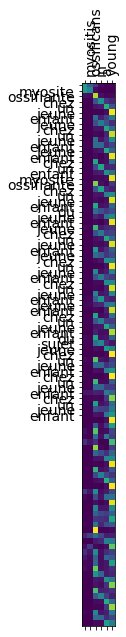

(' myosite ossifiante chez un jeune enfant jeune chez un jeune enfant jeune enfant chez un enfant myosite ossifiante chez un jeune enfant du jeune enfant jeune chez un jeune enfant jeune chez un jeune enfant chez un jeune enfant jeune enfant chez un jeune enfant du sujet jeune chez un jeune enfant chez un jeune enfant chez un jeune enfant jeune ',
 0,
 306.0)

In [27]:
src_sent = 'myositis ossificans in a young child '
tgt_sent = 'myosite ossifiante chez un jeune enfant'


translate_en_fr(src_sent,
                tgt_sent, 
                verbose = True,
                plot_att = True)